# Notebook 3

## Imports

In [1]:
# data
from obspy import read as obsread
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
#import functions as fn
# plotting
#import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json
from scipy.io import wavfile

# general
from datetime import datetime
import re

from scipy.signal import welch

from geopy.distance import geodesic
import plotly.express as px
import datetime

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Functions

In [99]:
CC_node_LF = 'Central_Caldera'
EC_node_LF = 'Eastern_Caldera'
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
abdist = (45.8168, -129.7543)
def animate_map(ais, starttime, endtime):
    subais = ais[(ais['TIMESTAMP UTC'] > starttime) & (ais['TIMESTAMP UTC'] < endtime)]
    time = subais['TIMESTAMP UTC']
    for i in time:
        #subais.loc[len(subais.index)] = [0,0,'cc hydrophone'+str(i),'cc hydrophone',0,0,0, -130.0089,45.9549,0,0, i, 0,0]
        #subais.loc[len(subais.index)] = [0,0, 'cc hydrophone '+str(i), 'cc hydrophone', 0,0,0,i,0, 0,0,45.9549, -130.0089, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'cc hydrophone '+str(i), 'cc hydrophone', 0, 0, 45.9549, -130.0089, 0, 0, i, 0, 0, 0, 0]
        
        #subais.loc[len(subais.index)] = [0,0,'ec hydrophone'+str(i),'ec hydrophone',0,0,10, -129.9742,45.9399,0,0, i, 0,0]
        #subais.loc[len(subais.index)] = [0,0, 'ec hydrophone '+str(i), 'ec hydrophone', 0,0,0,i,0, 0,0,45.9399, -129.9742, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'ec hydrophone '+str(i), 'ec hydrophone', 0, 0, 45.9399, -129.9742, 0, 0, i, 0, 0, 0, 0]

        #subais.loc[len(subais.index)] = [0,0, 'ab hydrophone '+str(i), 'ab hydrophone', 0,0,0,i,0, 0,0,45.8168, -129.7543, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'ab hydrophone '+str(i), 'ab hydrophone', 0, 0, 45.8168, -129.7543, 0, 0, i, 0, 0, 0, 0]
    subais = subais.reset_index()
    for i in range(len(subais)):
        subais.loc[i,'TIMESTAMP UTC'] = subais.iloc[i]['TIMESTAMP UTC']- datetime.timedelta(minutes=subais.iloc[i]['TIMESTAMP UTC'].minute % 10)
    subais['TIMESTAMP UTC'] = subais['TIMESTAMP UTC'].dt.to_period('T')
    fig = px.scatter_mapbox(subais,
              lat="LAT" ,
              lon="LON",
              hover_name="VESSEL TYPE",
              hover_data= ['SPEED (KNOTSx10)','ccdist'],
              color="SHIPNAME",
              animation_frame=subais['TIMESTAMP UTC'].astype(dtype=str),
              mapbox_style='carto-positron',                 
              zoom=5)
    fig.show()

def get_PSD_dict(meta_data_CSV_path, location, close_distance=False):
    """
    Generate a dictionary that holds PSD data
    Ex. psd_dict[ship_type][freq_values] # not actual key names
    This data gets passed into the spdf generation and plotting functions
    
    Parameters
    ----------
    meta_data_CSV_path : str
        A file path that points to the .csv that contains the metadata. 
        Mainly used to group based on ship type (ud_group). Also matches instance_id
        to corresponding ship type.

    location : str
        String containing location of the hydrophone (i.e. Axial_Base).
        Used for file pathing

    Returns
    -------
    dict: a nested dictionary for ship type and their respective PSD data
    """

    df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)

    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group']).groupby('ud_group')

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_obj_list = []
        PSD_freq = []
        PSD_val = []
        dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
            # try-except deals with missing pickles
            try:
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                #print("Could not find pkl")
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

# function pulled from https://github.com/Ocean-Data-Lab/Website-backend     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'
    #plt.savefig(filepath+shipType+'.jpg', format='jpg')
    plt.savefig(filepath+title+'.jpg', format='jpg')
    plt.close() # suppress plotting

def get_PSD_dict_given_filt_df(df, location, close_distance=False):
    df = df.reset_index(drop=True)
    """df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)"""

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSD_obj_list = []
    PSD_freq = []
    PSD_val = []
    dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

    # for-loop to compile list of PSD data objects pulled from column
    for row_index, row in df.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        # get pickle files (DL locally? Call some API?)
        # local storage method
        data_path = 'data/' + location + '/'
        pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.json'
        #if (location == 'Eastern_Caldera'):
        #    pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
        # try-except deals with missing pickles
        try:
            print(pklfilepath)
            with open(pklfilepath, 'rb') as f:
                dict1 = json.load(f)
            #print("----------PKL FOUND----------")
            # create PSD object and fill out PSD object fields
            psd = ooipy.Psd(dict1['f'], dict1['psd'])
            dictPSD['objects'].append(psd)
            dictPSD['frequencies'].append(psd.freq)
            dictPSD['values'].append(psd.values)
        except FileNotFoundError:
            #print("Could not find pkl")
            #pass
            try:
                pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                pass
    #PSDs.update({group_name: dictPSD})
    return dictPSD

def Rx_level_from_df(df,location):
    """
    Requires dataframe for specific MMSI and maybe filtered to be sufficiently close to hydrophone.

    Return lists that contain range values (closest to farthest) within a set range (df param should already be filtered),
    and a list that contains the receive level, which is calculated from the FFT of the time series data.
    Due to needing the time series data, may be time-consuming to run.
    This data can be used to get source levels by adding/making up from Tx loss using a separate function.

    Parameters
    ----------
    df : Pandas dataframe
        A dataframe that is filtered to only contain one MMSI. Should probably also be close to hydrophone.

    Returns
    -------
    R : a list of range values in kilometers. When using it for Tx loss, need to make it an array and *1000 to get meters.

    Rx_level : a list of receive levels
    """

    df = df.sort_values(by=['distance(in km)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    R = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            R.append(df['distance(in km)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return R, Rx_level

def Rx_level_from_df_SPEED(df,location):

    df = df.sort_values(by=['SPEED (KNOTSx10)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    S = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            S.append(df['SPEED (KNOTSx10)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return S, Rx_level

Tx_loss1 = lambda x: 20*np.log10(x*1000)
#Tx_loss2 = lambda x: 20*np.log10(3*1000)+10*np.log10((x*1000)/(3*1000))

def Tx_loss2(x, location):
    depth_dict = {
            "AB": 3,
            "EC": 1.5,
            "CC": 1.5,
            "OS": 3,
            "SH": 0.8
        }
    return 20*np.log10(depth_dict[location]*1000)+10*np.log10((x*1000)/(depth_dict[location]*1000))
    
Tx_loss3 = lambda x: 15*np.log10(x*1000)


Tx_loss1_mod = lambda x, coeff: coeff*np.log10(x*1000)
#Tx_loss2 = lambda x: 20*np.log10(3*1000)+10*np.log10((x*1000)/(3*1000))

def Tx_loss2_mod(x, location, coeff):
    depth_dict = {
            "AB": 3,
            "EC": 1.5,
            "CC": 1.5,
            "OS": 3,
            "SH": 0.8
        }
    return coeff*np.log10(depth_dict[location]*1000)+10*np.log10((x*1000)/(depth_dict[location]*1000))

def split_10m(df):
    """
    Generate start_time, end_time columns in a given dataframe so that we can run hydrophone queries.
    Start and End times are in 10 minute intervals with one second added on so that it doesn't chain together.
    When creating, didn't account for edge case where pre-existing rows would already be 10 minutes apart perfectly.
    """

    df = df.reset_index(drop=True)
    df['start_time'] = pd.to_datetime(np.zeros(len(df)))
    df['end_time'] = pd.to_datetime(np.zeros(len(df)))
    df['TIMESTAMP UTC'] = pd.to_datetime(df['TIMESTAMP UTC'])
    df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
    df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)
    for index, row in df[1:].iterrows():
        curr_time = row['TIMESTAMP UTC']
        prev_start = df.iloc[index-1]['start_time']
        prev_end = df.iloc[index-1]['end_time']
        if curr_time > prev_end:
            #row['start_time'] = curr_time
            df.at[index, 'start_time'] = curr_time
            #row['end_time'] = curr_time + datetime.timedelta(minutes=10)
            df.at[index, 'end_time'] = curr_time + datetime.timedelta(minutes=10)
        elif curr_time < prev_end:
            #row['start_time'] = prev_start
            df.at[index, 'start_time'] = prev_start
            #row['end_time'] = prev_end
            df.at[index, 'end_time'] = prev_end
    return df

def DL_Mseed_for_time_filtered_file(ais, start, end, verbose=False, node_override=None):
    """
    Inteded to work with ais dataframe with columns 'MMSI', 'SHIPNAME', 'VESSEL TYPE', 'STATUS', 'SPEED (KNOTSx10)', 'LAT',
       'LON', 'COURSE', 'HEADING', 'TIMESTAMP UTC', 'LENGTH', 'start_time',
       'end_time', 'ecdist', 'ccdist', 'abdist', 'closest hphone'
    """
    
    ais = ais[(ais['TIMESTAMP UTC'] >= start) & (ais['TIMESTAMP UTC'] <= end)]

    xxdist_to_node_dict = {
        'abdist' : "AB",
        'ecdist' : "EC",
        'ccdist' : "CC",
        'AB' : 'Axial_Base',
        'EC' : 'Eastern_Caldera',
        'CC' : 'Central_Caldera'
    }

    times = {
        'start_time': ais['start_time'],
        'end_time': ais['end_time'],
        'node' : ais['closest hphone']
    }
    times = pd.DataFrame(times)
    times.drop_duplicates(subset=['start_time', 'end_time', 'node'], inplace=True)

    for index, row in times.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']
        str_starttime=start_time.strftime("%Y%m%d%H%M%S")
        str_endtime=end_time.strftime("%Y%m%d%H%M%S")
        node = xxdist_to_node_dict[row['node']]
        if node_override != None:
            node = node_override
        mseed_filename = 'data/AIS/Mseed/'+str(node)+'_'
        psd_pickle_filename = 'data/AIS/PSD_pickles/' + str(node)+'_'
        data_trace = ooipy.get_acoustic_data_LF(start_time, end_time, xxdist_to_node_dict[node], verbose=False, zero_mean=True)
        print(data_trace)
        if data_trace==None:
            print('data trace is none. Continuing to next')
            pass
        else:
            data_trace.write(mseed_filename+str_starttime+'_'+str_endtime+'.mseed', format='MSEED')
            if verbose:
                print('saving '+mseed_filename+str_starttime+'_'+str_endtime+'.mseed')
            try:
                psd = data_trace.compute_psd_welch(L = 256, overlap=0.3)
                psd.save(filename=psd_pickle_filename+str_starttime+'_'+str_endtime+'.json')
            except TypeError:
                print('could not compute psd for above data trace. Continuing to next')
                pass

def add_hphone_dist(ais):
    abdist = (45.8168, -129.7543)
    ecdist = (45.9399, -129.9742)
    ccdist = (45.9549, -130.0089)
    ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['closest hphone'] = ais[['ecdist', 'ccdist', 'abdist']].idxmin(axis=1)
    return ais

def ten_min_interp(df):
    #interpolated_data = []
    new_timestamps = []

    # create intermediary timestamps at 10m1s intervals to avoid all having the same start time
    for idx, row in df[:-1].iterrows():
        #print(idx)
        curr_time = pd.to_datetime(row['TIMESTAMP UTC'])
        start_time = pd.to_datetime(row['start_time'])
        end_time = pd.to_datetime(row['end_time'])
        #next_time = pd.to_datetime(blah.iloc[idx+1]['TIMESTAMP UTC'])
        next_time = pd.to_datetime(df.at[idx+1, 'TIMESTAMP UTC'])
        #print(f'curr: {curr_time}, next: {next_time}')
        range_time = (pd.date_range(start=curr_time, end=next_time, freq='601S'))
        #print(range_time)
        new_timestamps.append(range_time)

    # interpolated times to add (includes existing timestamps)
    new_timestamps = new_timestamps[0].union_many(new_timestamps[1:])

    times_dict = {'TIMESTAMP UTC' : new_timestamps}
    #interpolated_data.append(pd.DataFrame(times_dict))
    #result_df = pd.concat(interpolated_data, ignore_index=True)
    #result_df
    #blah = pd.merge(df, result_df, on='TIMESTAMP UTC', how='outer')

    # merge/join interpolated data and existing rows
    interp_df = pd.merge(df, pd.DataFrame(times_dict), on='TIMESTAMP UTC', how='outer')
    # sort all real and interpolated rows based on timestamp so we can create start/end times
    interp_df_10m = split_10m(interp_df.sort_values('TIMESTAMP UTC'))

    # interpolate LAT/LON/Speed, put back in some other data
    interp_df_10m['LAT'] = interp_df_10m['LAT'].interpolate(method='linear')
    interp_df_10m['LON'] = interp_df_10m['LON'].interpolate(method='linear')
    interp_df_10m['SPEED (KNOTSx10)'] = interp_df_10m['SPEED (KNOTSx10)'].interpolate(method='linear')
    interp_df_10m['MMSI'] = interp_df_10m.iloc[0]['MMSI']
    interp_df_10m['SHIPNAME'] = interp_df_10m.iloc[0]['SHIPNAME']
    interp_df_10m['VESSEL TYPE'] = interp_df_10m.iloc[0]['VESSEL TYPE']
    interp_df_10m['LENGTH'] = interp_df_10m.iloc[0]['LENGTH']

    # add hphone distances
    interp_df_10m = add_hphone_dist(interp_df_10m)
    return interp_df_10m

# MMSI 356190000 AIS Data
Shifting focus to only one MMSI in the Axial Seamount area (contains AB, EC, CC hphones). Instances found in 2016 and 2017.


## Work

### AIS Data setup/exploration

In [79]:
ais2016a = pd.read_csv('data/AIS/2016A - Updated.csv', delimiter=',')
ais2016b = pd.read_csv('data/AIS/2016B - Updated.csv', delimiter=',')
ais2017a = pd.read_csv('data/AIS/2017A - Updated.csv', delimiter=',')
ais2017b = pd.read_csv('data/AIS/2017B - Updated.csv', delimiter=',')
MMSI = 356190000
spectrogram_times = {
    'EC' : ['2017-07-27 07:13:10', '2017-07-27 08:07:23'],
    'CC' : ['2017-07-27 04:02:56', '2017-07-27 08:07:23'],
    'AB' : ['2017-08-17 03:22:52', '2017-08-17 05:37:51']
}
ais = pd.concat([ais2016a, ais2016b, ais2017a, ais2017b], axis=0)
ais = ais[ais['MMSI'] == MMSI]#.reset_index(drop=True)
ais

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
51516  356190000  PANTERA ROSA  Bulk Carrier       0               144   
51523  356190000  PANTERA ROSA  Bulk Carrier       0               139   
51526  356190000  PANTERA ROSA  Bulk Carrier       0               136   
51531  356190000  PANTERA ROSA  Bulk Carrier       0               137   
51539  356190000  PANTERA ROSA  Bulk Carrier       0               123   
...          ...           ...           ...     ...               ...   
37636  356190000  PANTERA ROSA  Bulk Carrier       0               114   
37644  356190000  PANTERA ROSA  Bulk Carrier       0               113   
37652  356190000  PANTERA ROSA  Bulk Carrier       0               114   
37671  356190000  PANTERA ROSA  Bulk Carrier       0               116   
37679  356190000  PANTERA ROSA  Bulk Carrier       0               116   

            LAT       LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
51516  44.93581 -129.7273      78       74  2016-11-15 22:03:35   225.0  
51523  44.96260 -129.6014      71       71  2016-11-15 22:27:29   225.0  
51526  44.96832 -129.5753      73       70  2016-11-15 22:32:30   225.0  
51531  45.00777 -129.3981      71       70  2016-11-15 23:06:10   225.0  
51539  45.04543 -129.2250      72       70  2016-11-15 23:42:03   225.0  
...         ...       ...     ...      ...                  ...     ...  
37636  46.60880 -130.8140     283      284  2017-10-30 08:05:06   225.0  
37644  46.63559 -130.9723     282      284  2017-10-30 08:40:29   225.0  
37652  46.64405 -131.0218     282      284  2017-10-30 08:51:38   225.0  
37671  46.66926 -131.1685     284      287  2017-10-30 09:24:07   225.0  
37679  46.68549 -131.2573     284      286  2017-10-30 09:43:48   225.0  

[589 rows x 11 columns]

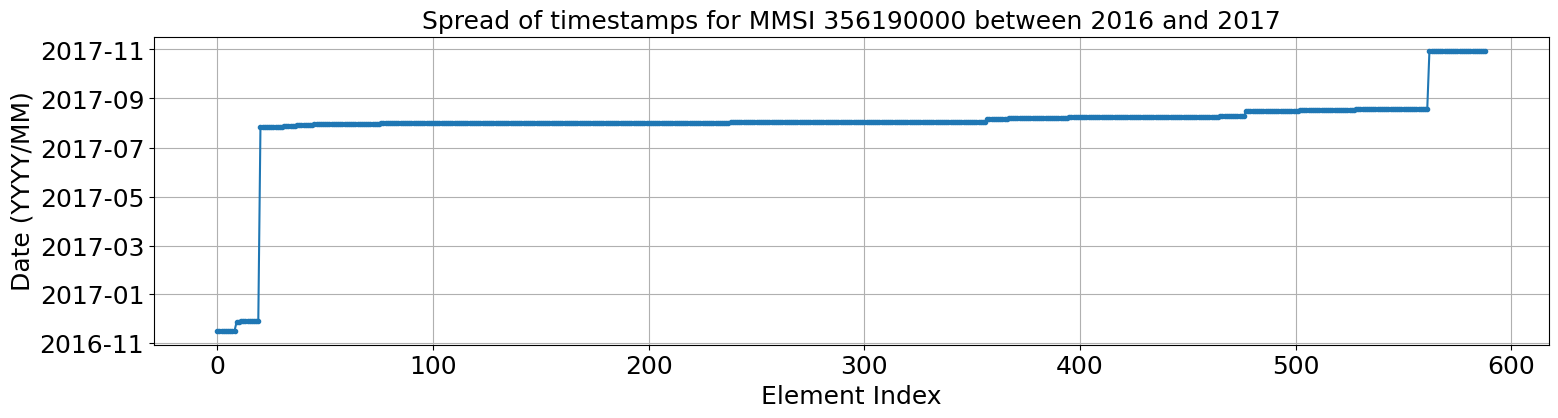

In [7]:
plt.subplots(figsize=(18,4))
plt.plot(pd.to_datetime(ais['TIMESTAMP UTC'].reset_index(drop=True)), marker='.')
plt.xlabel('Element Index', fontsize=18)
plt.ylabel('Date (YYYY/MM)', fontsize=18)
plt.title('Spread of timestamps for MMSI '+str(MMSI) + ' between 2016 and 2017', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

#### Checking AIS Data
Find a suitable time frame, interpolate data as needed, find closest hphone, break into ten minute chunks, query OOI, save Mseed, get rx level


(array([437., 432., 428., 428., 429., 434., 434., 426., 428., 429.]),
 array([   0. ,  425.6,  851.2, 1276.8, 1702.4, 2128. , 2553.6, 2979.2,
        3404.8, 3830.4, 4256. ]),
 <BarContainer object of 10 artists>)

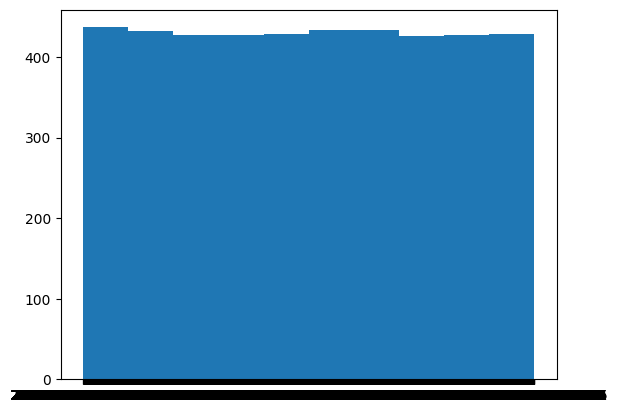

In [9]:
# this block is for finding which timeframe is most "data-dense"

# choose this timeframe? Seems most dense
df = ais[(ais['TIMESTAMP UTC'] > '2017-07-29 22:03:35') & (ais['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
#df = ais[(ais['TIMESTAMP UTC'] > '2017-08-02 00:03:35') & (ais['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
plt.hist(df['TIMESTAMP UTC'])
#plt.ylim(0, 10)

In [78]:
df

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
51516  356190000  PANTERA ROSA  Bulk Carrier       0               144   
51523  356190000  PANTERA ROSA  Bulk Carrier       0               139   
51526  356190000  PANTERA ROSA  Bulk Carrier       0               136   
51531  356190000  PANTERA ROSA  Bulk Carrier       0               137   
51539  356190000  PANTERA ROSA  Bulk Carrier       0               123   
...          ...           ...           ...     ...               ...   
37636  356190000  PANTERA ROSA  Bulk Carrier       0               114   
37644  356190000  PANTERA ROSA  Bulk Carrier       0               113   
37652  356190000  PANTERA ROSA  Bulk Carrier       0               114   
37671  356190000  PANTERA ROSA  Bulk Carrier       0               116   
37679  356190000  PANTERA ROSA  Bulk Carrier       0               116   

            LAT       LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
51516  44.93581 -129.7273      78       74  2016-11-15 22:03:35   225.0  
51523  44.96260 -129.6014      71       71  2016-11-15 22:27:29   225.0  
51526  44.96832 -129.5753      73       70  2016-11-15 22:32:30   225.0  
51531  45.00777 -129.3981      71       70  2016-11-15 23:06:10   225.0  
51539  45.04543 -129.2250      72       70  2016-11-15 23:42:03   225.0  
...         ...       ...     ...      ...                  ...     ...  
37636  46.60880 -130.8140     283      284  2017-10-30 08:05:06   225.0  
37644  46.63559 -130.9723     282      284  2017-10-30 08:40:29   225.0  
37652  46.64405 -131.0218     282      284  2017-10-30 08:51:38   225.0  
37671  46.66926 -131.1685     284      287  2017-10-30 09:24:07   225.0  
37679  46.68549 -131.2573     284      286  2017-10-30 09:43:48   225.0  

[589 rows x 11 columns]

#### Splitting into 10min chunks

In [79]:
#df = df[(df['TIMESTAMP UTC'] > '2017-07-29 22:03:35') & (df['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
ais = split_10m(df)
#ais = add_hphone_dist(ais)


ais



C:\Users\UserALai\AppData\Local\Temp\ipykernel_2332\704785997.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_2332\704785997.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
0    356190000  PANTERA ROSA  Bulk Carrier       0               144   
1    356190000  PANTERA ROSA  Bulk Carrier       0               139   
2    356190000  PANTERA ROSA  Bulk Carrier       0               136   
3    356190000  PANTERA ROSA  Bulk Carrier       0               137   
4    356190000  PANTERA ROSA  Bulk Carrier       0               123   
..         ...           ...           ...     ...               ...   
584  356190000  PANTERA ROSA  Bulk Carrier       0               114   
585  356190000  PANTERA ROSA  Bulk Carrier       0               113   
586  356190000  PANTERA ROSA  Bulk Carrier       0               114   
587  356190000  PANTERA ROSA  Bulk Carrier       0               116   
588  356190000  PANTERA ROSA  Bulk Carrier       0               116   

          LAT       LON  COURSE  HEADING       TIMESTAMP UTC  LENGTH  \
0    44.93581 -129.7273      78       74 2016-11-15 22:03:35   225.0   
1    44.96260 -129.6014      71       71 2016-11-15 22:27:29   225.0   
2    44.96832 -129.5753      73       70 2016-11-15 22:32:30   225.0   
3    45.00777 -129.3981      71       70 2016-11-15 23:06:10   225.0   
4    45.04543 -129.2250      72       70 2016-11-15 23:42:03   225.0   
..        ...       ...     ...      ...                 ...     ...   
584  46.60880 -130.8140     283      284 2017-10-30 08:05:06   225.0   
585  46.63559 -130.9723     282      284 2017-10-30 08:40:29   225.0   
586  46.64405 -131.0218     282      284 2017-10-30 08:51:38   225.0   
587  46.66926 -131.1685     284      287 2017-10-30 09:24:07   225.0   
588  46.68549 -131.2573     284      286 2017-10-30 09:43:48   225.0   

             start_time            end_time  
0   2016-11-15 22:03:35 2016-11-15 22:13:35  
1   2016-11-15 22:27:29 2016-11-15 22:37:29  
2   2016-11-15 22:27:29 2016-11-15 22:37:29  
3   2016-11-15 23:06:10 2016-11-15 23:16:10  
4   2016-11-15 23:42:03 2016-11-15 23:52:03  
..                  ...                 ...  
584 2017-10-30 08:05:06 2017-10-30 08:15:06  
585 2017-10-30 08:40:29 2017-10-30 08:50:29  
586 2017-10-30 08:51:38 2017-10-30 09:01:38  
587 2017-10-30 09:24:07 2017-10-30 09:34:07  
588 2017-10-30 09:43:48 2017-10-30 09:53:48  

[589 rows x 13 columns]

In [72]:
ais['end_time'].nunique()

320

#### Iterate through again and save Mseeds

In [34]:
xxdist_to_node_dict = {
    'abdist' : "AB",
    'ecdist' : "EC",
    'ccdist' : "CC",
    'AB' : 'Axial_Base',
    'EC' : 'Eastern_Caldera',
    'CC' : 'Central_Caldera'
}

times = {
    'start_time': ais['start_time'],
    'end_time': ais['end_time'],
    'node' : ais['closest hphone']
}
times = pd.DataFrame(times)
times.drop_duplicates(subset=['start_time', 'end_time', 'node'], inplace=True)

for index, row in times.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    str_starttime=start_time.strftime("%Y%m%d%H%M%S")
    str_endtime=end_time.strftime("%Y%m%d%H%M%S")
    node = xxdist_to_node_dict[row['node']]
    mseed_filename = 'data/AIS/Mseed/'+str(node)+'_'
    psd_pickle_filename = 'data/AIS/PSD_pickles/' + str(node)+'_'
    data_trace = ooipy.get_acoustic_data_LF(start_time, end_time, xxdist_to_node_dict[node], verbose=False, zero_mean=True)
    print(data_trace)
    if data_trace==None:
        print('data trace is none. Continuing to next')
        pass
    else:
        data_trace.write(mseed_filename+str_starttime+'_'+str_endtime+'.mseed', format='MSEED')
        try:
            psd = data_trace.compute_psd_welch(L = 256, overlap=0.3)
            psd.save(filename=psd_pickle_filename+str_starttime+'_'+str_endtime+'.json')
        except TypeError:
            print('could not compute psd for above data trace. Continuing to next')
            pass



IndentationError: expected an indented block (84781009.py, line 41)

In [52]:
# getting mseeds for time frame from spectrogram using AIS data

for node, times in spectrogram_times.items():
    print(node)
    print(times)
    start = times[0]
    end = times[1]
    if node == 'EC':
        DL_Mseed_for_time_filtered_file(ais, start, end, verbose=True, node_override=node)
    else:
        DL_Mseed_for_time_filtered_file(ais, start, end, verbose=True)

EC
['2017-07-27 07:13:10', '2017-07-27 08:07:23']
OO.AXEC2.AXEC2.HDH | 2017-07-27T07:13:10.000000Z - 2017-07-27T07:23:10.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727071310_20170727072310.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T08:07:23.000000Z - 2017-07-27T08:17:23.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727080723_20170727081723.mseed
CC
['2017-07-27 04:02:56', '2017-07-27 08:07:23']
OO.AXCC1.AXCC1.HDH | 2017-07-27T04:02:56.000000Z - 2017-07-27T04:12:56.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727040256_20170727041256.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T05:37:24.000000Z - 2017-07-27T05:47:24.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727053724_20170727054724.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T06:22:24.000000Z - 2017-07-27T06:32:24.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727062224_20170727063224.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T07:13:10.000000Z - 2017-07-27T07:

### AIS Mapping

In [80]:
ais = df

abdist = (45.8168, -129.7543)
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]

ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC'])

animate_map(ais, '2016-11-15 22:03:35', '2017-10-30 09:43:48')

NameError: name 'df' is not defined

### EC Timeframe

In [81]:
EC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['EC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['EC'][1]) + datetime.timedelta(hours=3))]
EC_timeframe

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
5990  356190000  PANTERA ROSA  Bulk Carrier       2                 7   
5997  356190000  PANTERA ROSA  Bulk Carrier       2                 8   
6002  356190000  PANTERA ROSA  Bulk Carrier       2                 9   
6013  356190000  PANTERA ROSA  Bulk Carrier       2                10   
6052  356190000  PANTERA ROSA  Bulk Carrier       2                 2   

           LAT       LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
5990  45.99192 -130.0131     160      221  2017-07-27 05:37:24   225.0  
5997  45.98133 -130.0073     160      227  2017-07-27 06:22:24   225.0  
6002  45.96893 -129.9992     158      220  2017-07-27 07:13:10   225.0  
6013  45.95338 -129.9934     173      217  2017-07-27 08:07:23   225.0  
6052  45.92411 -129.9866     143      213  2017-07-27 10:40:21   225.0

In [82]:
EC_interpolated = ten_min_interp(split_10m(EC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
EC_interpolated['instance_id'] = 'EC_' + EC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + EC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
EC_interpolated['distance(in km)'] = EC_interpolated['ecdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


In [10]:
EC_interpolated.dropna()

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
0   356190000.0  PANTERA ROSA  Bulk Carrier     2.0               7.0   
5   356190000.0  PANTERA ROSA  Bulk Carrier     2.0               8.0   
11  356190000.0  PANTERA ROSA  Bulk Carrier     2.0               9.0   
17  356190000.0  PANTERA ROSA  Bulk Carrier     2.0              10.0   
33  356190000.0  PANTERA ROSA  Bulk Carrier     2.0               2.0   

         LAT       LON  COURSE  HEADING       TIMESTAMP UTC  LENGTH  \
0   45.99192 -130.0131   160.0    221.0 2017-07-27 05:37:24   225.0   
5   45.98133 -130.0073   160.0    227.0 2017-07-27 06:22:24   225.0   
11  45.96893 -129.9992   158.0    220.0 2017-07-27 07:13:10   225.0   
17  45.95338 -129.9934   173.0    217.0 2017-07-27 08:07:23   225.0   
33  45.92411 -129.9866   143.0    213.0 2017-07-27 10:40:21   225.0   

            start_time            end_time    ecdist    ccdist     abdist  \
0  2017-07-27 05:37:24 2017-07-27 05:47:24  4.051962  2.564807  17.377877   
5  2017-07-27 06:17:28 2017-07-27 06:27:28  3.275595  1.827036  16.672149   
11 2017-07-27 07:12:29 2017-07-27 07:22:29  2.338873  1.075749  15.807720   
17 2017-07-27 08:03:15 2017-07-27 08:13:15  1.312435  0.754028  14.898912   
33 2017-07-27 10:37:38 2017-07-27 10:47:38  1.243540  2.382596  13.436328   

   closest hphone                       instance_id  distance(in km)  
0          ccdist  EC_20170727053724_20170727054724         6.521000  
5          ccdist  EC_20170727061728_20170727062728         5.271558  
11         ccdist  EC_20170727071229_20170727072229         3.764052  
17         ccdist  EC_20170727080315_20170727081315         2.112160  
33         ecdist  EC_20170727103738_20170727104738         2.001284

#### Downloading node timeframe specific files

In [41]:
DL_Mseed_for_time_filtered_file(EC_interpolated, EC_interpolated.iloc[0]['TIMESTAMP UTC'], EC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='EC')

OO.AXEC2.AXEC2.HDH | 2017-07-27T05:37:24.000000Z - 2017-07-27T05:47:24.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727053724_20170727054724.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T05:47:25.000000Z - 2017-07-27T05:57:25.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727054725_20170727055725.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T05:57:26.000000Z - 2017-07-27T06:07:26.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727055726_20170727060726.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T06:07:27.000000Z - 2017-07-27T06:17:27.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727060727_20170727061727.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T06:17:28.000000Z - 2017-07-27T06:27:28.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727061728_20170727062728.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T06:32:25.000000Z - 2017-07-27T06:42:25.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727063225_20170727064225.msee

#### EC Plotting

Files not found: 0
Files not found: 0


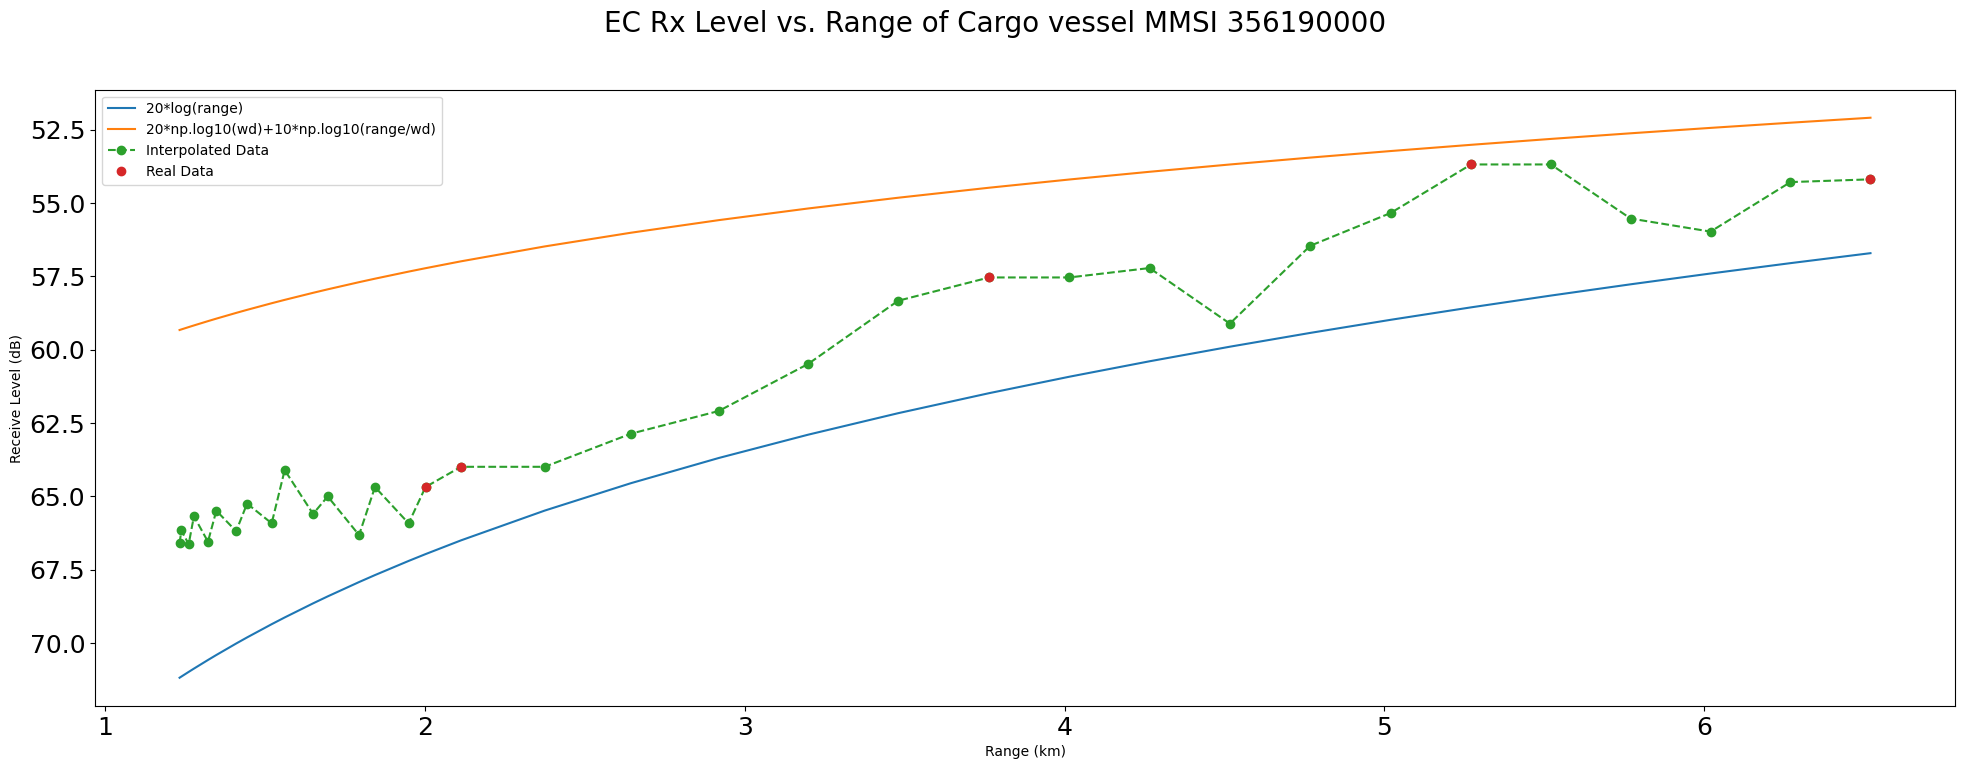

In [20]:
fig, ax = plt.subplots(figsize=(24,8))
EC_R, EC_Rx_level = Rx_level_from_df(EC_interpolated, 'AIS')
fig.suptitle('EC Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(EC_R, -1*Tx_loss1(np.asarray(EC_R))+133, label='20*log(range)')
ax.plot(EC_R, -1*Tx_loss2(np.asarray(EC_R), 'EC')+122, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.plot(EC_R, EC_Rx_level, 'o--', label='Interpolated Data')

EC_TRUE_R, EC_TRUE_Rx_level = Rx_level_from_df(EC_interpolated.dropna(), 'AIS')
ax.plot(EC_TRUE_R, EC_TRUE_Rx_level, 'o', label='Real Data')

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


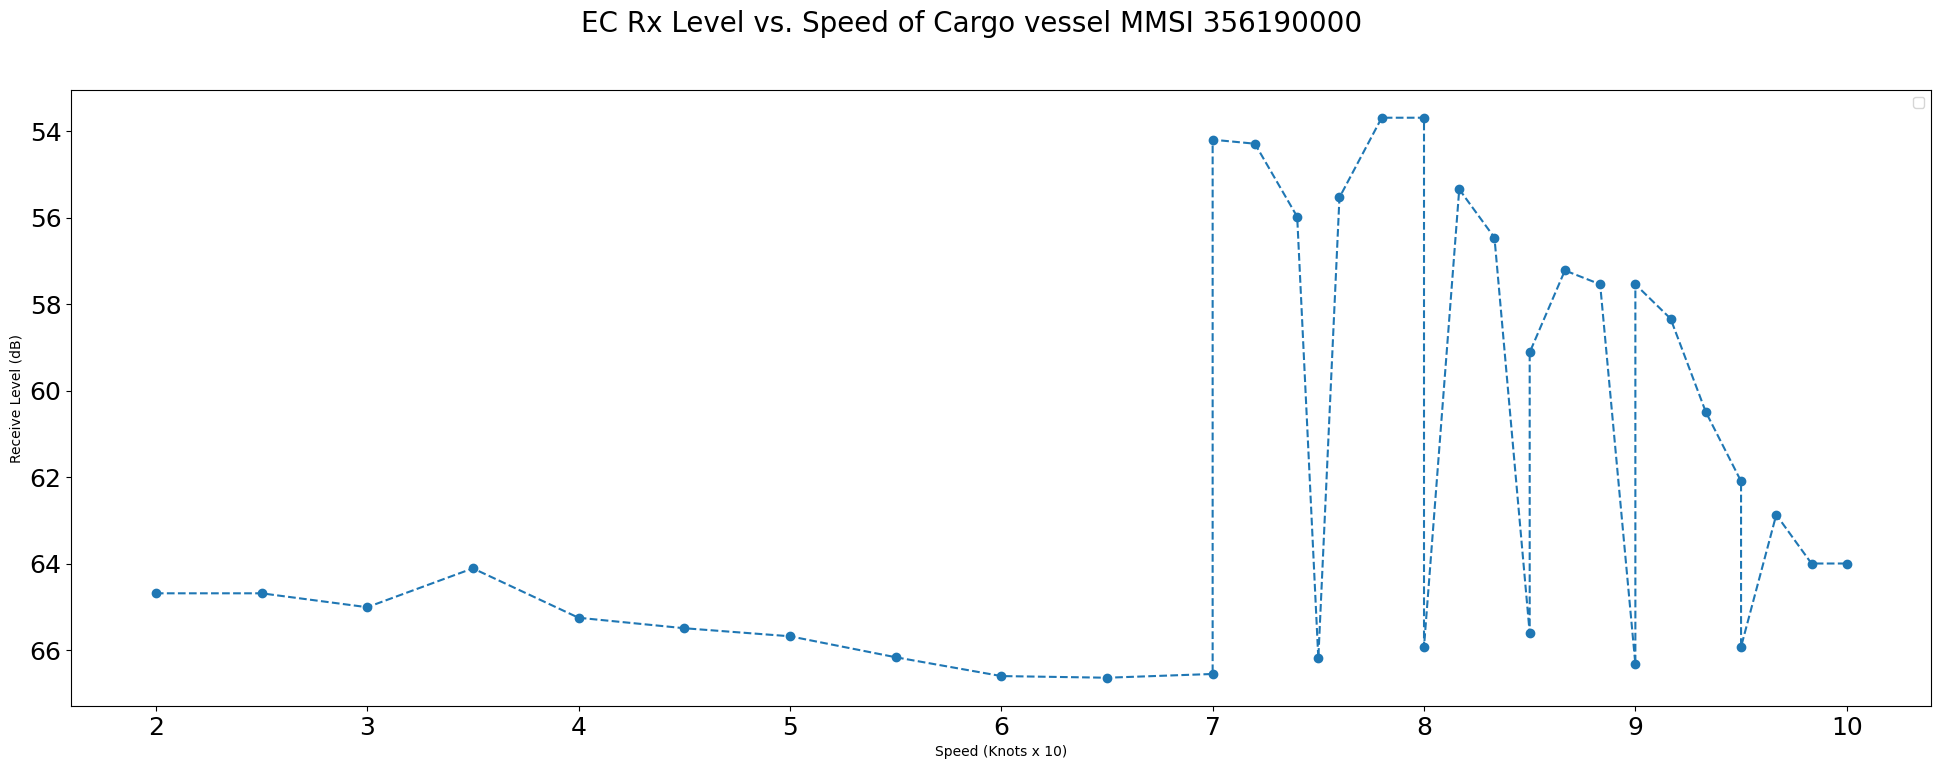

In [21]:
EC_S, EC_Rx_level = Rx_level_from_df_SPEED(EC_interpolated, 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('EC Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(EC_S, EC_Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')
plt.tick_params(axis='both', which='major', labelsize=18)

Files not found: 0


Text(0.5, 1.0, 'Speed over Range of Eastern Caldera Hydrophone')

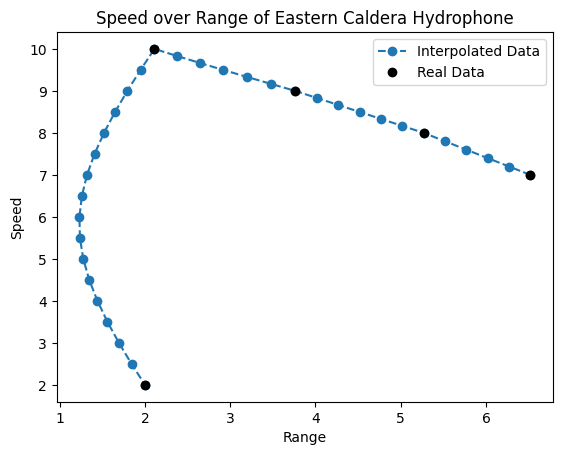

In [69]:
R, Rx_level = Rx_level_from_df(EC_interpolated, 'AIS')
#plt.plot(R, S, 'o-')
plt.plot(EC_interpolated['distance(in km)'], EC_interpolated['SPEED (KNOTSx10)'], 'o--', label='Interpolated Data')
plt.plot(EC_interpolated.dropna()['distance(in km)'], EC_interpolated.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
plt.legend()
plt.xlabel('Range')
plt.ylabel('Speed')
plt.title('Speed over Range of Eastern Caldera Hydrophone')

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


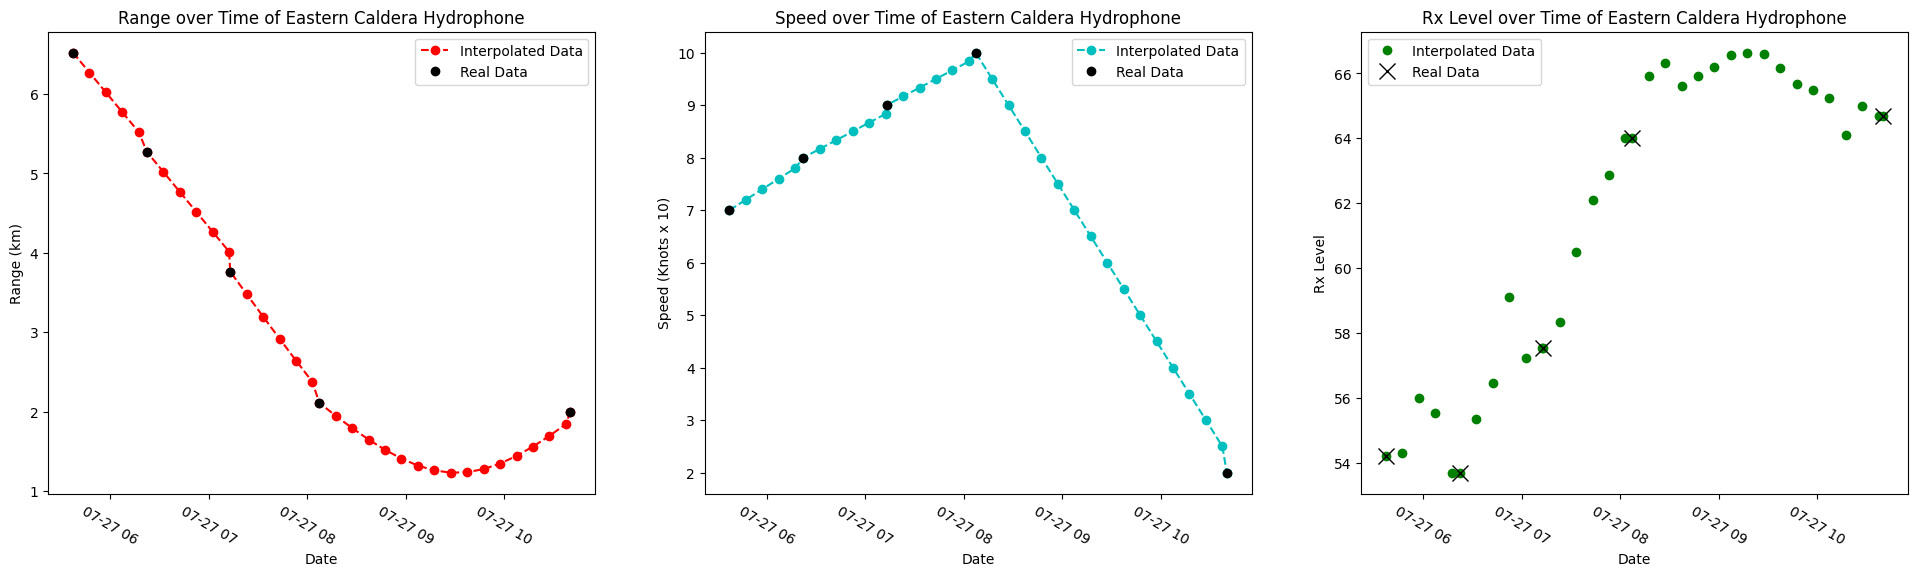

In [120]:
location = 'Eastern Caldera'
EC_data = EC_interpolated
fig, ax = plt.subplots(1, 3, figsize=(24,6))

EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')
S_real, Rx_level_real_S = Rx_level_from_df_SPEED(EC_data.dropna().reset_index(drop=True), 'AIS')
S, Rx_level_S = Rx_level_from_df_SPEED(EC_data, 'AIS')

ax[0].plot(EC_data['TIMESTAMP UTC'], EC_data['distance(in km)'], 'ro--', label='Interpolated Data')
ax[0].plot(EC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], EC_data.dropna()['distance(in km)'], 'ko', label='Real Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Range (km)')
ax[0].set_title('Range over Time of ' + location+ ' Hydrophone')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()


ax[1].plot(EC_data['TIMESTAMP UTC'], EC_data['SPEED (KNOTSx10)'], 'co--', label='Interpolated Data')
ax[1].plot(EC_data.dropna()['TIMESTAMP UTC'], EC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time of ' + location+ ' Hydrophone')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()


# DOUBLE CHECK THIS
# Rx level is calculated to correspond to range (close to far)
# I attempted a fix by sorting df by range and getting corresponding timestamp
ax[2].plot(EC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], EC_Rx_level, 'go', label='Interpolated Data')
ax[2].plot(EC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], EC_Rx_level_real, 'kx', label='Real Data', markersize=12)
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time of ' + location+ ' Hydrophone')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

Files not found: 0


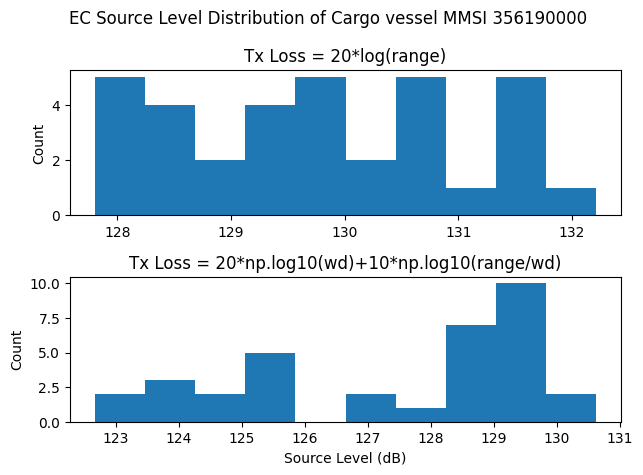

In [13]:
R, Rx_level = Rx_level_from_df(EC_interpolated, 'AIS')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('EC Source Level Distribution of Cargo vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'EC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

#### Spectrogram

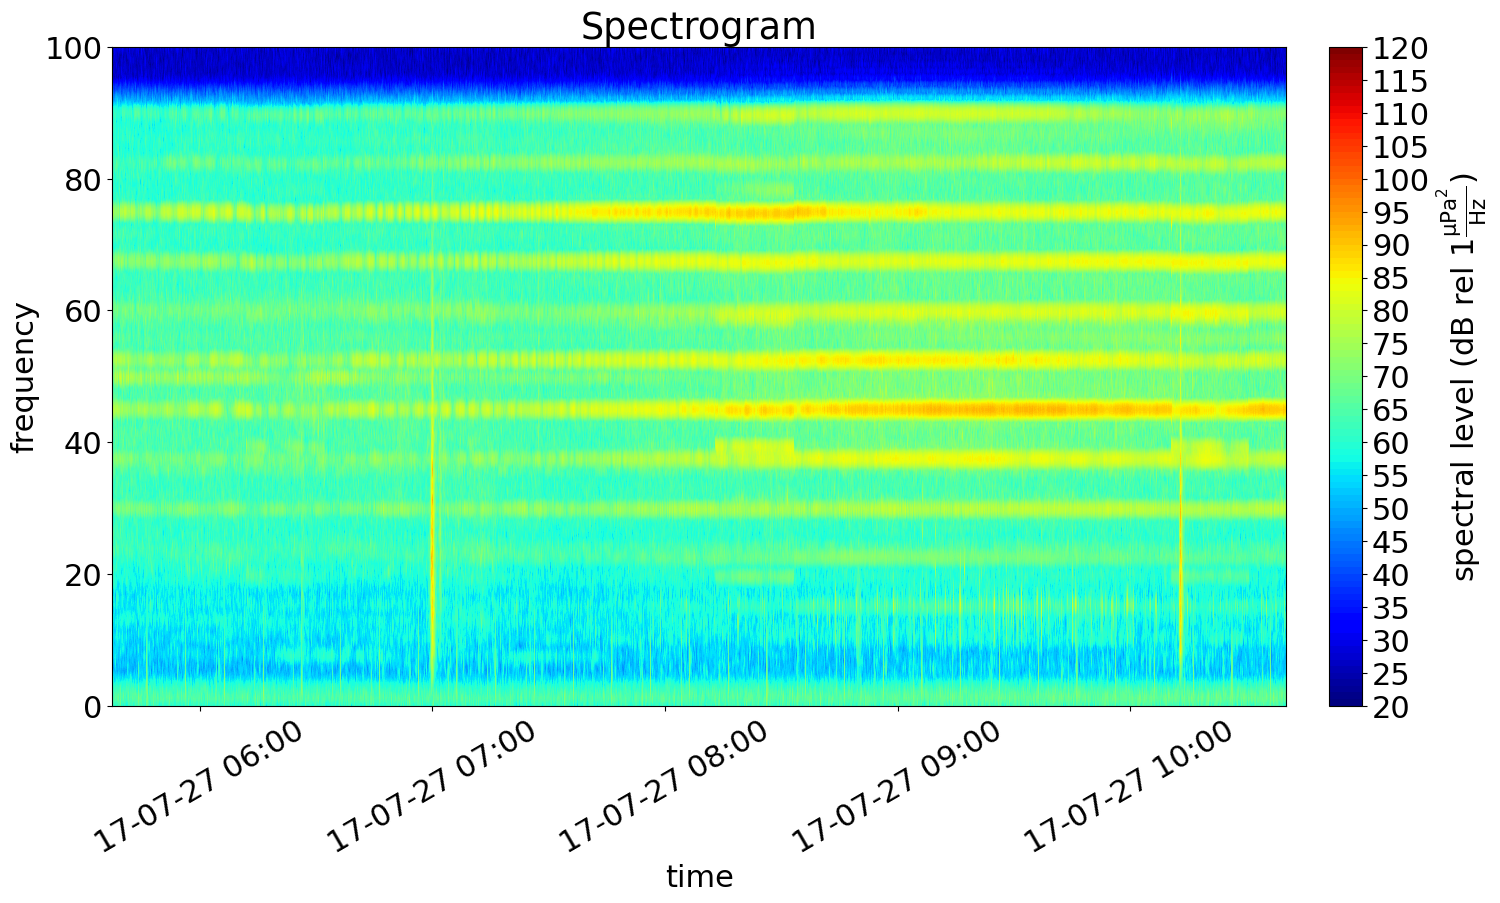

In [107]:
start_time = EC_interpolated['TIMESTAMP UTC'].iloc[0] #- datetime.timedelta(hours=3)
end_time = EC_interpolated['TIMESTAMP UTC'].iloc[-1]
hdata_EC = ooipy.get_acoustic_data_LF(start_time, end_time, 'Eastern_Caldera', verbose=True, zero_mean=True)
EC_spec_LF = hdata_EC.compute_spectrogram(avg_time=1, overlap=0,average_type="mean")

ooipy.plot(EC_spec_LF, fmin=0, fmax=100, vmax=120, xlabel_rot=30)

### CC Timeframe

In [83]:
CC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['CC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['CC'][1]) + datetime.timedelta(hours=3))]
CC_timeframe

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
5973  356190000  PANTERA ROSA  Bulk Carrier       0               113   
5977  356190000  PANTERA ROSA  Bulk Carrier       0               114   
5983  356190000  PANTERA ROSA  Bulk Carrier       0                84   
5990  356190000  PANTERA ROSA  Bulk Carrier       2                 7   
5997  356190000  PANTERA ROSA  Bulk Carrier       2                 8   
6002  356190000  PANTERA ROSA  Bulk Carrier       2                 9   
6013  356190000  PANTERA ROSA  Bulk Carrier       2                10   
6052  356190000  PANTERA ROSA  Bulk Carrier       2                 2   

           LAT       LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
5973  45.70712 -129.7581     330      329  2017-07-27 02:18:17   225.0  
5977  45.81064 -129.8424     329      329  2017-07-27 02:55:34   225.0  
5983  45.99289 -129.9945     331      328  2017-07-27 04:02:56   225.0  
5990  45.99192 -130.0131     160      221  2017-07-27 05:37:24   225.0  
5997  45.98133 -130.0073     160      227  2017-07-27 06:22:24   225.0  
6002  45.96893 -129.9992     158      220  2017-07-27 07:13:10   225.0  
6013  45.95338 -129.9934     173      217  2017-07-27 08:07:23   225.0  
6052  45.92411 -129.9866     143      213  2017-07-27 10:40:21   225.0

In [84]:
CC_interpolated = ten_min_interp(split_10m(CC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
CC_interpolated['instance_id'] = 'CC_' + CC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + CC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
CC_interpolated['distance(in km)'] = CC_interpolated['ccdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a 

#### Downloading node timeframe specific files

In [282]:
DL_Mseed_for_time_filtered_file(CC_interpolated, CC_interpolated.iloc[0]['TIMESTAMP UTC'], CC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='CC')

OO.AXCC1.AXCC1.HDH | 2017-07-27T02:18:17.000000Z - 2017-07-27T02:28:17.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727021817_20170727022817.mseed
None
data trace is none. Continuing to next
OO.AXCC1.AXCC1.HDH | 2017-07-27T02:38:19.000000Z - 2017-07-27T02:48:19.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727023819_20170727024819.mseed
None
data trace is none. Continuing to next
OO.AXCC1.AXCC1.HDH | 2017-07-27T03:05:35.000000Z - 2017-07-27T03:15:35.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727030535_20170727031535.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T03:15:36.000000Z - 2017-07-27T03:25:36.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727031536_20170727032536.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T03:25:37.000000Z - 2017-07-27T03:35:37.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727032537_20170727033537.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T03:35:38.000000Z - 2017-07-27T03:45:38.000000

#### CC Plotting

Files not found: 0
Files not found: 0


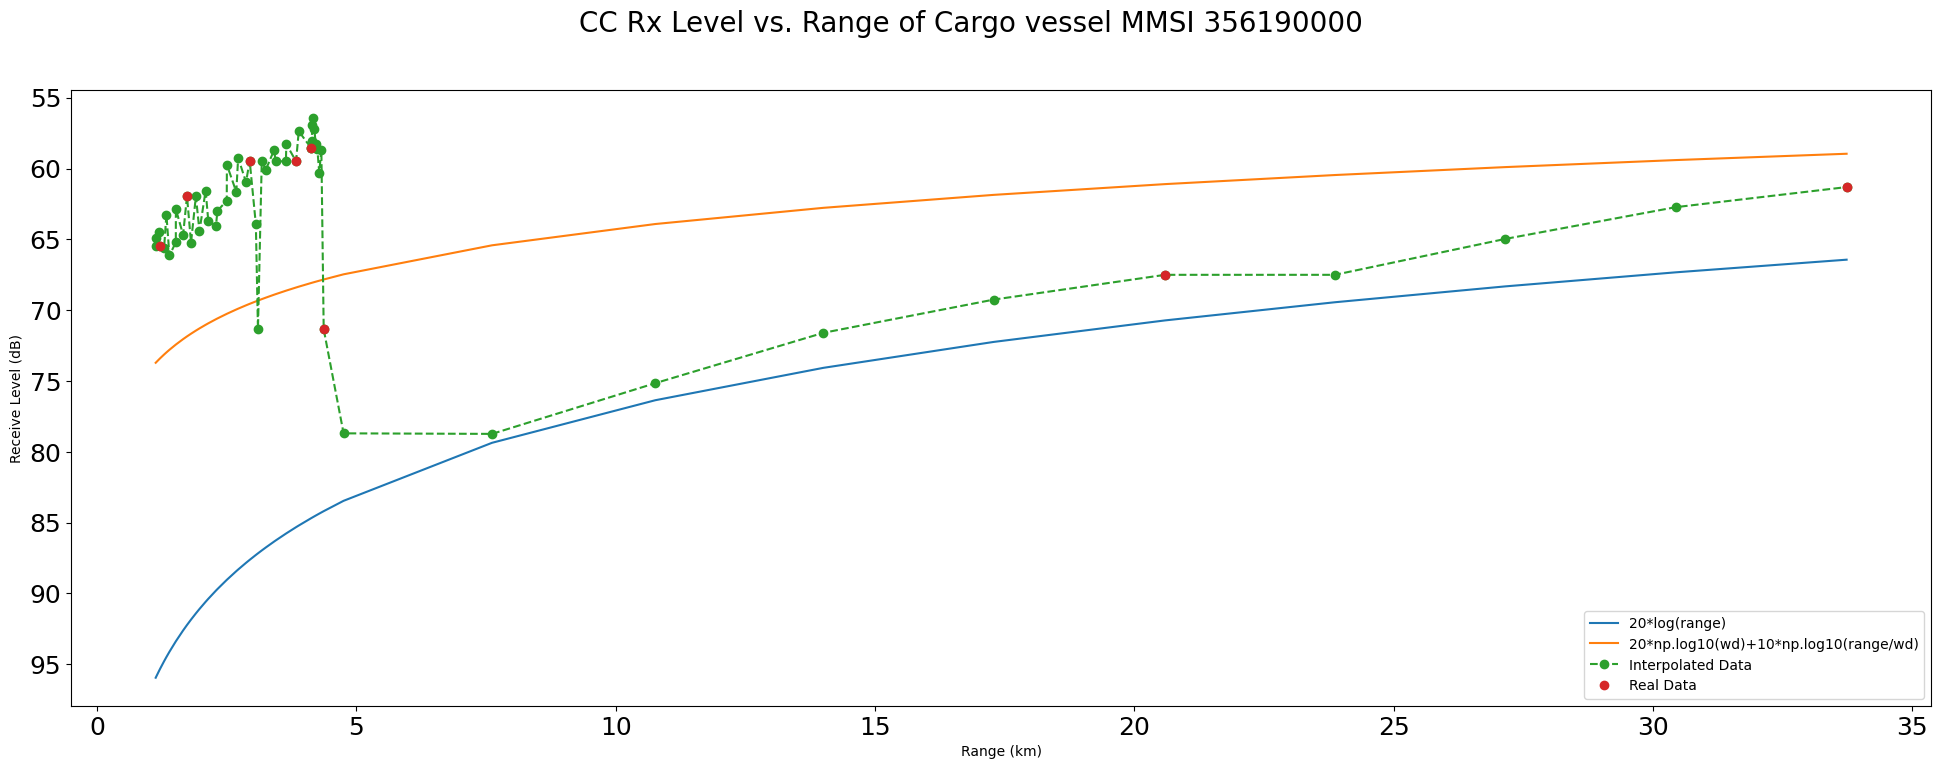

In [17]:
fig, ax = plt.subplots(figsize=(24,8))
CC_R, CC_Rx_level = Rx_level_from_df(CC_interpolated, 'AIS')
fig.suptitle('CC Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(CC_R, -1*Tx_loss1(np.asarray(CC_R))+157, label='20*log(range)')
ax.plot(CC_R, -1*Tx_loss2(np.asarray(CC_R), 'CC')+136, label='20*np.log10(wd)+10*np.log10(range/wd)')
#ax.plot(R, -1*Tx_loss2_mod(np.asarray(R), 'CC', 20)+136, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.plot(CC_R, CC_Rx_level, 'o--', label='Interpolated Data')

CC_TRUE_R, CC_TRUE_Rx_level = Rx_level_from_df(CC_interpolated.dropna(), 'AIS')
ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'o', label='Real Data')

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

Files not found: 0
Files not found: 0


(0.5, 5.0)

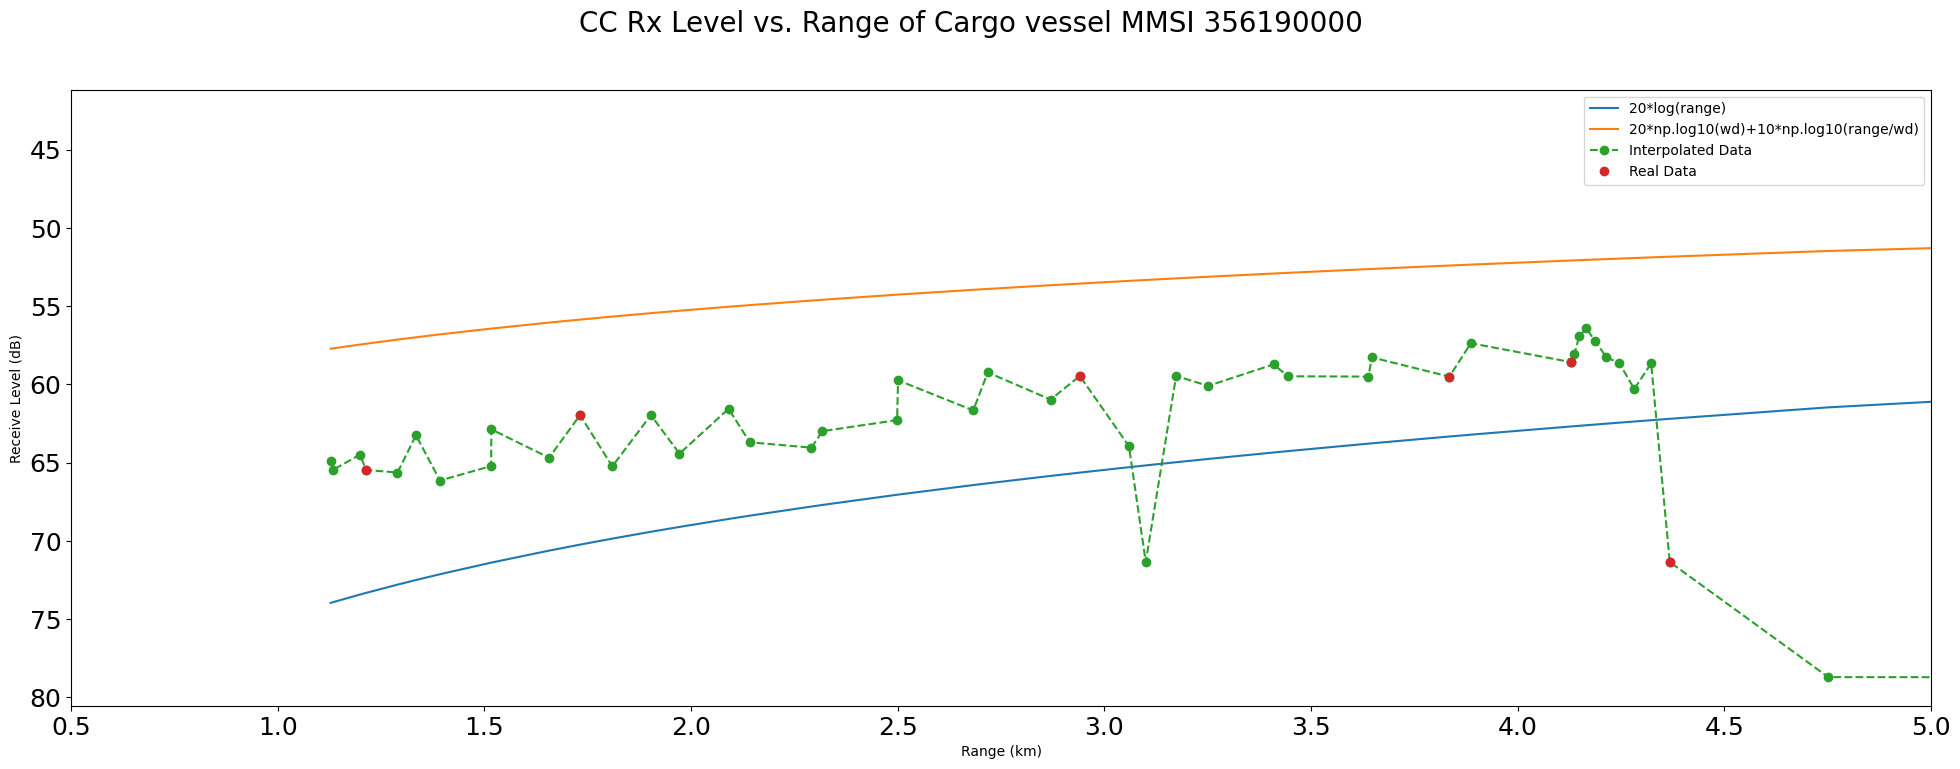

In [18]:
fig, ax = plt.subplots(figsize=(24,8))
CC_R, CC_Rx_level = Rx_level_from_df(CC_interpolated, 'AIS')
fig.suptitle('CC Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(CC_R, -1*Tx_loss1(np.asarray(CC_R))+135, label='20*log(range)')
ax.plot(CC_R, -1*Tx_loss2(np.asarray(CC_R), 'CC')+120, label='20*np.log10(wd)+10*np.log10(range/wd)')
#ax.plot(R, -1*Tx_loss2_mod(np.asarray(R), 'CC', 20)+136, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.plot(CC_R, CC_Rx_level, 'o--', label='Interpolated Data')

CC_TRUE_R, CC_TRUE_Rx_level = Rx_level_from_df(CC_interpolated.dropna(), 'AIS')
ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'o', label='Real Data')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(0.5, 5)

Files not found: 0


Text(0.5, 1.0, 'Speed over Range of Central Caldera Hydrophone')

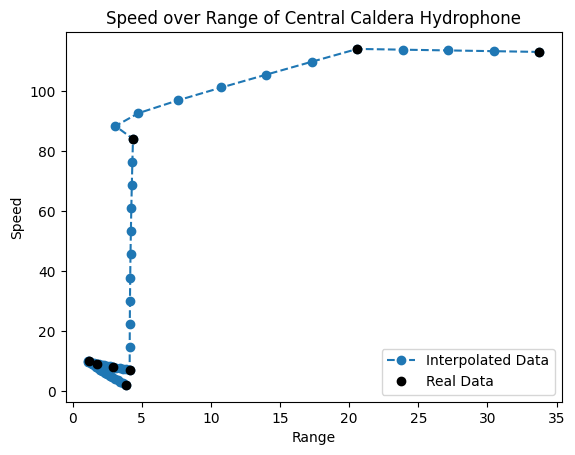

In [70]:
R, Rx_level = Rx_level_from_df(CC_interpolated, 'AIS')
#plt.plot(R, S, 'o-')
plt.plot(CC_interpolated['distance(in km)'], CC_interpolated['SPEED (KNOTSx10)'], 'o--', label='Interpolated Data')
plt.plot(CC_interpolated.dropna()['distance(in km)'], CC_interpolated.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
plt.legend()
plt.xlabel('Range')
plt.ylabel('Speed')
plt.title('Speed over Range of Central Caldera Hydrophone')

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


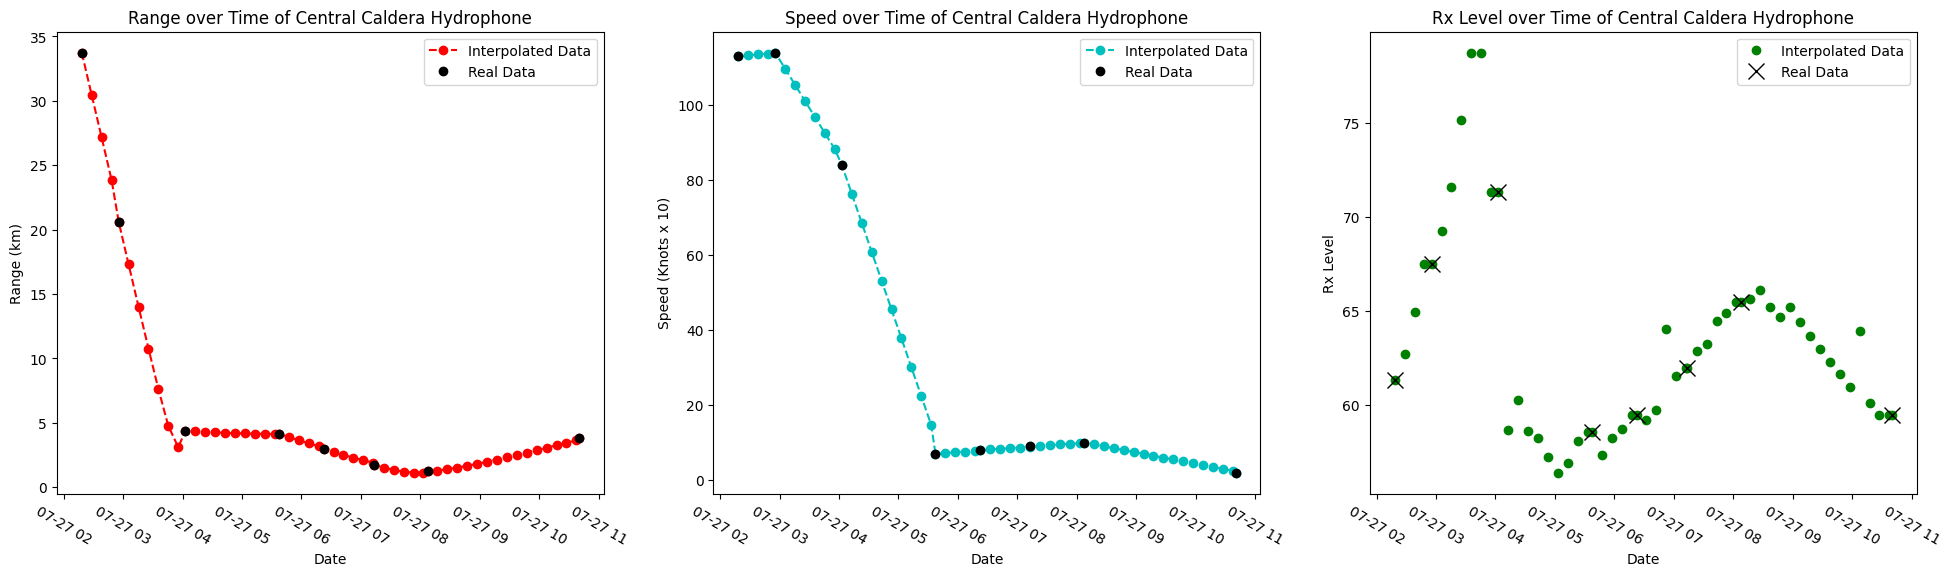

In [19]:
location = 'Central Caldera'
CC_data = CC_interpolated
fig, ax = plt.subplots(1, 3, figsize=(24,6))

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
S_real, Rx_level_real_S = Rx_level_from_df_SPEED(CC_data.dropna().reset_index(drop=True), 'AIS')
S, Rx_level_S = Rx_level_from_df_SPEED(CC_data, 'AIS')

ax[0].plot(CC_data['TIMESTAMP UTC'], CC_data['distance(in km)'], 'ro--', label='Interpolated Data')
ax[0].plot(CC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], CC_data.dropna()['distance(in km)'], 'ko', label='Real Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Range (km)')
ax[0].set_title('Range over Time of ' + location+ ' Hydrophone')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()


ax[1].plot(CC_data['TIMESTAMP UTC'], CC_data['SPEED (KNOTSx10)'], 'co--', label='Interpolated Data')
ax[1].plot(CC_data.dropna()['TIMESTAMP UTC'], CC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time of ' + location+ ' Hydrophone')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()


# DOUBLE CHECK THIS
# Rx level is calculated to correspond to range (close to far)
# I attempted a fix by sorting df by range and getting corresponding timestamp
ax[2].plot(CC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], CC_Rx_level, 'go', label='Interpolated Data')
ax[2].plot(CC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], CC_Rx_level_real, 'kx', label='Real Data', markersize=12)
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time of ' + location+ ' Hydrophone')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


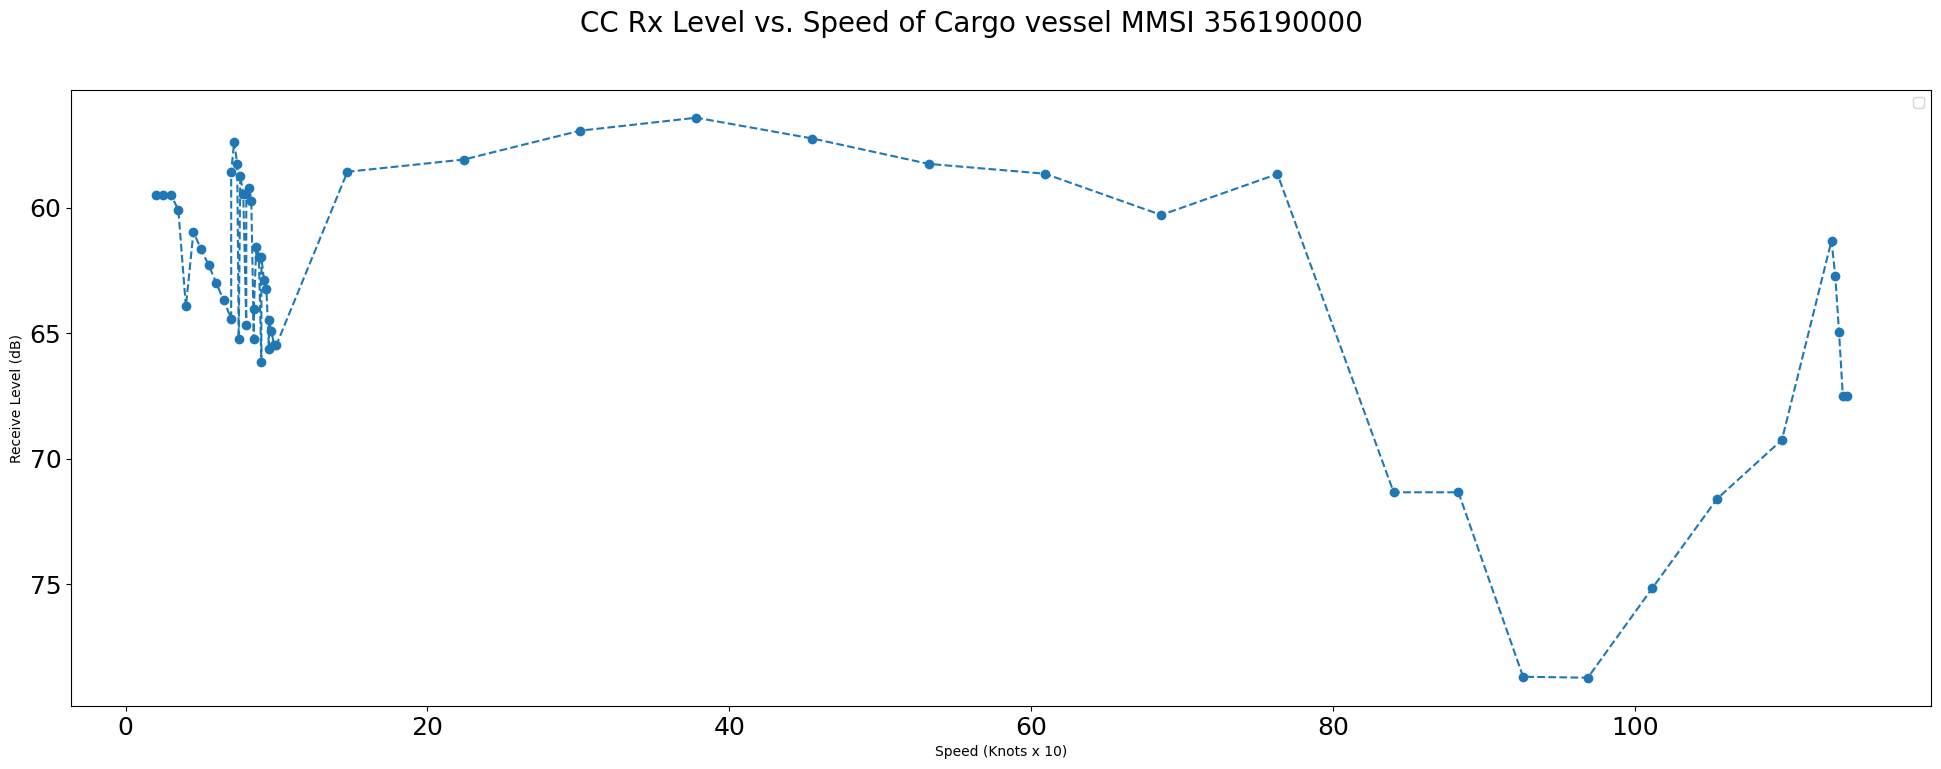

In [56]:
S, Rx_level = Rx_level_from_df_SPEED(CC_interpolated, 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('CC Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(S, Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')
plt.tick_params(axis='both', which='major', labelsize=18)


Files not found: 0


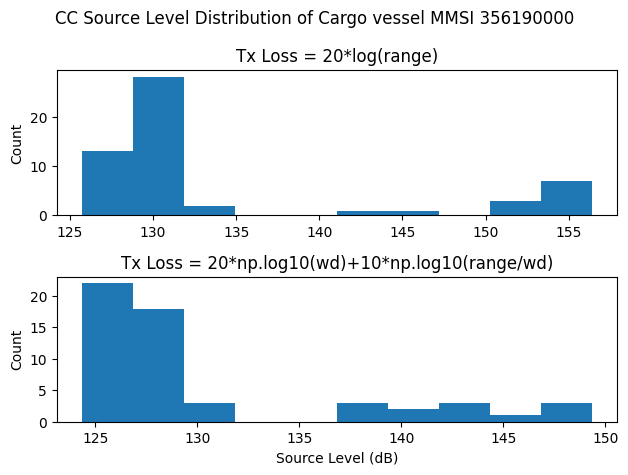

In [12]:
R, Rx_level = Rx_level_from_df(CC_interpolated, 'AIS')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('CC Source Level Distribution of Cargo vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'CC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

#### Spectrogram

c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning:

nperseg = 4096 is greater than input length  = 200, using nperseg = 200

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning:

The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'



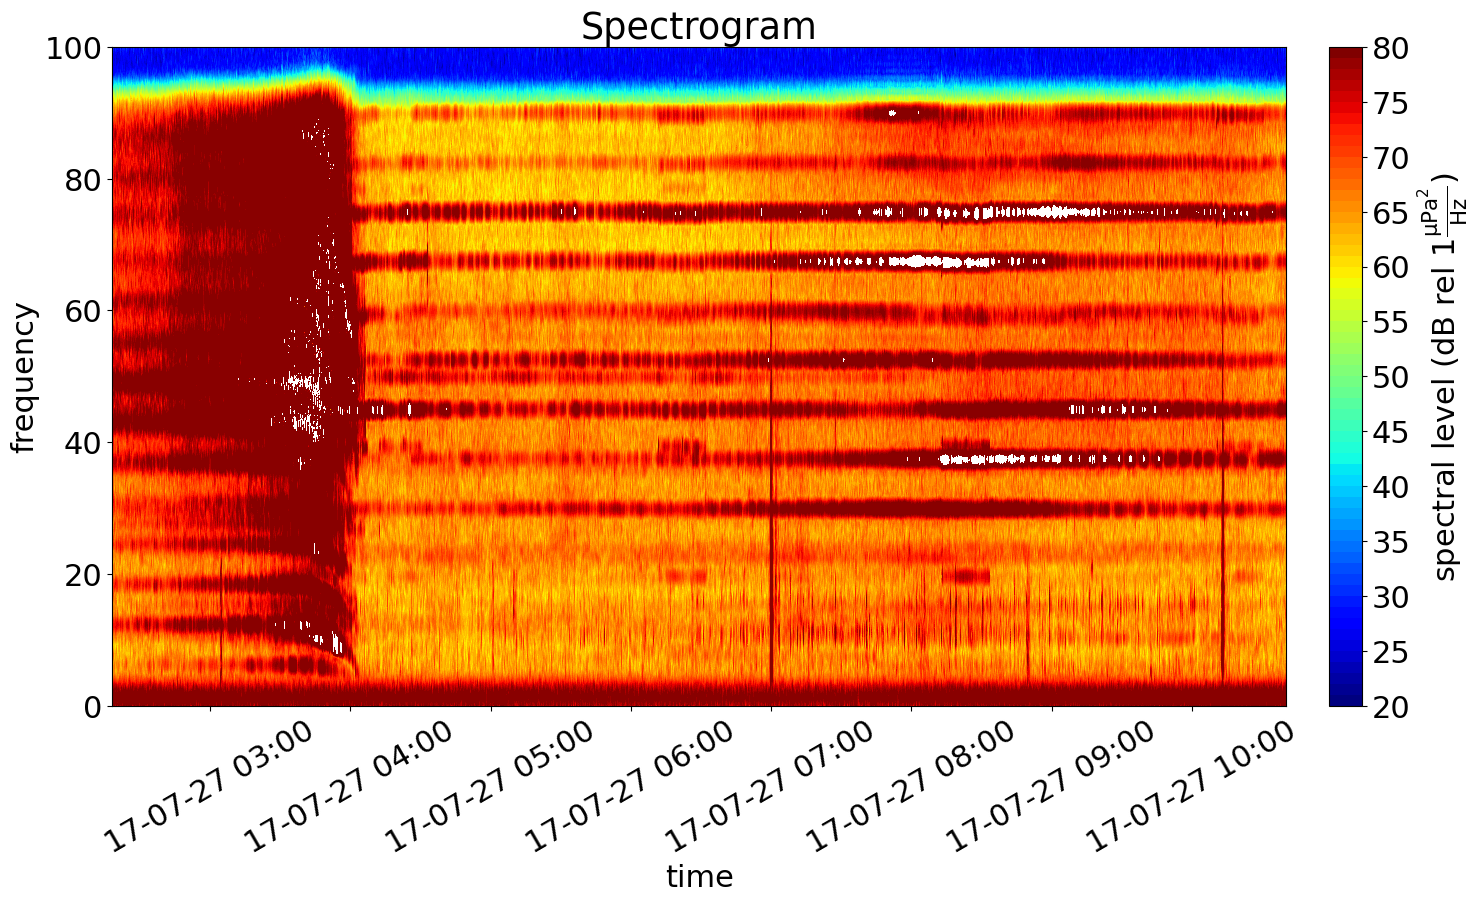

In [96]:
start_time = CC_interpolated['TIMESTAMP UTC'].iloc[0] #- datetime.timedelta(hours=3)
end_time = CC_interpolated['TIMESTAMP UTC'].iloc[-1]
hdata_CC = ooipy.get_acoustic_data_LF(start_time, end_time, 'Central_Caldera', verbose=True, zero_mean=True)
CC_spec_LF = hdata_CC.compute_spectrogram(avg_time=1, overlap=0,average_type="mean")

ooipy.plot(CC_spec_LF, fmin=0, fmax=100, vmax=120, xlabel_rot=30)

### AB Timeframe

In [85]:
AB_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['AB'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC'] )<= pd.to_datetime(spectrogram_times['AB'][1]) + datetime.timedelta(hours=3))]
AB_timeframe

MMSI      SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)  \
15676  356190000  PANTERA ROSA  Bulk Carrier       2                 6   
15683  356190000  PANTERA ROSA  Bulk Carrier       2                 9   
15721  356190000  PANTERA ROSA  Bulk Carrier       2                12   
15727  356190000  PANTERA ROSA  Bulk Carrier       2                10   
15733  356190000  PANTERA ROSA  Bulk Carrier       2                 7   
15742  356190000  PANTERA ROSA  Bulk Carrier       2                13   
15743  356190000  PANTERA ROSA  Bulk Carrier       2                 6   
15744  356190000  PANTERA ROSA  Bulk Carrier       2                10   
15758  356190000  PANTERA ROSA  Bulk Carrier       2                 6   
15759  356190000  PANTERA ROSA  Bulk Carrier       2                10   
15761  356190000  PANTERA ROSA  Bulk Carrier       2                 8   

            LAT       LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
15676  45.81182 -129.7672     141      225  2017-08-17 03:22:52   225.0  
15683  45.80788 -129.7632     159      226  2017-08-17 03:43:51   225.0  
15721  45.78728 -129.7459     156      222  2017-08-17 05:28:51   225.0  
15727  45.78505 -129.7446     157      223  2017-08-17 05:37:51   225.0  
15733  45.77673 -129.7414     188      224  2017-08-17 06:16:51   225.0  
15742  45.77268 -129.7407     181      224  2017-08-17 06:37:51   225.0  
15743  45.77210 -129.7408     186      222  2017-08-17 06:40:51   225.0  
15744  45.77144 -129.7407     188      222  2017-08-17 06:43:51   225.0  
15758  45.76439 -129.7405     176      231  2017-08-17 07:16:52   225.0  
15759  45.76329 -129.7403     172      229  2017-08-17 07:22:51   225.0  
15761  45.76209 -129.7402     192      225  2017-08-17 07:28:52   225.0

In [86]:
AB_interpolated = ten_min_interp(split_10m(AB_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
AB_interpolated['instance_id'] = 'AB_' + AB_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + AB_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
AB_interpolated['distance(in km)'] = AB_interpolated['abdist']*1.609344 # convert from milse to km
#AB_interpolated

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


#### Downloading node timeframe specific files

In [31]:
DL_Mseed_for_time_filtered_file(AB_interpolated, AB_interpolated.iloc[0]['TIMESTAMP UTC'], AB_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='AB')

OO.AXBA1.AXBA1.HDH | 2017-07-27T02:18:17.000000Z - 2017-07-27T02:28:17.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727021817_20170727022817.mseed
OO.AXBA1.AXBA1.HDH | 2017-07-27T02:28:18.000000Z - 2017-07-27T02:38:18.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727022818_20170727023818.mseed
OO.AXBA1.AXBA1.HDH | 2017-07-27T02:38:19.000000Z - 2017-07-27T02:48:19.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727023819_20170727024819.mseed
OO.AXBA1.AXBA1.HDH | 2017-07-27T02:48:20.000000Z - 2017-07-27T02:58:20.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727024820_20170727025820.mseed
OO.AXBA1.AXBA1.HDH | 2017-07-27T03:05:35.000000Z - 2017-07-27T03:15:35.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727030535_20170727031535.mseed
OO.AXBA1.AXBA1.HDH | 2017-07-27T03:15:36.000000Z - 2017-07-27T03:25:36.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20170727031536_20170727032536.msee

#### AB Plotting

Files not found: 0
Files not found: 0


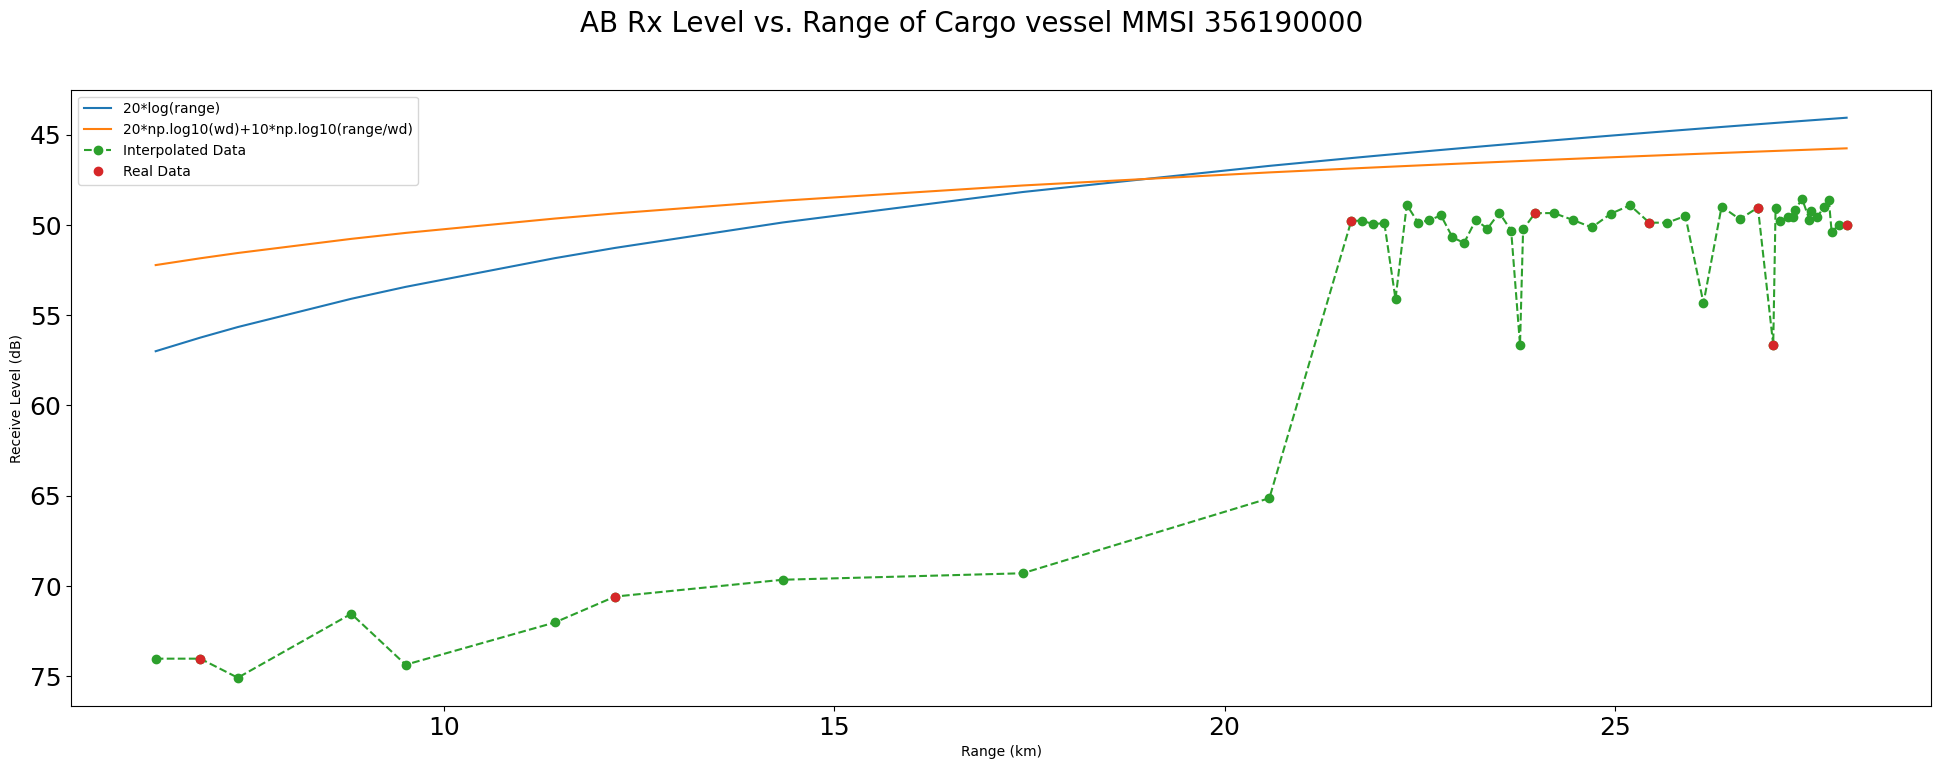

In [32]:
fig, ax = plt.subplots(figsize=(24,8))
AB_R, AB_Rx_level = Rx_level_from_df(AB_interpolated, 'AIS')
fig.suptitle('AB Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(AB_R, -1*Tx_loss1(np.asarray(AB_R))+133, label='20*log(range)')
ax.plot(AB_R, -1*Tx_loss2(np.asarray(AB_R), 'AB')+125, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.plot(AB_R, AB_Rx_level, 'o--', label='Interpolated Data')

AB_TRUE_R, AB_TRUE_Rx_level = Rx_level_from_df(AB_interpolated.dropna(), 'AIS')
ax.plot(AB_TRUE_R, AB_TRUE_Rx_level, 'o', label='Real Data')

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Files not found: 0


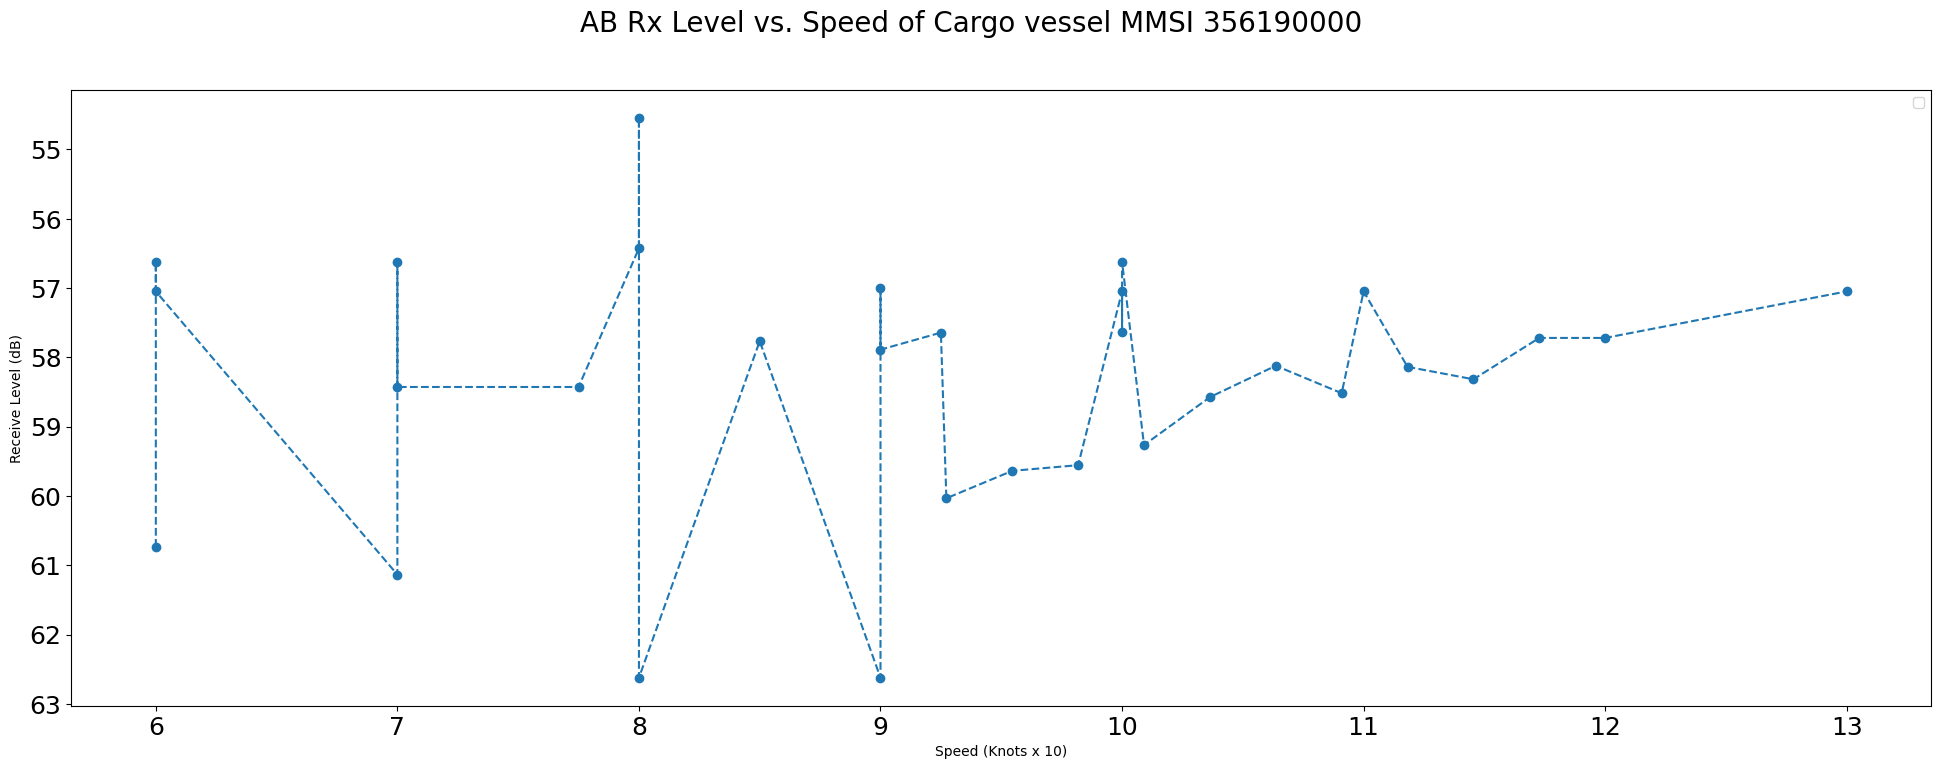

In [14]:
AB_S, AB_Rx_level = Rx_level_from_df_SPEED(AB_interpolated, 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('AB Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(AB_S, AB_Rx_level, 'o--')
#ax.plot(S, -1*Tx_loss1(np.asarray(S))+150, label='20*log(range)')
#ax.plot(S, -1*Tx_loss2(np.asarray(S), 'CC')+100, label='20*np.log10(wd)+10*np.log10(range/wd)')
ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Speed (Knots x 10)')
plt.tick_params(axis='both', which='major', labelsize=18)

Text(0.5, 1.0, 'Speed over Range of Axial Base Hydrophone')

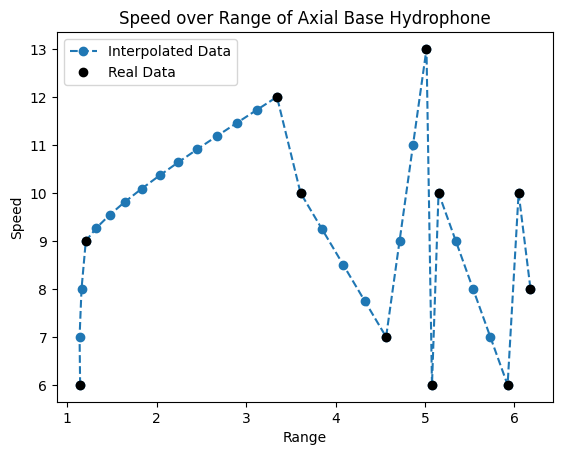

In [15]:
plt.plot(AB_interpolated['distance(in km)'], AB_interpolated['SPEED (KNOTSx10)'], 'o--', label='Interpolated Data')
plt.plot(AB_interpolated.dropna()['distance(in km)'], AB_interpolated.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
plt.legend()
plt.xlabel('Range')
plt.ylabel('Speed')
plt.title('Speed over Range of Axial Base Hydrophone')

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


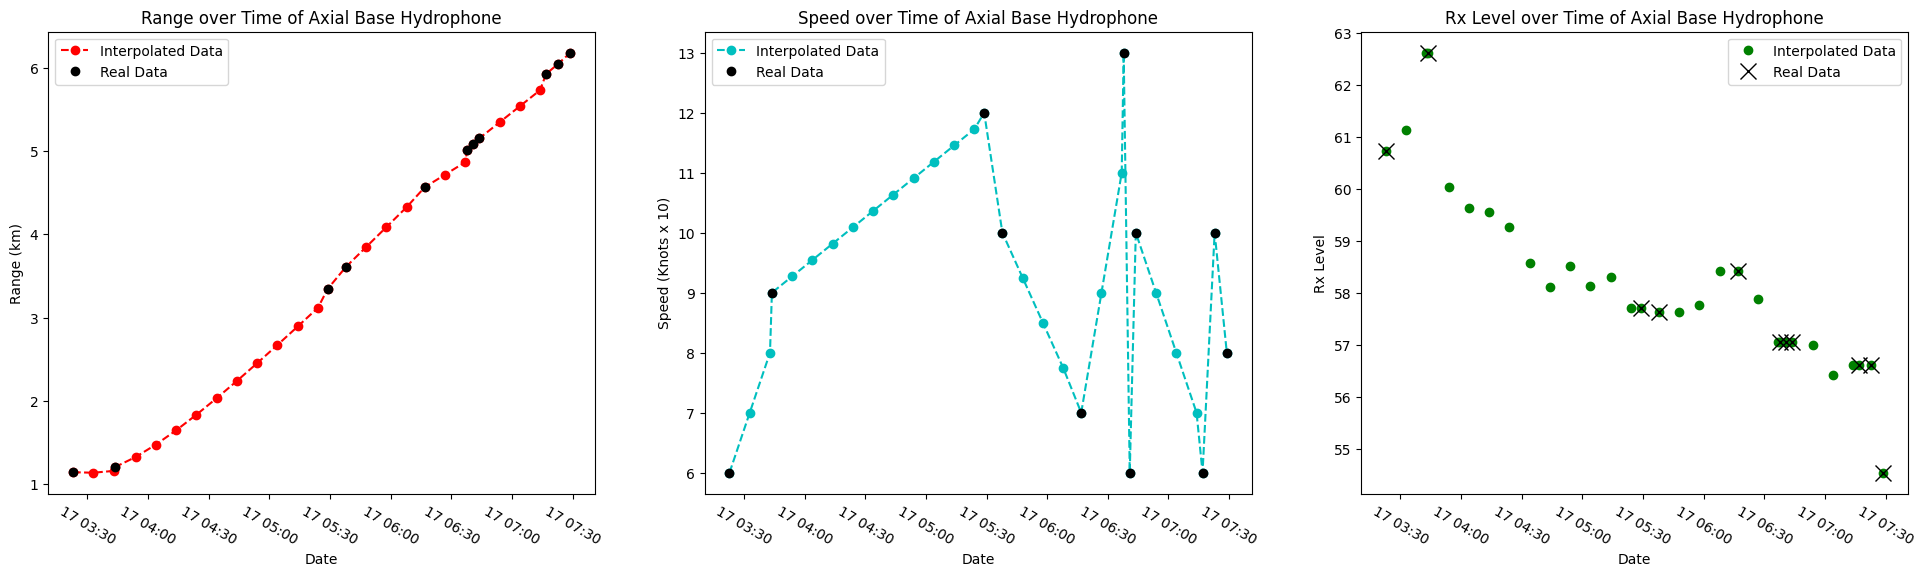

In [16]:
location = 'Axial Base'
AB_data = AB_interpolated
fig, ax = plt.subplots(1, 3, figsize=(24,6))

R_real, Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
R, Rx_level = Rx_level_from_df(AB_data, 'AIS')
S_real, Rx_level_real_S = Rx_level_from_df_SPEED(AB_data.dropna().reset_index(drop=True), 'AIS')
S, Rx_level_S = Rx_level_from_df_SPEED(AB_data, 'AIS')

ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'ro--', label='Interpolated Data')
ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='Real Data')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Range (km)')
ax[0].set_title('Range over Time of ' + location+ ' Hydrophone')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()


ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'co--', label='Interpolated Data')
ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='Real Data')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time of ' + location+ ' Hydrophone')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()


# DOUBLE CHECK THIS
# Rx level is calculated to correspond to range (close to far)
# I attempted a fix by sorting df by range and getting corresponding timestamp
ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], Rx_level, 'go', label='Interpolated Data')
ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], Rx_level_real, 'kx', label='Real Data', markersize=12)
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time of ' + location+ ' Hydrophone')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

Files not found: 0


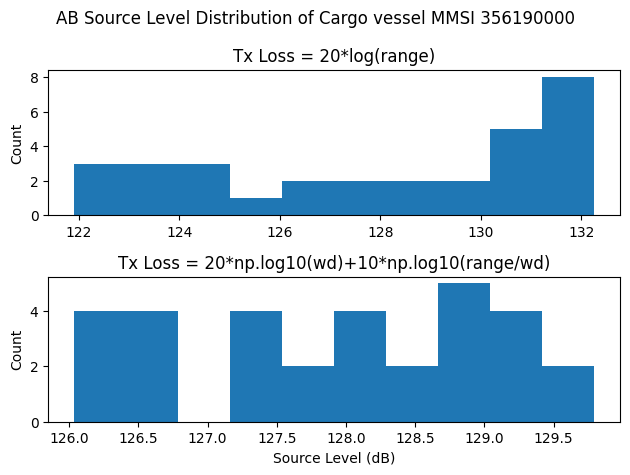

In [16]:
R, Rx_level = Rx_level_from_df(AB_interpolated, 'AIS')

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('AB Source Level Distribution of Cargo vessel MMSI ' + str(MMSI))
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'AB'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

#### Spectrogram

c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning:

nperseg = 4096 is greater than input length  = 200, using nperseg = 200

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning:

The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'



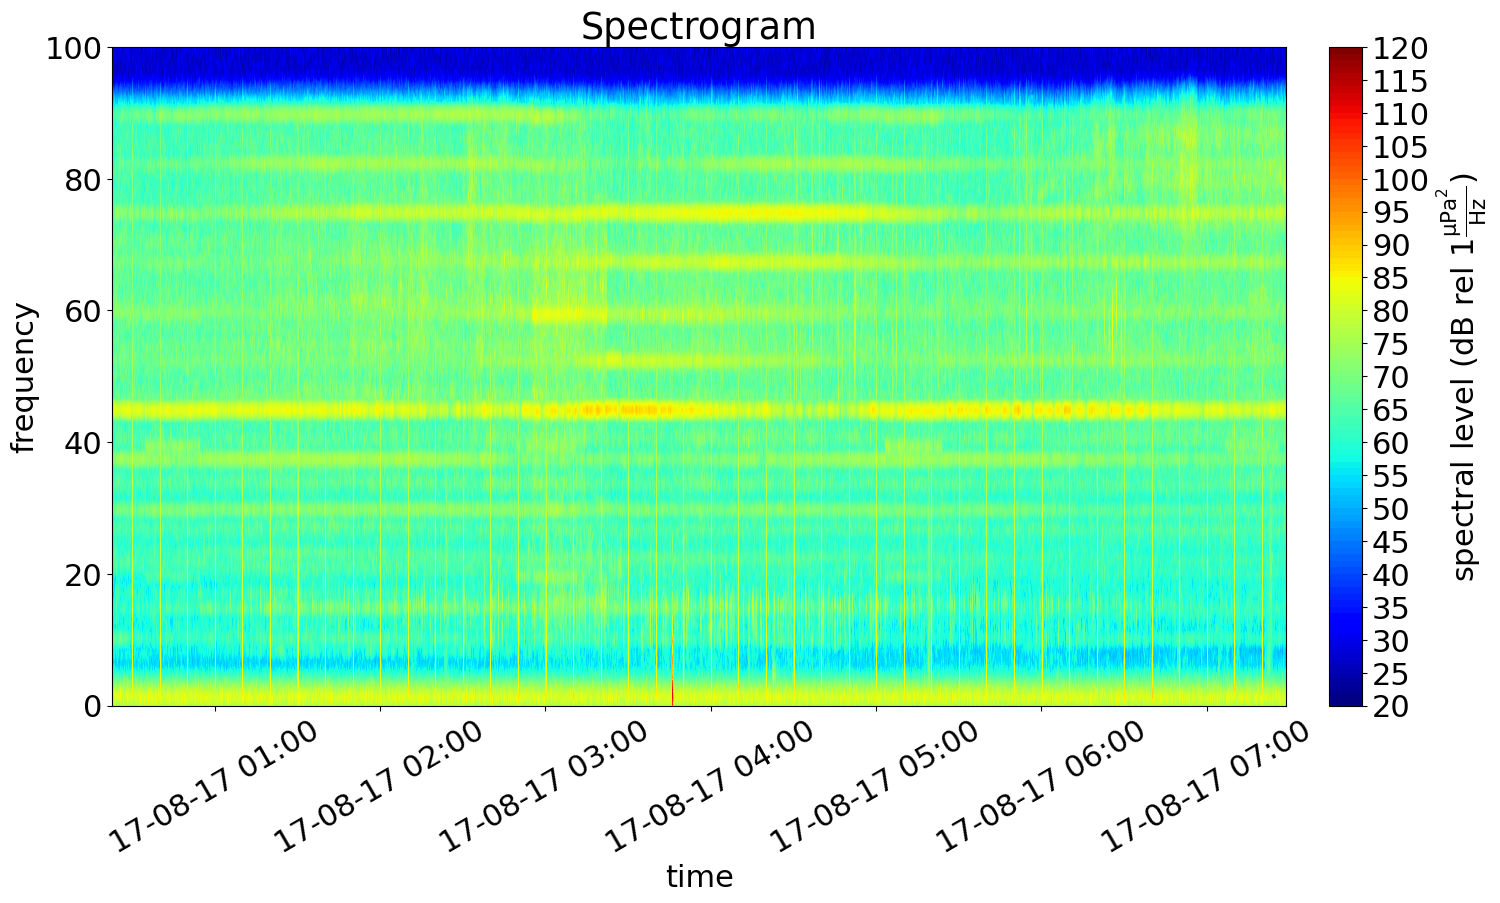

In [106]:
start_time = AB_interpolated['TIMESTAMP UTC'].iloc[0] - datetime.timedelta(hours=3)
end_time = AB_interpolated['TIMESTAMP UTC'].iloc[-1]
hdata_AB = ooipy.get_acoustic_data_LF(start_time, end_time, 'Axial_Base', verbose=True, zero_mean=True)
AB_spec_LF = hdata_AB.compute_spectrogram(avg_time=1, overlap=0,average_type="mean")

ooipy.plot(AB_spec_LF, fmin=0, fmax=100, vmax=120, xlabel_rot=30)

In [104]:
start_time = AB_interpolated['TIMESTAMP UTC'].iloc[0] - datetime.timedelta(hours=3)
end_time = AB_interpolated['TIMESTAMP UTC'].iloc[-1]
print(start_time)
print(end_time)

2017-08-17 03:22:52
2017-08-17 07:28:52


In [105]:
start_time = EC_interpolated['TIMESTAMP UTC'].iloc[0] #- datetime.timedelta(hours=3)
end_time = EC_interpolated['TIMESTAMP UTC'].iloc[-1]
print(start_time)
print(end_time)

2017-07-27 05:37:24
2017-07-27 10:40:21


### Combined Location Plots

#### Range, Speed, Rx vs. Time

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


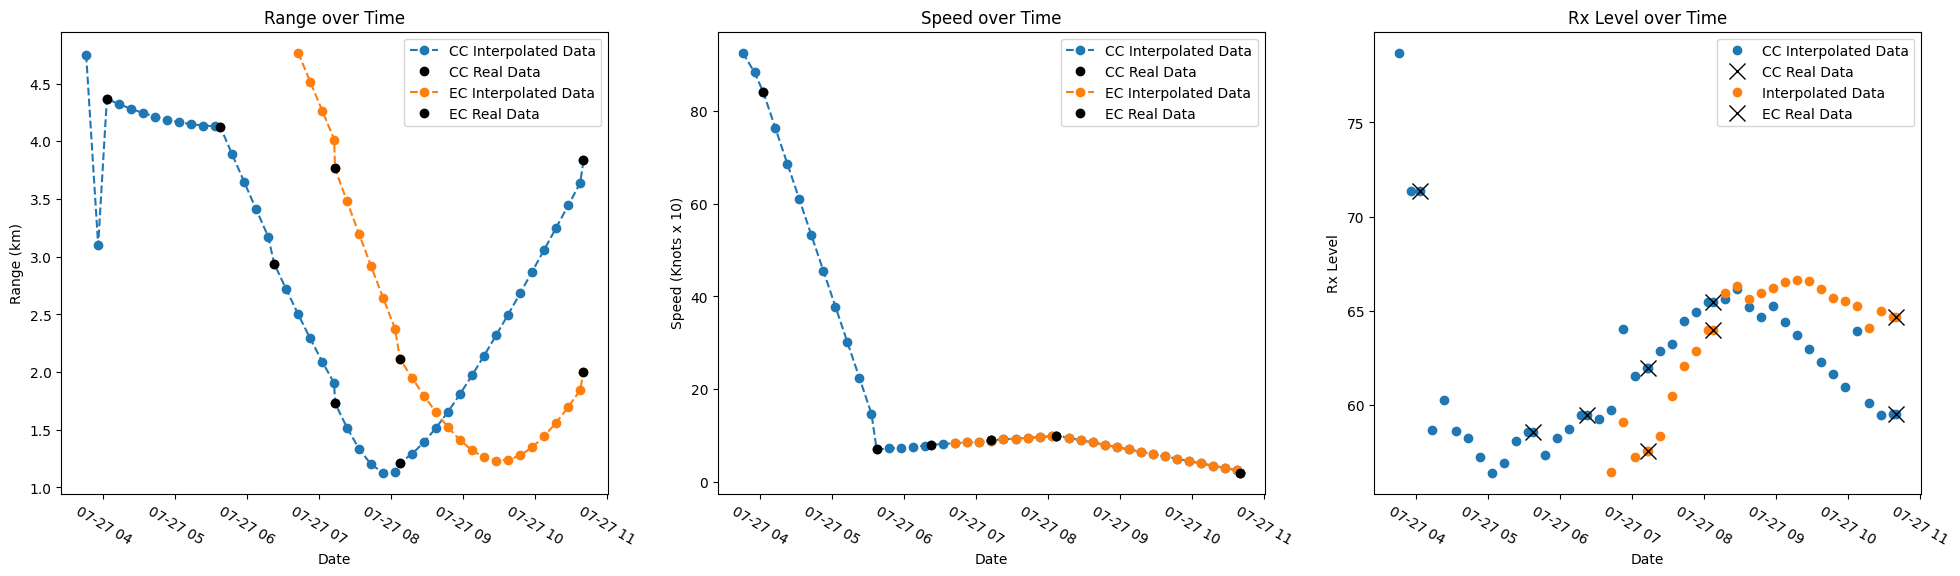

In [87]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

#ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')
ax[0].plot(CC_data['TIMESTAMP UTC'], CC_data['distance(in km)'], 'o--', label='CC Interpolated Data')
#ax[0].plot(CC_data['distance(in km)'], CC_data['TIMESTAMP UTC'], 'o--', label='CC Interpolated Data')
ax[0].plot(CC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], CC_data.dropna()['distance(in km)'], 'ko', label='CC Real Data')
#ax[0].plot(CC_data.dropna().reset_index(drop=True)['distance(in km)'], CC_data.dropna()['TIMESTAMP UTC'], 'ko', label='CC Real Data')
ax[0].plot(EC_data['TIMESTAMP UTC'], EC_data['distance(in km)'], 'o--', label='EC Interpolated Data')
#ax[0].plot(EC_data['distance(in km)'], EC_data['TIMESTAMP UTC'], 'o--', label='EC Interpolated Data')
ax[0].plot(EC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], EC_data.dropna()['distance(in km)'], 'ko', label='EC Real Data')
#ax[0].plot(EC_data.dropna().reset_index(drop=True)['distance(in km)'], EC_data.dropna()['TIMESTAMP UTC'], 'ko', label='EC Real Data')


#ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'o--', label='AB Interpolated Data')
#ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')
ax[1].plot(CC_data['TIMESTAMP UTC'], CC_data['SPEED (KNOTSx10)'], 'o--', label='CC Interpolated Data')
ax[1].plot(CC_data.dropna()['TIMESTAMP UTC'], CC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='CC Real Data')
ax[1].plot(EC_data['TIMESTAMP UTC'], EC_data['SPEED (KNOTSx10)'], 'o--', label='EC Interpolated Data')
ax[1].plot(EC_data.dropna()['TIMESTAMP UTC'], EC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='EC Real Data')

#ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'o', label='AB Interpolated Data')
#ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)
ax[2].plot(CC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], CC_Rx_level, 'o', label='CC Interpolated Data')
ax[2].plot(CC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], CC_Rx_level_real, 'kx', label='CC Real Data', markersize=12)
ax[2].plot(EC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], EC_Rx_level, 'o', label='Interpolated Data')
ax[2].plot(EC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], EC_Rx_level_real, 'kx', label='EC Real Data', markersize=12)



ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


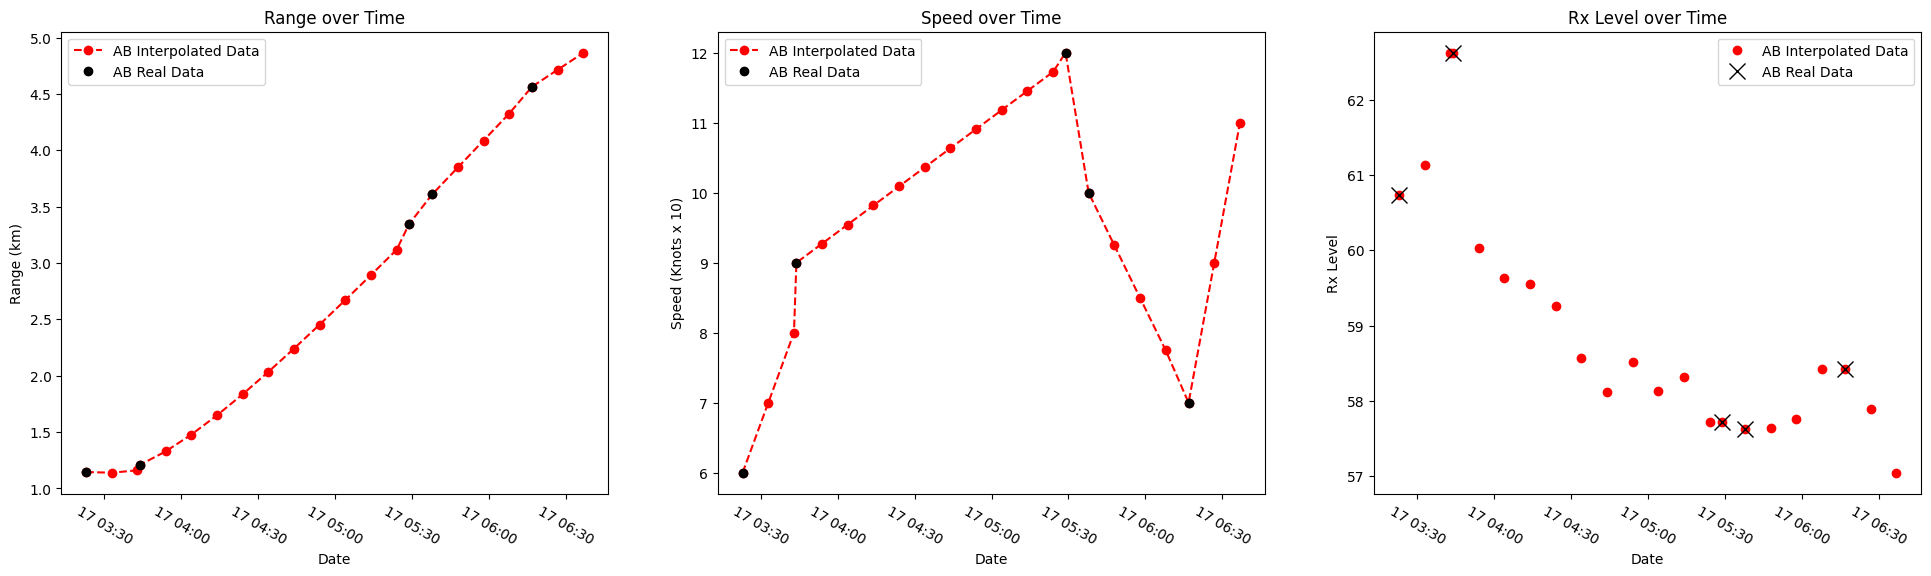

In [14]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'ro--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')

ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'ro--', label='AB Interpolated Data')
ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')

ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'ro', label='AB Interpolated Data')
ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)

ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

#### Rx vs. Range

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


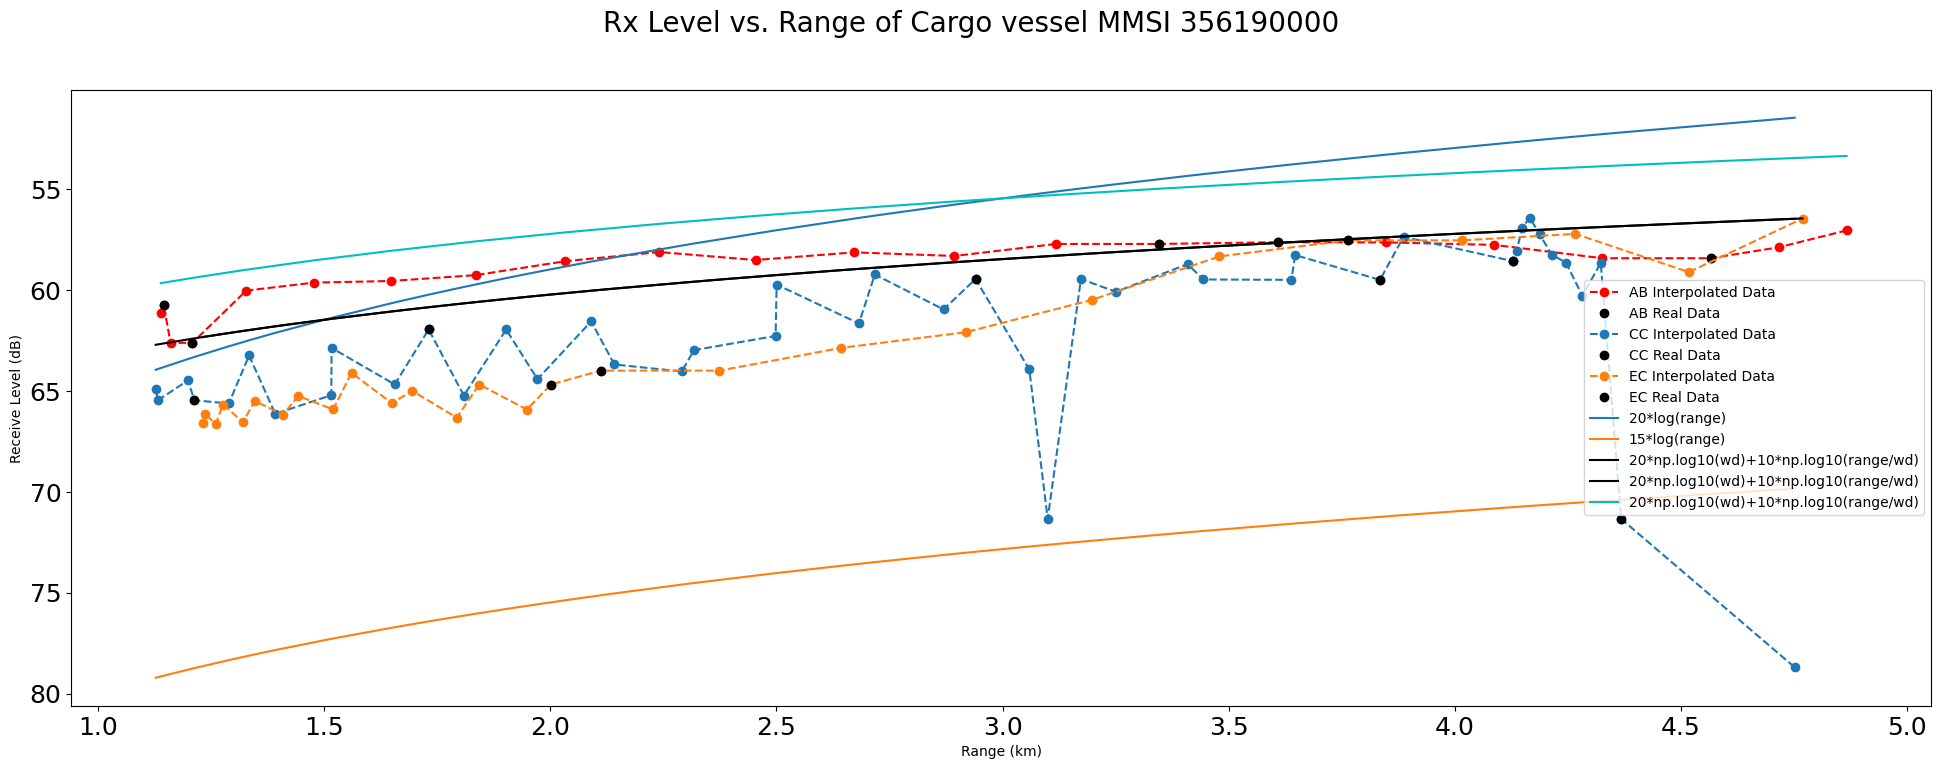

In [103]:
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')
AB_TRUE_R, AB_TRUE_Rx_level = Rx_level_from_df(AB_data.dropna(), 'AIS')
CC_TRUE_R, CC_TRUE_Rx_level = Rx_level_from_df(CC_data.dropna(), 'AIS')
EC_TRUE_R, EC_TRUE_Rx_level = Rx_level_from_df(EC_data.dropna(), 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(AB_R, AB_Rx_level, 'ro--', label='AB Interpolated Data')
ax.plot(AB_TRUE_R, AB_TRUE_Rx_level, 'ko', label='AB Real Data')

ax.plot(CC_R, CC_Rx_level, 'o--', color='tab:blue', label='CC Interpolated Data')
ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')

ax.plot(EC_R, EC_Rx_level, 'o--', color='tab:orange', label='EC Interpolated Data')
ax.plot(EC_TRUE_R, EC_TRUE_Rx_level, 'ko', label='EC Real Data')

ax.plot(CC_R, -1*Tx_loss1(np.asarray(CC_R))+125, label='20*log(range)')
ax.plot(CC_R, -1*Tx_loss3(np.asarray(CC_R))+125, label='15*log(range)')

ax.plot(CC_R, -1*Tx_loss2(np.asarray(CC_R), 'CC')+125, 'k', label='20*np.log10(wd)+10*np.log10(range/wd)') #120
ax.plot(EC_R, -1*Tx_loss2(np.asarray(EC_R), 'EC')+125, 'k', label='20*np.log10(wd)+10*np.log10(range/wd)') #120
ax.plot(AB_R, -1*Tx_loss2(np.asarray(AB_R), 'AB')+125, 'c', label='20*np.log10(wd)+10*np.log10(range/wd)') #120

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

#### Rx vs. Speed

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


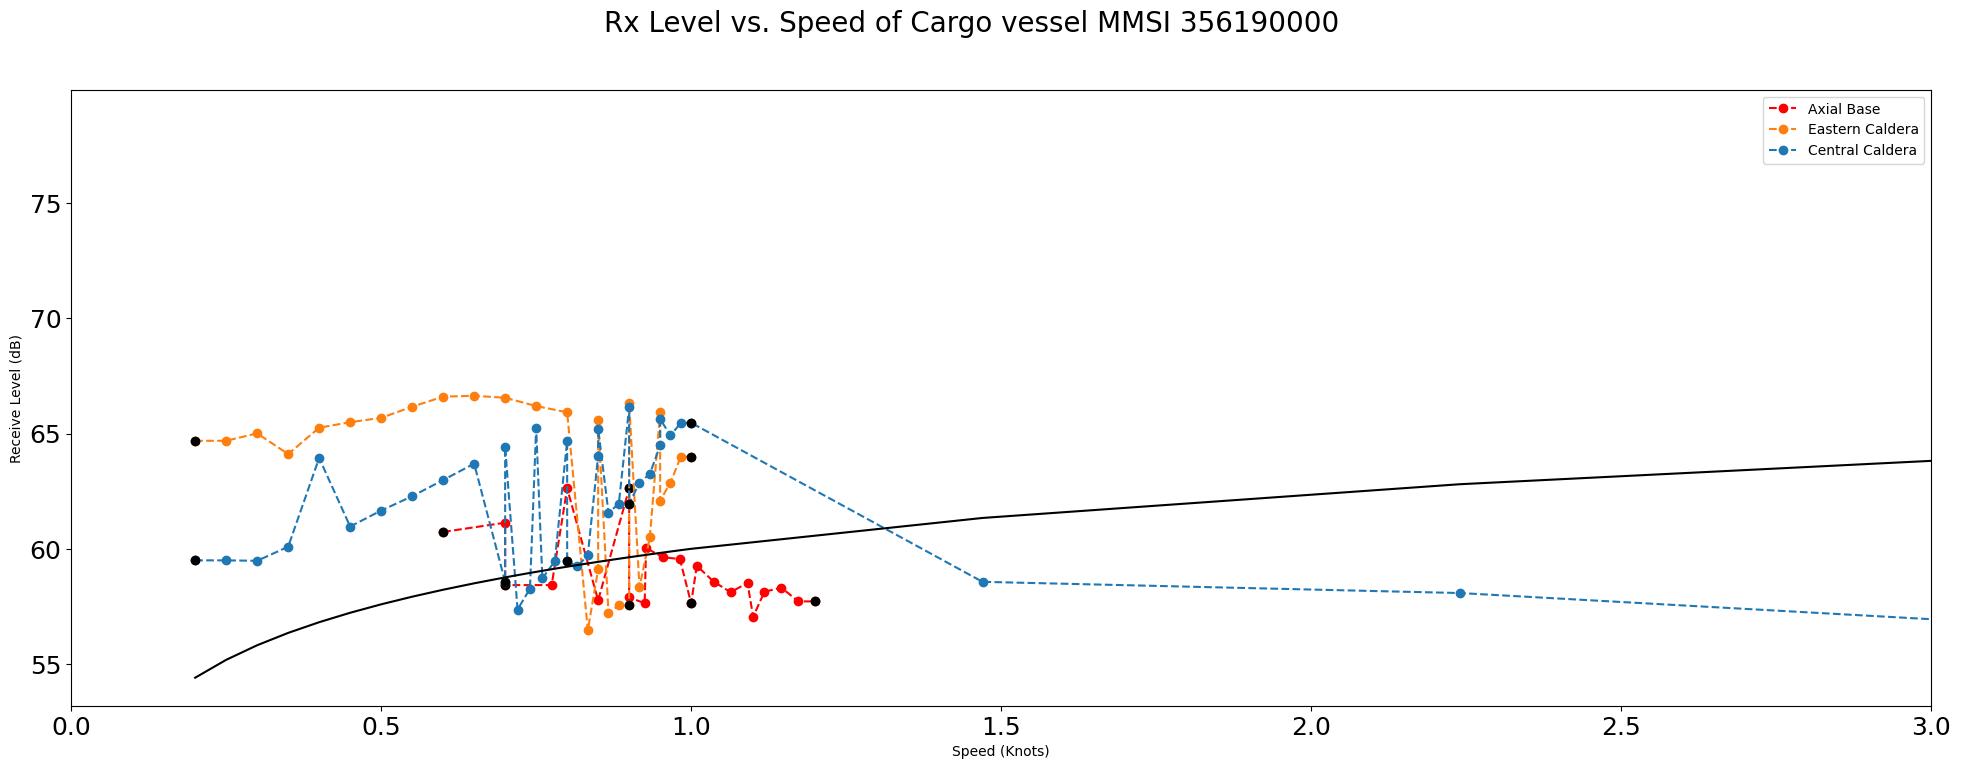

In [125]:
AB_S, AB_Rx_level = Rx_level_from_df_SPEED(AB_data, 'AIS')
AB_S_real, AB_Rx_level_real = Rx_level_from_df_SPEED(AB_data.dropna(), 'AIS')
EC_S, EC_Rx_level = Rx_level_from_df_SPEED(EC_data, 'AIS')
EC_S_real, EC_Rx_level_real = Rx_level_from_df_SPEED(EC_data.dropna(), 'AIS')
CC_S, CC_Rx_level = Rx_level_from_df_SPEED(CC_data, 'AIS')
CC_S_real, CC_Rx_level_real = Rx_level_from_df_SPEED(CC_data.dropna(), 'AIS')

fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(np.asarray(AB_S)/10, AB_Rx_level, 'ro--', label='Axial Base')
ax.plot(np.asarray(AB_S_real)/10, AB_Rx_level_real, 'ko')
ax.plot(np.asarray(EC_S)/10, EC_Rx_level, 'o--', color='tab:orange', label='Eastern Caldera')
ax.plot(np.asarray(EC_S_real)/10, EC_Rx_level_real, 'ko')
ax.plot(np.asarray(CC_S)/10, CC_Rx_level, 'o--', color='tab:blue', label='Central Caldera')
ax.plot(np.asarray(CC_S_real)/10, CC_Rx_level_real, 'ko')
ax.plot(np.asarray(CC_S)/10, 8*np.log10(np.asarray(CC_S)/10)+60, 'k')

plt.legend()
plt.xlabel('Speed (Knots)')
plt.ylabel("Receive Level (dB)")
plt.xlim(0,3)
plt.tick_params(axis='both', which='major', labelsize=18)

#### Source vs. Speed

Text(0.5, 1.0, 'MMSI 356190000 Source Level corresponding to Speed at different locations')

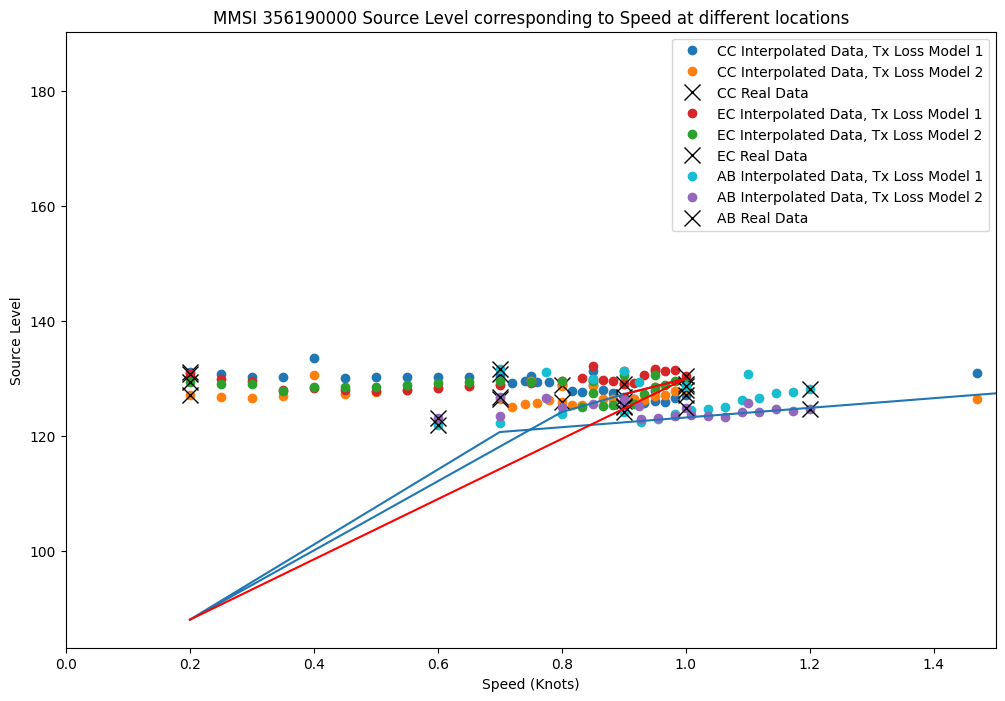

In [111]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level2, 'kx', markersize=12)

plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, 60*np.log10(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10)+130)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, 60*np.log10(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10)+130, 'r')

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Speed (Knots)')
plt.legend()
plt.xlim(0,1.5)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Speed at different locations')

#### Source vs. Range

Text(0.5, 1.0, 'MMSI 356190000 Source Level corresponding to Range at different locations')

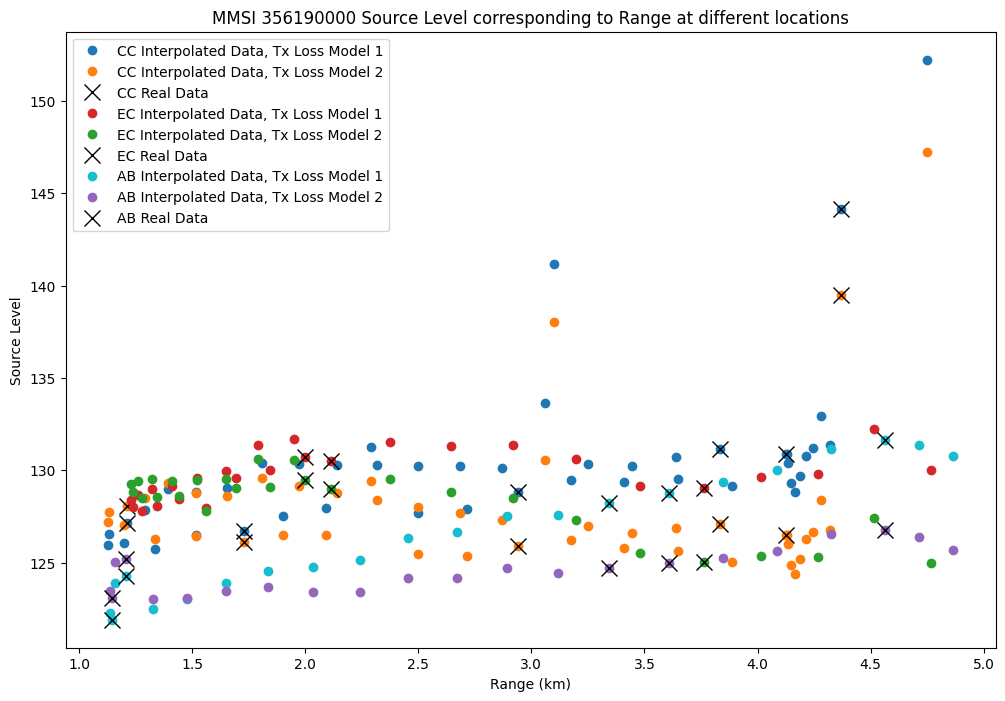

In [56]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level2, 'kx', markersize=12)

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Range (km)')
plt.legend()
#plt.xlim(0,2)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Range at different locations')

# MMSI 352358000 AIS Data
Shifting focus to only one MMSI in the Axial Seamount area (contains AB, EC, CC hphones). Instances found in 2016 and 2017.


### AIS Data setup/exploration

In [57]:
ais2016a = pd.read_csv('data/AIS/2016A - Updated.csv', delimiter=',')
ais2016b = pd.read_csv('data/AIS/2016B - Updated.csv', delimiter=',')
ais2017a = pd.read_csv('data/AIS/2017A - Updated.csv', delimiter=',')
ais2017b = pd.read_csv('data/AIS/2017B - Updated.csv', delimiter=',')
MMSI = 352358000
spectrogram_times = {
    'EC' : ['2016-08-20 09:22:31', '2016-08-20 10:21:17'],
    'CC' : ['2016-08-20 09:07:51', '2016-08-20 09:39:11'],
    'AB' : ['2016-08-20 14:17:31', '2016-08-20 15:36:41']
}
ais = pd.concat([ais2016a, ais2016b, ais2017a, ais2017b], axis=0)
ais = ais[ais['MMSI'] == MMSI]#.reset_index(drop=True)
ais

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
17138  352358000  ANNA G.  Bulk Carrier       2                25  46.78971   
17143  352358000  ANNA G.  Bulk Carrier       2                25  46.76929   
17144  352358000  ANNA G.  Bulk Carrier       2                24  46.76338   
17145  352358000  ANNA G.  Bulk Carrier       2                24  46.75733   
17146  352358000  ANNA G.  Bulk Carrier       2                28  46.75405   
...          ...      ...           ...     ...               ...       ...   
20882  352358000  ANNA G.  Bulk Carrier       0               116  45.12560   
20892  352358000  ANNA G.  Bulk Carrier       0               116  44.97915   
20896  352358000  ANNA G.  Bulk Carrier       0               118  44.95952   
20899  352358000  ANNA G.  Bulk Carrier       0               119  44.94682   
20903  352358000  ANNA G.  Bulk Carrier       0               119  44.92191   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
17138 -131.1090     136       76  2016-08-19 05:43:57   229.0  
17143 -131.0810     136       82  2016-08-19 06:24:50   229.0  
17144 -131.0726     136       80  2016-08-19 06:37:13   229.0  
17145 -131.0626     136       75  2016-08-19 06:50:51   229.0  
17146 -131.0576     132       78  2016-08-19 06:57:55   229.0  
...         ...     ...      ...                  ...     ...  
20882 -129.2206     181      180  2016-08-27 13:44:13   229.0  
20892 -129.2268     181      183  2016-08-27 14:30:41   229.0  
20896 -129.2279     182      183  2016-08-27 14:36:41   229.0  
20899 -129.2286     181      185  2016-08-27 14:40:33   229.0  
20903 -129.2305     185      183  2016-08-27 14:48:02   229.0  

[237 rows x 11 columns]

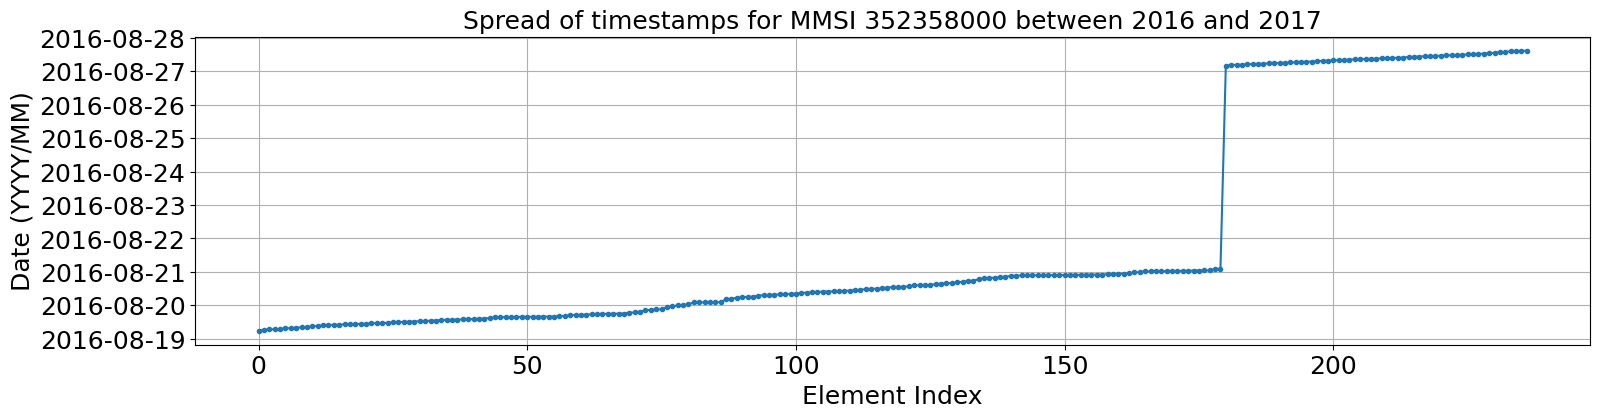

In [6]:
plt.subplots(figsize=(18,4))
plt.plot(pd.to_datetime(ais['TIMESTAMP UTC'].reset_index(drop=True)), marker='.')
plt.xlabel('Element Index', fontsize=18)
plt.ylabel('Date (YYYY/MM)', fontsize=18)
plt.title('Spread of timestamps for MMSI '+str(MMSI) + ' between 2016 and 2017', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

### EC Timeframe

In [58]:
EC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['EC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['EC'][1]) + datetime.timedelta(hours=3))]
EC_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
17427  352358000  ANNA G.  Bulk Carrier       2                23  46.04846   
17429  352358000  ANNA G.  Bulk Carrier       2                23  46.04565   
17431  352358000  ANNA G.  Bulk Carrier       2                23  46.03490   
17432  352358000  ANNA G.  Bulk Carrier       2                25  46.03209   
17434  352358000  ANNA G.  Bulk Carrier       2                25  46.02589   
17436  352358000  ANNA G.  Bulk Carrier       2                23  46.02175   
17437  352358000  ANNA G.  Bulk Carrier       2                24  46.01474   
17440  352358000  ANNA G.  Bulk Carrier       2                24  46.00991   
17442  352358000  ANNA G.  Bulk Carrier       2                27  45.99985   
17444  352358000  ANNA G.  Bulk Carrier       2                30  45.98920   
17446  352358000  ANNA G.  Bulk Carrier       2                29  45.98166   
17449  352358000  ANNA G.  Bulk Carrier       2                24  45.97189   
17450  352358000  ANNA G.  Bulk Carrier       2                26  45.96774   
17452  352358000  ANNA G.  Bulk Carrier       2                26  45.96512   
17453  352358000  ANNA G.  Bulk Carrier       2                33  45.96192   
17455  352358000  ANNA G.  Bulk Carrier       2                26  45.95783   
17457  352358000  ANNA G.  Bulk Carrier       2                25  45.94885   
17459  352358000  ANNA G.  Bulk Carrier       2                19  45.94382   
17461  352358000  ANNA G.  Bulk Carrier       2                26  45.93346   
17465  352358000  ANNA G.  Bulk Carrier       2                24  45.92620   
17470  352358000  ANNA G.  Bulk Carrier       2                26  45.91368   
17473  352358000  ANNA G.  Bulk Carrier       2                25  45.90771   
17475  352358000  ANNA G.  Bulk Carrier       2                22  45.90283   
17476  352358000  ANNA G.  Bulk Carrier       2                24  45.89888   
17481  352358000  ANNA G.  Bulk Carrier       2                24  45.88079   
17484  352358000  ANNA G.  Bulk Carrier       2                26  45.87463   
17486  352358000  ANNA G.  Bulk Carrier       2                29  45.87125   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
17427 -130.0791     134       81  2016-08-20 07:00:55   229.0  
17429 -130.0744     133       80  2016-08-20 07:07:36   229.0  
17431 -130.0590     134       79  2016-08-20 07:30:18   229.0  
17432 -130.0549     135       77  2016-08-20 07:35:58   229.0  
17434 -130.0453     132       75  2016-08-20 07:49:19   229.0  
17436 -130.0385     131       79  2016-08-20 07:58:43   229.0  
17437 -130.0272     132       74  2016-08-20 08:13:26   229.0  
17440 -130.0186     126       79  2016-08-20 08:24:11   229.0  
17442 -130.0013     131       80  2016-08-20 08:45:43   229.0  
17444 -129.9839     140       77  2016-08-20 09:07:51   229.0  
17446 -129.9726     140       81  2016-08-20 09:22:31   229.0  
17449 -129.9605     137       77  2016-08-20 09:39:11   229.0  
17450 -129.9544     134       81  2016-08-20 09:47:19   229.0  
17452 -129.9506     134       84  2016-08-20 09:52:06   229.0  
17453 -129.9460     141       84  2016-08-20 09:57:47   229.0  
17455 -129.9405     134       82  2016-08-20 10:04:57   229.0  
17457 -129.9292     139       80  2016-08-20 10:21:17   229.0  
17459 -129.9226     137       81  2016-08-20 10:31:49   229.0  
17461 -129.9089     140       87  2016-08-20 10:53:19   229.0  
17465 -129.8988     135       81  2016-08-20 11:09:04   229.0  
17470 -129.8807     141       86  2016-08-20 11:35:03   229.0  
17473 -129.8730     139       86  2016-08-20 11:47:27   229.0  
17475 -129.8673     137       82  2016-08-20 11:57:03   229.0  
17476 -129.8620     140       81  2016-08-20 12:05:31   229.0  
17481 -129.8345     127       82  2016-08-20 12:45:40   229.0  
17484 -129.8249     139       82  2016-08-20 12:58:51   229.0  
17486 -129.8201     141       84  2016-08-20 13:06:01   229.0

In [59]:
EC_interpolated = ten_min_interp(split_10m(EC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
EC_interpolated['instance_id'] = 'EC_' + EC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + EC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
EC_interpolated['distance(in km)'] = EC_interpolated['ecdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a 

#### Downloading node timeframe specific files

In [9]:
DL_Mseed_for_time_filtered_file(EC_interpolated, EC_interpolated.iloc[0]['TIMESTAMP UTC'], EC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='EC')

OO.AXEC2.AXEC2.HDH | 2016-08-20T07:00:55.000000Z - 2016-08-20T07:10:55.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820070055_20160820071055.mseed
OO.AXEC2.AXEC2.HDH | 2016-08-20T07:17:37.000000Z - 2016-08-20T07:27:37.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820071737_20160820072737.mseed
OO.AXEC2.AXEC2.HDH | 2016-08-20T07:27:38.000000Z - 2016-08-20T07:37:38.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820072738_20160820073738.mseed
OO.AXEC2.AXEC2.HDH | 2016-08-20T07:45:59.000000Z - 2016-08-20T07:55:59.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820074559_20160820075559.mseed
OO.AXEC2.AXEC2.HDH | 2016-08-20T07:58:43.000000Z - 2016-08-20T08:08:43.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820075843_20160820080843.mseed
OO.AXEC2.AXEC2.HDH | 2016-08-20T08:08:44.000000Z - 2016-08-20T08:18:44.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20160820080844_20160820081844.msee

#### EC Plotting

### CC Timeframe

In [60]:
CC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['CC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['CC'][1]) + datetime.timedelta(hours=3))]
CC_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
17422  352358000  ANNA G.  Bulk Carrier       2                23  46.07245   
17427  352358000  ANNA G.  Bulk Carrier       2                23  46.04846   
17429  352358000  ANNA G.  Bulk Carrier       2                23  46.04565   
17431  352358000  ANNA G.  Bulk Carrier       2                23  46.03490   
17432  352358000  ANNA G.  Bulk Carrier       2                25  46.03209   
17434  352358000  ANNA G.  Bulk Carrier       2                25  46.02589   
17436  352358000  ANNA G.  Bulk Carrier       2                23  46.02175   
17437  352358000  ANNA G.  Bulk Carrier       2                24  46.01474   
17440  352358000  ANNA G.  Bulk Carrier       2                24  46.00991   
17442  352358000  ANNA G.  Bulk Carrier       2                27  45.99985   
17444  352358000  ANNA G.  Bulk Carrier       2                30  45.98920   
17446  352358000  ANNA G.  Bulk Carrier       2                29  45.98166   
17449  352358000  ANNA G.  Bulk Carrier       2                24  45.97189   
17450  352358000  ANNA G.  Bulk Carrier       2                26  45.96774   
17452  352358000  ANNA G.  Bulk Carrier       2                26  45.96512   
17453  352358000  ANNA G.  Bulk Carrier       2                33  45.96192   
17455  352358000  ANNA G.  Bulk Carrier       2                26  45.95783   
17457  352358000  ANNA G.  Bulk Carrier       2                25  45.94885   
17459  352358000  ANNA G.  Bulk Carrier       2                19  45.94382   
17461  352358000  ANNA G.  Bulk Carrier       2                26  45.93346   
17465  352358000  ANNA G.  Bulk Carrier       2                24  45.92620   
17470  352358000  ANNA G.  Bulk Carrier       2                26  45.91368   
17473  352358000  ANNA G.  Bulk Carrier       2                25  45.90771   
17475  352358000  ANNA G.  Bulk Carrier       2                22  45.90283   
17476  352358000  ANNA G.  Bulk Carrier       2                24  45.89888   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
17422 -130.1145     131       81  2016-08-20 06:09:03   229.0  
17427 -130.0791     134       81  2016-08-20 07:00:55   229.0  
17429 -130.0744     133       80  2016-08-20 07:07:36   229.0  
17431 -130.0590     134       79  2016-08-20 07:30:18   229.0  
17432 -130.0549     135       77  2016-08-20 07:35:58   229.0  
17434 -130.0453     132       75  2016-08-20 07:49:19   229.0  
17436 -130.0385     131       79  2016-08-20 07:58:43   229.0  
17437 -130.0272     132       74  2016-08-20 08:13:26   229.0  
17440 -130.0186     126       79  2016-08-20 08:24:11   229.0  
17442 -130.0013     131       80  2016-08-20 08:45:43   229.0  
17444 -129.9839     140       77  2016-08-20 09:07:51   229.0  
17446 -129.9726     140       81  2016-08-20 09:22:31   229.0  
17449 -129.9605     137       77  2016-08-20 09:39:11   229.0  
17450 -129.9544     134       81  2016-08-20 09:47:19   229.0  
17452 -129.9506     134       84  2016-08-20 09:52:06   229.0  
17453 -129.9460     141       84  2016-08-20 09:57:47   229.0  
17455 -129.9405     134       82  2016-08-20 10:04:57   229.0  
17457 -129.9292     139       80  2016-08-20 10:21:17   229.0  
17459 -129.9226     137       81  2016-08-20 10:31:49   229.0  
17461 -129.9089     140       87  2016-08-20 10:53:19   229.0  
17465 -129.8988     135       81  2016-08-20 11:09:04   229.0  
17470 -129.8807     141       86  2016-08-20 11:35:03   229.0  
17473 -129.8730     139       86  2016-08-20 11:47:27   229.0  
17475 -129.8673     137       82  2016-08-20 11:57:03   229.0  
17476 -129.8620     140       81  2016-08-20 12:05:31   229.0

In [61]:
CC_interpolated = ten_min_interp(split_10m(CC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
CC_interpolated['instance_id'] = 'CC_' + CC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + CC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
CC_interpolated['distance(in km)'] = CC_interpolated['ccdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


#### Downloading node timeframe specific files

In [16]:
DL_Mseed_for_time_filtered_file(CC_interpolated, CC_interpolated.iloc[0]['TIMESTAMP UTC'], CC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='CC')

OO.AXCC1.AXCC1.HDH | 2016-08-20T06:09:03.000000Z - 2016-08-20T06:19:03.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820060903_20160820061903.mseed
OO.AXCC1.AXCC1.HDH | 2016-08-20T06:19:04.000000Z - 2016-08-20T06:29:04.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820061904_20160820062904.mseed
OO.AXCC1.AXCC1.HDH | 2016-08-20T06:29:05.000000Z - 2016-08-20T06:39:05.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820062905_20160820063905.mseed
OO.AXCC1.AXCC1.HDH | 2016-08-20T06:39:06.000000Z - 2016-08-20T06:49:06.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820063906_20160820064906.mseed
OO.AXCC1.AXCC1.HDH | 2016-08-20T06:49:07.000000Z - 2016-08-20T06:59:07.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820064907_20160820065907.mseed
OO.AXCC1.AXCC1.HDH | 2016-08-20T06:59:08.000000Z - 2016-08-20T07:09:08.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20160820065908_20160820070908.msee

#### CC Plotting

### AB Timeframe

In [62]:
AB_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['AB'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC'] )<= pd.to_datetime(spectrogram_times['AB'][1]) + datetime.timedelta(hours=3))]
AB_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
17470  352358000  ANNA G.  Bulk Carrier       2                26  45.91368   
17473  352358000  ANNA G.  Bulk Carrier       2                25  45.90771   
17475  352358000  ANNA G.  Bulk Carrier       2                22  45.90283   
17476  352358000  ANNA G.  Bulk Carrier       2                24  45.89888   
17481  352358000  ANNA G.  Bulk Carrier       2                24  45.88079   
17484  352358000  ANNA G.  Bulk Carrier       2                26  45.87463   
17486  352358000  ANNA G.  Bulk Carrier       2                29  45.87125   
17488  352358000  ANNA G.  Bulk Carrier       2                24  45.86354   
17490  352358000  ANNA G.  Bulk Carrier       2                23  45.85923   
17500  352358000  ANNA G.  Bulk Carrier       2                23  45.83979   
17503  352358000  ANNA G.  Bulk Carrier       2                22  45.83675   
17505  352358000  ANNA G.  Bulk Carrier       2                22  45.83339   
17507  352358000  ANNA G.  Bulk Carrier       2                22  45.82935   
17513  352358000  ANNA G.  Bulk Carrier       2                22  45.81873   
17515  352358000  ANNA G.  Bulk Carrier       2                24  45.80688   
17517  352358000  ANNA G.  Bulk Carrier       2                30  45.79841   
17521  352358000  ANNA G.  Bulk Carrier       2                25  45.79690   
17527  352358000  ANNA G.  Bulk Carrier       2                19  45.78583   
17536  352358000  ANNA G.  Bulk Carrier       2                22  45.77446   
17545  352358000  ANNA G.  Bulk Carrier       2                22  45.76118   
17554  352358000  ANNA G.  Bulk Carrier       2                21  45.75332   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
17470 -129.8807     141       86  2016-08-20 11:35:03   229.0  
17473 -129.8730     139       86  2016-08-20 11:47:27   229.0  
17475 -129.8673     137       82  2016-08-20 11:57:03   229.0  
17476 -129.8620     140       81  2016-08-20 12:05:31   229.0  
17481 -129.8345     127       82  2016-08-20 12:45:40   229.0  
17484 -129.8249     139       82  2016-08-20 12:58:51   229.0  
17486 -129.8201     141       84  2016-08-20 13:06:01   229.0  
17488 -129.8095     133       88  2016-08-20 13:21:42   229.0  
17490 -129.8030     130       83  2016-08-20 13:30:43   229.0  
17500 -129.7672     127       80  2016-08-20 14:17:31   229.0  
17503 -129.7619     128       81  2016-08-20 14:24:43   229.0  
17505 -129.7558     123       78  2016-08-20 14:33:07   229.0  
17507 -129.7479     126       80  2016-08-20 14:43:53   229.0  
17513 -129.7299     132       79  2016-08-20 15:08:58   229.0  
17515 -129.7095     127       81  2016-08-20 15:36:41   229.0  
17517 -129.6958     142       86  2016-08-20 15:54:35   229.0  
17521 -129.6936     136       85  2016-08-20 15:57:56   229.0  
17527 -129.6764     126       75  2016-08-20 16:23:32   229.0  
17536 -129.6580     132       84  2016-08-20 16:50:53   229.0  
17545 -129.6381     132       84  2016-08-20 17:22:37   229.0  
17554 -129.6249     122       83  2016-08-20 17:44:32   229.0

In [63]:
AB_interpolated = ten_min_interp(split_10m(AB_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
AB_interpolated['instance_id'] = 'AB_' + AB_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + AB_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
AB_interpolated['distance(in km)'] = AB_interpolated['abdist']*1.609344 # convert from milse to km
#AB_interpolated

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


#### Downloading node timeframe specific files

In [14]:
DL_Mseed_for_time_filtered_file(AB_interpolated, AB_interpolated.iloc[0]['TIMESTAMP UTC'], AB_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='AB')

OO.AXBA1.AXBA1.HDH | 2016-08-20T11:35:03.000000Z - 2016-08-20T11:45:03.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820113503_20160820114503.mseed
OO.AXBA1.AXBA1.HDH | 2016-08-20T11:45:04.000000Z - 2016-08-20T11:55:04.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820114504_20160820115504.mseed
OO.AXBA1.AXBA1.HDH | 2016-08-20T11:57:03.000000Z - 2016-08-20T12:07:03.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820115703_20160820120703.mseed
OO.AXBA1.AXBA1.HDH | 2016-08-20T12:15:32.000000Z - 2016-08-20T12:25:32.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820121532_20160820122532.mseed
OO.AXBA1.AXBA1.HDH | 2016-08-20T12:25:33.000000Z - 2016-08-20T12:35:33.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820122533_20160820123533.mseed
OO.AXBA1.AXBA1.HDH | 2016-08-20T12:35:34.000000Z - 2016-08-20T12:45:34.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20160820123534_20160820124534.msee

#### AB Plotting

### Combined Location Plots

##### Range, Speed, Rx vs. Time

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


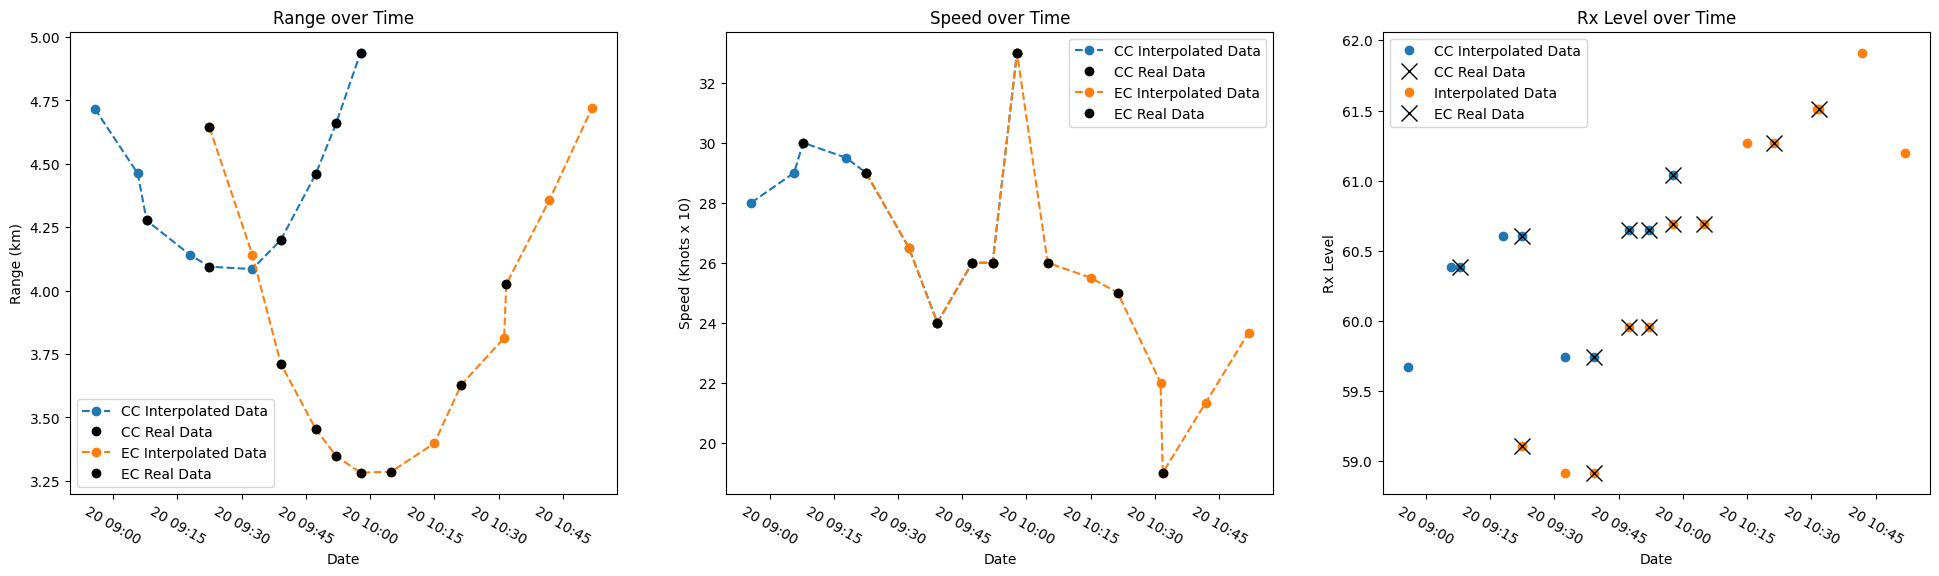

In [64]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

#ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')
ax[0].plot(CC_data['TIMESTAMP UTC'], CC_data['distance(in km)'], 'o--', label='CC Interpolated Data')
#ax[0].plot(CC_data['distance(in km)'], CC_data['TIMESTAMP UTC'], 'o--', label='CC Interpolated Data')
ax[0].plot(CC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], CC_data.dropna()['distance(in km)'], 'ko', label='CC Real Data')
#ax[0].plot(CC_data.dropna().reset_index(drop=True)['distance(in km)'], CC_data.dropna()['TIMESTAMP UTC'], 'ko', label='CC Real Data')
ax[0].plot(EC_data['TIMESTAMP UTC'], EC_data['distance(in km)'], 'o--', label='EC Interpolated Data')
#ax[0].plot(EC_data['distance(in km)'], EC_data['TIMESTAMP UTC'], 'o--', label='EC Interpolated Data')
ax[0].plot(EC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], EC_data.dropna()['distance(in km)'], 'ko', label='EC Real Data')
#ax[0].plot(EC_data.dropna().reset_index(drop=True)['distance(in km)'], EC_data.dropna()['TIMESTAMP UTC'], 'ko', label='EC Real Data')


#ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'o--', label='AB Interpolated Data')
#ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')
ax[1].plot(CC_data['TIMESTAMP UTC'], CC_data['SPEED (KNOTSx10)'], 'o--', label='CC Interpolated Data')
ax[1].plot(CC_data.dropna()['TIMESTAMP UTC'], CC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='CC Real Data')
ax[1].plot(EC_data['TIMESTAMP UTC'], EC_data['SPEED (KNOTSx10)'], 'o--', label='EC Interpolated Data')
ax[1].plot(EC_data.dropna()['TIMESTAMP UTC'], EC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='EC Real Data')

#ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'o', label='AB Interpolated Data')
#ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)
ax[2].plot(CC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], CC_Rx_level, 'o', label='CC Interpolated Data')
ax[2].plot(CC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], CC_Rx_level_real, 'kx', label='CC Real Data', markersize=12)
ax[2].plot(EC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], EC_Rx_level, 'o', label='Interpolated Data')
ax[2].plot(EC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], EC_Rx_level_real, 'kx', label='EC Real Data', markersize=12)



ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


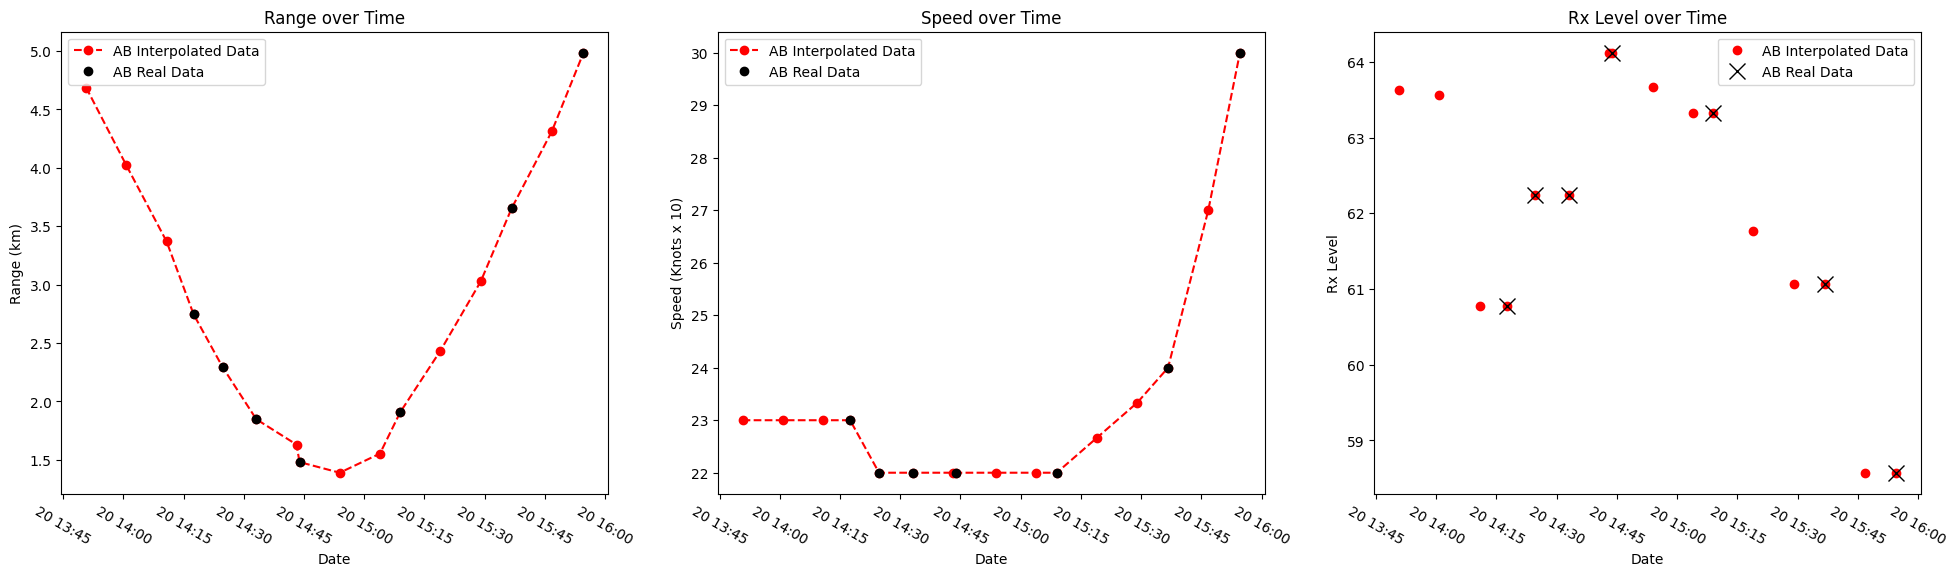

In [12]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'ro--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')

ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'ro--', label='AB Interpolated Data')
ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')

ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'ro', label='AB Interpolated Data')
ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)

ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

#### Rx vs. Range

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


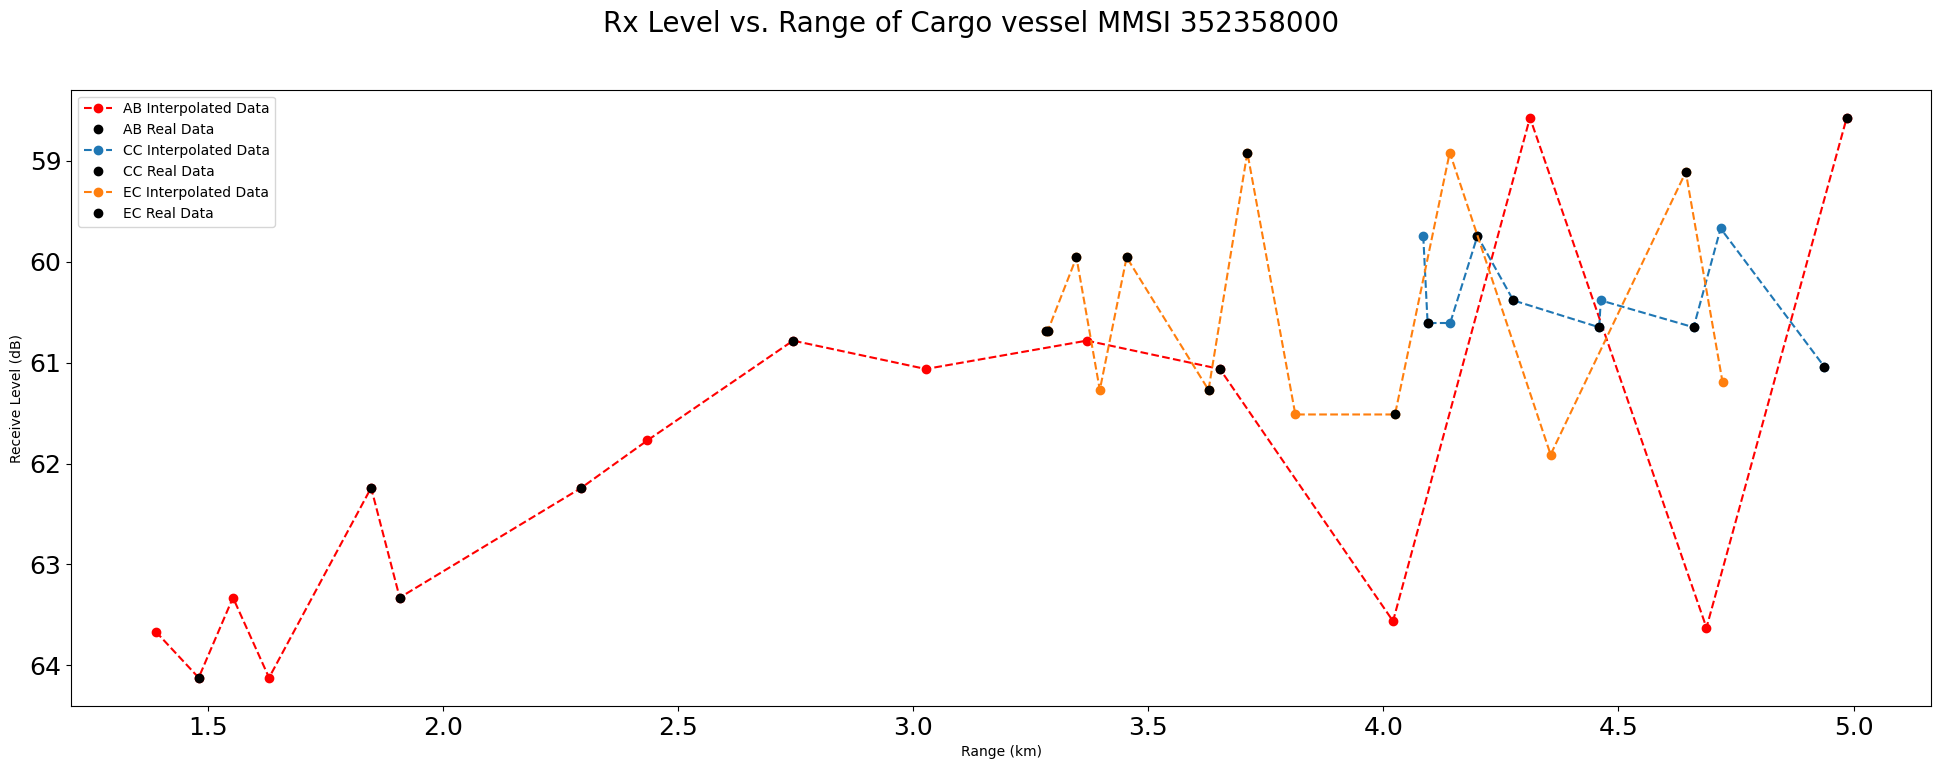

In [65]:
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')
AB_TRUE_R, AB_TRUE_Rx_level = Rx_level_from_df(AB_data.dropna(), 'AIS')
CC_TRUE_R, CC_TRUE_Rx_level = Rx_level_from_df(CC_data.dropna(), 'AIS')
EC_TRUE_R, EC_TRUE_Rx_level = Rx_level_from_df(EC_data.dropna(), 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(AB_R, AB_Rx_level, 'ro--', label='AB Interpolated Data')
ax.plot(AB_TRUE_R, AB_TRUE_Rx_level, 'ko', label='AB Real Data')

ax.plot(CC_R, CC_Rx_level, 'o--', color='tab:blue', label='CC Interpolated Data')
ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')

ax.plot(EC_R, EC_Rx_level, 'o--', color='tab:orange', label='EC Interpolated Data')
ax.plot(EC_TRUE_R, EC_TRUE_Rx_level, 'ko', label='EC Real Data')

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

#### Rx vs. Speed

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


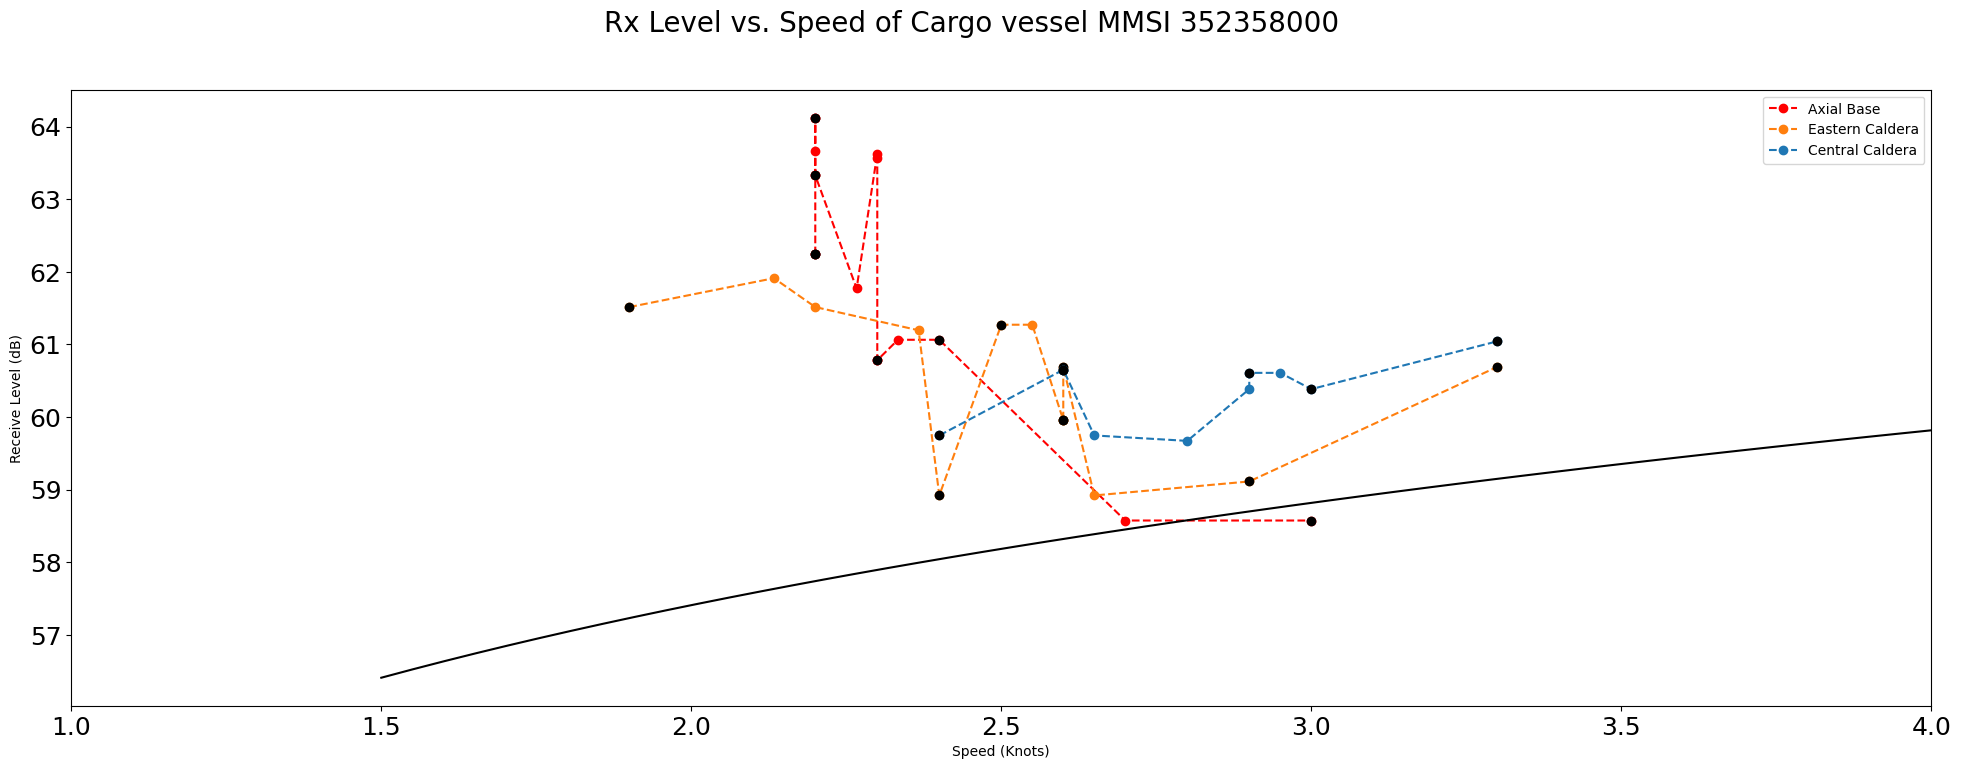

In [14]:
AB_S, AB_Rx_level = Rx_level_from_df_SPEED(AB_data, 'AIS')
AB_S_real, AB_Rx_level_real = Rx_level_from_df_SPEED(AB_data.dropna(), 'AIS')
EC_S, EC_Rx_level = Rx_level_from_df_SPEED(EC_data, 'AIS')
EC_S_real, EC_Rx_level_real = Rx_level_from_df_SPEED(EC_data.dropna(), 'AIS')
CC_S, CC_Rx_level = Rx_level_from_df_SPEED(CC_data, 'AIS')
CC_S_real, CC_Rx_level_real = Rx_level_from_df_SPEED(CC_data.dropna(), 'AIS')

fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(np.asarray(AB_S)/10, AB_Rx_level, 'ro--', label='Axial Base')
ax.plot(np.asarray(AB_S_real)/10, AB_Rx_level_real, 'ko')
ax.plot(np.asarray(EC_S)/10, EC_Rx_level, 'o--', color='tab:orange', label='Eastern Caldera')
ax.plot(np.asarray(EC_S_real)/10, EC_Rx_level_real, 'ko')
ax.plot(np.asarray(CC_S)/10, CC_Rx_level, 'o--', color='tab:blue', label='Central Caldera')
ax.plot(np.asarray(CC_S_real)/10, CC_Rx_level_real, 'ko')
#ax.plot(np.asarray(CC_S)/10, 8*np.log10(np.asarray(CC_S)/10)+60)

x = np.linspace(1.5, 4, 50)
ax.plot(x, 8*np.log10(x)+55, 'k')

plt.legend()
plt.xlabel('Speed (Knots)')
plt.ylabel("Receive Level (dB)")
plt.xlim(1,4)
plt.tick_params(axis='both', which='major', labelsize=18)

#### Source vs. Speed

Text(0.5, 1.0, 'MMSI 352358000 Source Level corresponding to Speed at different locations')

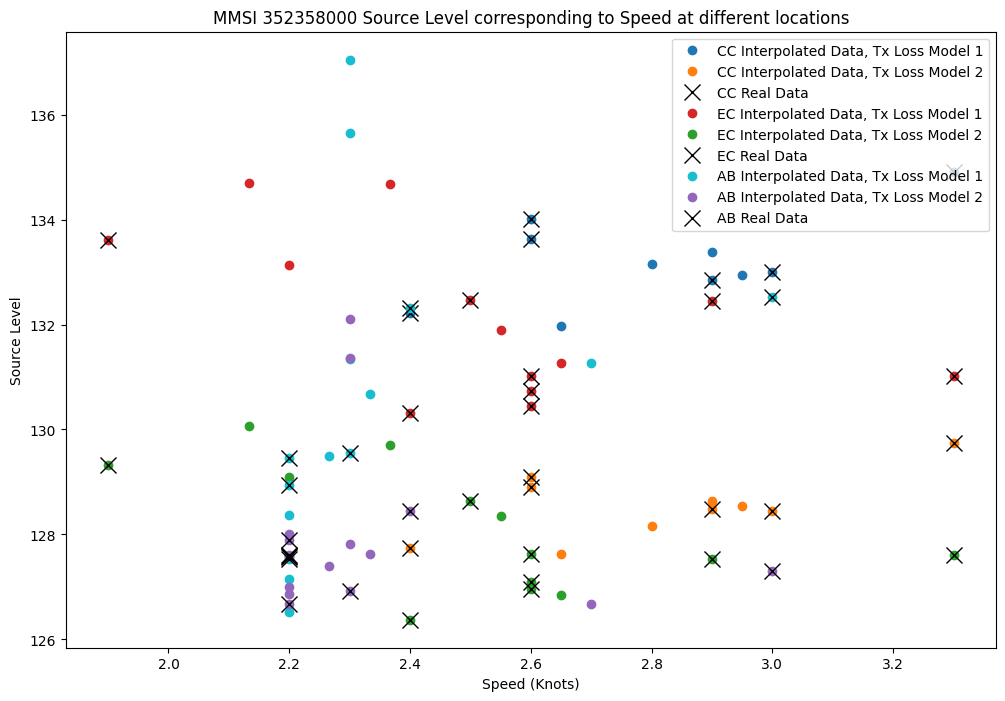

In [66]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level2, 'kx', markersize=12)

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Speed (Knots)')
plt.legend()
#plt.xlim(0,2)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Speed at different locations')

#### Source vs. Range

Text(0.5, 1.0, 'MMSI 352358000 Source Level corresponding to Range at different locations')

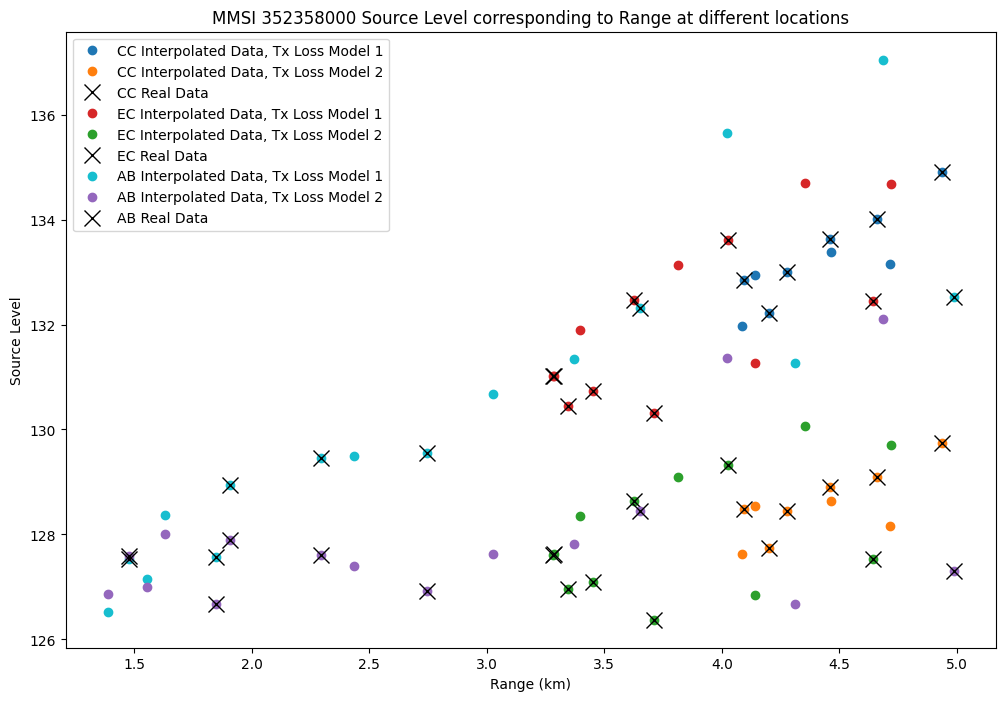

In [67]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level2, 'kx', markersize=12)

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Range (km)')
plt.legend()
#plt.xlim(0,2)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Range at different locations')

# MMSI 538005544 AIS Data

### AIS Data setup/exploration

In [68]:
ais2016a = pd.read_csv('data/AIS/2016A - Updated.csv', delimiter=',')
ais2016b = pd.read_csv('data/AIS/2016B - Updated.csv', delimiter=',')
ais2017a = pd.read_csv('data/AIS/2017A - Updated.csv', delimiter=',')
ais2017b = pd.read_csv('data/AIS/2017B - Updated.csv', delimiter=',')
MMSI = 538005544
spectrogram_times = {
    'EC' : ['2016-11-27 17:21:08', '2016-11-27 17:35:07'],
    'CC' : ['2016-11-27 17:21:08', '2016-11-27 17:27:37'],
    'AB' : ['2016-11-26 21:20:06', '2016-11-26 21:49:48']
}
ais = pd.concat([ais2016a, ais2016b, ais2017a, ais2017b], axis=0)
ais = ais[ais['MMSI'] == MMSI]#.reset_index(drop=True)
ais

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
54693  538005544    GLORY  Bulk Carrier       0               113  46.48639   
54699  538005544    GLORY  Bulk Carrier       0               114  46.48688   
54702  538005544    GLORY  Bulk Carrier       0               116  46.48803   
54711  538005544    GLORY  Bulk Carrier       0               119  46.48941   
54714  538005544    GLORY  Bulk Carrier       0               118  46.49056   
...          ...      ...           ...     ...               ...       ...   
63376  538005544    GLORY  Bulk Carrier       0               112  46.59201   
63378  538005544    GLORY  Bulk Carrier       0               111  46.59531   
63381  538005544    GLORY  Bulk Carrier       0               112  46.60358   
63382  538005544    GLORY  Bulk Carrier       0               111  46.61769   
63384  538005544    GLORY  Bulk Carrier       0               111  46.62325   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
54693 -131.2600      90       94  2016-11-25 01:14:58   225.0  
54699 -131.1016      90       94  2016-11-25 01:49:36   225.0  
54702 -130.9681      91       95  2016-11-25 02:18:06   225.0  
54711 -130.8693      87       94  2016-11-25 02:39:17   225.0  
54714 -130.7923      89       95  2016-11-25 02:55:36   225.0  
...         ...     ...      ...                  ...     ...  
63376 -131.1118     284      288  2016-12-12 14:43:00   225.0  
63378 -131.1284     287      288  2016-12-12 14:46:51   225.0  
63381 -131.1701     285      288  2016-12-12 14:56:31   225.0  
63382 -131.2386     285      287  2016-12-12 15:12:21   225.0  
63384 -131.2666     286      289  2016-12-12 15:18:51   225.0  

[282 rows x 11 columns]

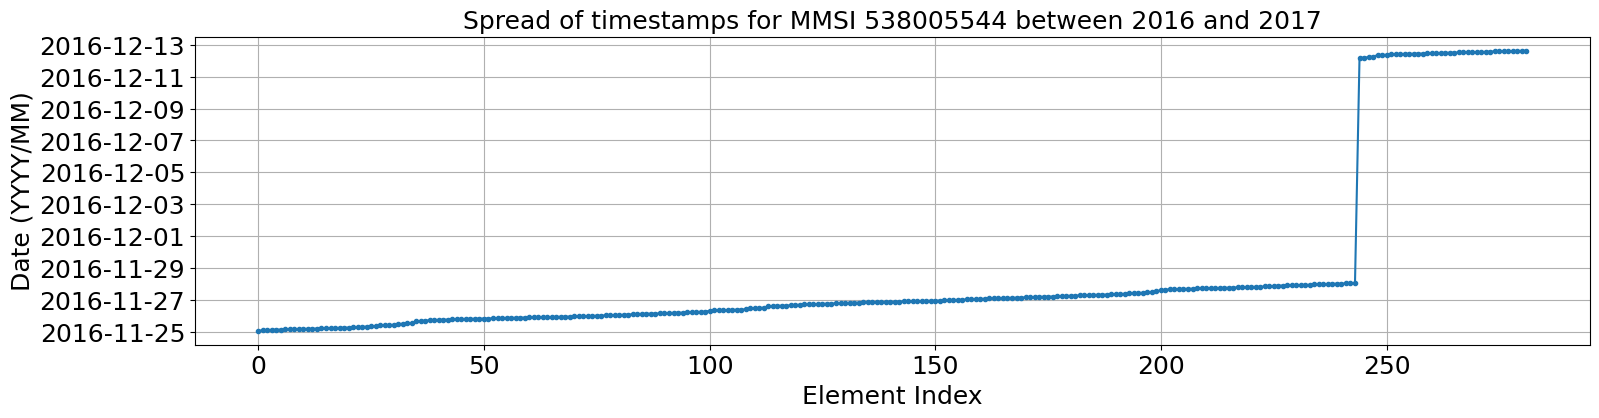

In [24]:
plt.subplots(figsize=(18,4))
plt.plot(pd.to_datetime(ais['TIMESTAMP UTC'].reset_index(drop=True)), marker='.')
plt.xlabel('Element Index', fontsize=18)
plt.ylabel('Date (YYYY/MM)', fontsize=18)
plt.title('Spread of timestamps for MMSI '+str(MMSI) + ' between 2016 and 2017', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid()

### EC Timeframe

In [69]:
EC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['EC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['EC'][1]) + datetime.timedelta(hours=3))]
EC_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
56112  538005544    GLORY  Bulk Carrier       0                86  45.87027   
56116  538005544    GLORY  Bulk Carrier       0                89  45.89979   
56121  538005544    GLORY  Bulk Carrier       0                87  45.90670   
56130  538005544    GLORY  Bulk Carrier       0               108  45.91910   
56133  538005544    GLORY  Bulk Carrier       0               112  45.91186   
56139  538005544    GLORY  Bulk Carrier       0               102  45.91041   
56150  538005544    GLORY  Bulk Carrier       0                85  45.91284   
56154  538005544    GLORY  Bulk Carrier       0                86  45.92242   
56162  538005544    GLORY  Bulk Carrier       0                86  45.92518   
56172  538005544    GLORY  Bulk Carrier       0                87  45.93698   
56175  538005544    GLORY  Bulk Carrier       0                90  45.94065   
56179  538005544    GLORY  Bulk Carrier       0                90  45.94502   
56185  538005544    GLORY  Bulk Carrier       0                90  45.95403   
56190  538005544    GLORY  Bulk Carrier       0                90  45.95734   
56197  538005544    GLORY  Bulk Carrier       0                72  45.96452   
56203  538005544    GLORY  Bulk Carrier       0                68  45.96971   
56206  538005544    GLORY  Bulk Carrier       0                68  45.97328   
56222  538005544    GLORY  Bulk Carrier       0                69  45.97776   
56232  538005544    GLORY  Bulk Carrier       0                69  45.98849   
56239  538005544    GLORY  Bulk Carrier       0                69  45.99107   
56243  538005544    GLORY  Bulk Carrier       0                70  45.99531   
56245  538005544    GLORY  Bulk Carrier       0                69  45.99630   
56256  538005544    GLORY  Bulk Carrier       0                69  46.00598   
56267  538005544    GLORY  Bulk Carrier       0                67  46.01157   
56273  538005544    GLORY  Bulk Carrier       0                65  46.01570   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
56112 -130.2155     302      301  2016-11-27 15:15:07   225.0  
56116 -130.2853     300      300  2016-11-27 15:39:56   225.0  
56121 -130.3011     300      299  2016-11-27 15:45:37   225.0  
56130 -130.3023     109      110  2016-11-27 16:04:47   225.0  
56133 -130.2361      97      100  2016-11-27 16:19:38   225.0  
56139 -130.2012      89       89  2016-11-27 16:27:57   225.0  
56150 -130.1715      74       79  2016-11-27 16:36:08   225.0  
56154 -130.1098      78       81  2016-11-27 16:54:47   225.0  
56162 -130.0928      78       79  2016-11-27 16:59:47   225.0  
56172 -130.0219      73       80  2016-11-27 17:21:08   225.0  
56175 -129.9995      76       80  2016-11-27 17:27:37   225.0  
56179 -129.9735      76       80  2016-11-27 17:35:07   225.0  
56185 -129.9201      78       78  2016-11-27 17:50:27   225.0  
56190 -129.9001      76       82  2016-11-27 17:56:07   225.0  
56197 -129.8526      74       79  2016-11-27 18:10:38   225.0  
56203 -129.8197      74       79  2016-11-27 18:22:46   225.0  
56206 -129.7961      82       79  2016-11-27 18:31:36   225.0  
56222 -129.7666      74       79  2016-11-27 18:42:47   225.0  
56232 -129.6920      80       81  2016-11-27 19:10:48   225.0  
56239 -129.6734      84       79  2016-11-27 19:17:36   225.0  
56243 -129.6422      74       78  2016-11-27 19:29:07   225.0  
56245 -129.6360      76       81  2016-11-27 19:31:27   225.0  
56256 -129.5586      80       80  2016-11-27 19:59:57   225.0  
56267 -129.5058      82       78  2016-11-27 20:19:18   225.0  
56273 -129.4636      81       78  2016-11-27 20:34:58   225.0

In [70]:
EC_interpolated = ten_min_interp(split_10m(EC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
EC_interpolated['instance_id'] = 'EC_' + EC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + EC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
EC_interpolated['distance(in km)'] = EC_interpolated['ecdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


#### Downloading node timeframe specific files

In [27]:
DL_Mseed_for_time_filtered_file(EC_interpolated, EC_interpolated.iloc[0]['TIMESTAMP UTC'], EC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='EC')

OO.AXEC2.AXEC2.HDH | 2016-11-27T15:15:07.000000Z - 2016-11-27T15:25:07.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127151507_20161127152507.mseed
OO.AXEC2.AXEC2.HDH | 2016-11-27T15:25:08.000000Z - 2016-11-27T15:35:08.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127152508_20161127153508.mseed
OO.AXEC2.AXEC2.HDH | 2016-11-27T15:35:09.000000Z - 2016-11-27T15:45:09.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127153509_20161127154509.mseed
OO.AXEC2.AXEC2.HDH | 2016-11-27T15:45:37.000000Z - 2016-11-27T15:55:37.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127154537_20161127155537.mseed
OO.AXEC2.AXEC2.HDH | 2016-11-27T15:55:38.000000Z - 2016-11-27T16:05:38.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127155538_20161127160538.mseed
OO.AXEC2.AXEC2.HDH | 2016-11-27T16:14:48.000000Z - 2016-11-27T16:24:48.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20161127161448_20161127162448.msee

### CC Timeframe

In [71]:
CC_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['CC'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC']) <= pd.to_datetime(spectrogram_times['CC'][1]) + datetime.timedelta(hours=3))]
CC_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
56112  538005544    GLORY  Bulk Carrier       0                86  45.87027   
56116  538005544    GLORY  Bulk Carrier       0                89  45.89979   
56121  538005544    GLORY  Bulk Carrier       0                87  45.90670   
56130  538005544    GLORY  Bulk Carrier       0               108  45.91910   
56133  538005544    GLORY  Bulk Carrier       0               112  45.91186   
56139  538005544    GLORY  Bulk Carrier       0               102  45.91041   
56150  538005544    GLORY  Bulk Carrier       0                85  45.91284   
56154  538005544    GLORY  Bulk Carrier       0                86  45.92242   
56162  538005544    GLORY  Bulk Carrier       0                86  45.92518   
56172  538005544    GLORY  Bulk Carrier       0                87  45.93698   
56175  538005544    GLORY  Bulk Carrier       0                90  45.94065   
56179  538005544    GLORY  Bulk Carrier       0                90  45.94502   
56185  538005544    GLORY  Bulk Carrier       0                90  45.95403   
56190  538005544    GLORY  Bulk Carrier       0                90  45.95734   
56197  538005544    GLORY  Bulk Carrier       0                72  45.96452   
56203  538005544    GLORY  Bulk Carrier       0                68  45.96971   
56206  538005544    GLORY  Bulk Carrier       0                68  45.97328   
56222  538005544    GLORY  Bulk Carrier       0                69  45.97776   
56232  538005544    GLORY  Bulk Carrier       0                69  45.98849   
56239  538005544    GLORY  Bulk Carrier       0                69  45.99107   
56243  538005544    GLORY  Bulk Carrier       0                70  45.99531   
56245  538005544    GLORY  Bulk Carrier       0                69  45.99630   
56256  538005544    GLORY  Bulk Carrier       0                69  46.00598   
56267  538005544    GLORY  Bulk Carrier       0                67  46.01157   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
56112 -130.2155     302      301  2016-11-27 15:15:07   225.0  
56116 -130.2853     300      300  2016-11-27 15:39:56   225.0  
56121 -130.3011     300      299  2016-11-27 15:45:37   225.0  
56130 -130.3023     109      110  2016-11-27 16:04:47   225.0  
56133 -130.2361      97      100  2016-11-27 16:19:38   225.0  
56139 -130.2012      89       89  2016-11-27 16:27:57   225.0  
56150 -130.1715      74       79  2016-11-27 16:36:08   225.0  
56154 -130.1098      78       81  2016-11-27 16:54:47   225.0  
56162 -130.0928      78       79  2016-11-27 16:59:47   225.0  
56172 -130.0219      73       80  2016-11-27 17:21:08   225.0  
56175 -129.9995      76       80  2016-11-27 17:27:37   225.0  
56179 -129.9735      76       80  2016-11-27 17:35:07   225.0  
56185 -129.9201      78       78  2016-11-27 17:50:27   225.0  
56190 -129.9001      76       82  2016-11-27 17:56:07   225.0  
56197 -129.8526      74       79  2016-11-27 18:10:38   225.0  
56203 -129.8197      74       79  2016-11-27 18:22:46   225.0  
56206 -129.7961      82       79  2016-11-27 18:31:36   225.0  
56222 -129.7666      74       79  2016-11-27 18:42:47   225.0  
56232 -129.6920      80       81  2016-11-27 19:10:48   225.0  
56239 -129.6734      84       79  2016-11-27 19:17:36   225.0  
56243 -129.6422      74       78  2016-11-27 19:29:07   225.0  
56245 -129.6360      76       81  2016-11-27 19:31:27   225.0  
56256 -129.5586      80       80  2016-11-27 19:59:57   225.0  
56267 -129.5058      82       78  2016-11-27 20:19:18   225.0

In [72]:
CC_interpolated = ten_min_interp(split_10m(CC_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
CC_interpolated['instance_id'] = 'CC_' + CC_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + CC_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
CC_interpolated['distance(in km)'] = CC_interpolated['ccdist']*1.609344 # convert from milse to km

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


#### Downloading node timeframe specific files

In [34]:
DL_Mseed_for_time_filtered_file(CC_interpolated, CC_interpolated.iloc[0]['TIMESTAMP UTC'], CC_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='CC')

OO.AXCC1.AXCC1.HDH | 2016-11-27T15:15:07.000000Z - 2016-11-27T15:25:07.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127151507_20161127152507.mseed
OO.AXCC1.AXCC1.HDH | 2016-11-27T15:25:08.000000Z - 2016-11-27T15:35:08.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127152508_20161127153508.mseed
OO.AXCC1.AXCC1.HDH | 2016-11-27T15:35:09.000000Z - 2016-11-27T15:45:09.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127153509_20161127154509.mseed
OO.AXCC1.AXCC1.HDH | 2016-11-27T15:45:37.000000Z - 2016-11-27T15:55:37.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127154537_20161127155537.mseed
OO.AXCC1.AXCC1.HDH | 2016-11-27T15:55:38.000000Z - 2016-11-27T16:05:38.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127155538_20161127160538.mseed
OO.AXCC1.AXCC1.HDH | 2016-11-27T16:14:48.000000Z - 2016-11-27T16:24:48.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20161127161448_20161127162448.msee

### AB Timeframe

In [73]:
AB_timeframe = ais[(pd.to_datetime(ais['TIMESTAMP UTC']) >= pd.to_datetime(spectrogram_times['AB'][0]) - datetime.timedelta(hours=3)) & (pd.to_datetime(ais['TIMESTAMP UTC'] )<= pd.to_datetime(spectrogram_times['AB'][1]) + datetime.timedelta(hours=3))]
AB_timeframe

MMSI SHIPNAME   VESSEL TYPE  STATUS  SPEED (KNOTSx10)       LAT  \
55432  538005544    GLORY  Bulk Carrier       0                74  45.96909   
55447  538005544    GLORY  Bulk Carrier       0                72  45.94741   
55448  538005544    GLORY  Bulk Carrier       0                73  45.94371   
55461  538005544    GLORY  Bulk Carrier       0                72  45.92322   
55468  538005544    GLORY  Bulk Carrier       0                71  45.91823   
55473  538005544    GLORY  Bulk Carrier       0                72  45.91472   
55479  538005544    GLORY  Bulk Carrier       0                70  45.89944   
55485  538005544    GLORY  Bulk Carrier       0                69  45.89251   
55495  538005544    GLORY  Bulk Carrier       0                71  45.88099   
55497  538005544    GLORY  Bulk Carrier       0                72  45.87907   
55506  538005544    GLORY  Bulk Carrier       0                72  45.86773   
55511  538005544    GLORY  Bulk Carrier       0                75  45.86295   
55516  538005544    GLORY  Bulk Carrier       0                73  45.85755   
55518  538005544    GLORY  Bulk Carrier       0                72  45.85565   
55527  538005544    GLORY  Bulk Carrier       0                73  45.84107   
55536  538005544    GLORY  Bulk Carrier       0                69  45.83420   
55538  538005544    GLORY  Bulk Carrier       0                70  45.83273   
55557  538005544    GLORY  Bulk Carrier       0                70  45.81673   
55565  538005544    GLORY  Bulk Carrier       0                71  45.80545   
55574  538005544    GLORY  Bulk Carrier       0                71  45.79967   
55581  538005544    GLORY  Bulk Carrier       0                70  45.78836   
55594  538005544    GLORY  Bulk Carrier       0                69  45.77080   
55601  538005544    GLORY  Bulk Carrier       0                71  45.76761   
55611  538005544    GLORY  Bulk Carrier       0                70  45.75515   
55624  538005544    GLORY  Bulk Carrier       0                69  45.73772   
55634  538005544    GLORY  Bulk Carrier       0                72  45.71338   
55642  538005544    GLORY  Bulk Carrier       0                71  45.70651   
55648  538005544    GLORY  Bulk Carrier       0                67  45.68217   
55656  538005544    GLORY  Bulk Carrier       0                70  45.65935   
55661  538005544    GLORY  Bulk Carrier       0                70  45.65172   
55668  538005544    GLORY  Bulk Carrier       0                67  45.64252   

            LON  COURSE  HEADING        TIMESTAMP UTC  LENGTH  
55432 -130.2654     112      110  2016-11-26 18:28:08   225.0  
55447 -130.1835     109      109  2016-11-26 18:57:38   225.0  
55448 -130.1695     113      109  2016-11-26 19:02:49   225.0  
55461 -130.0928     113      111  2016-11-26 19:30:37   225.0  
55468 -130.0753     112      109  2016-11-26 19:37:17   225.0  
55473 -130.0634     115      110  2016-11-26 19:41:48   225.0  
55479 -130.0094     110      107  2016-11-26 20:02:38   225.0  
55485 -129.9861     112      108  2016-11-26 20:11:27   225.0  
55495 -129.9461     112      110  2016-11-26 20:26:47   225.0  
55497 -129.9400     115      109  2016-11-26 20:29:07   225.0  
55506 -129.9033     117      115  2016-11-26 20:43:28   225.0  
55511 -129.8900     113      115  2016-11-26 20:48:37   225.0  
55516 -129.8754     117      113  2016-11-26 20:54:17   225.0  
55518 -129.8702     117      114  2016-11-26 20:56:17   225.0  
55527 -129.8319     116      113  2016-11-26 21:11:17   225.0  
55536 -129.8137     115      113  2016-11-26 21:18:28   225.0  
55538 -129.8096     119      115  2016-11-26 21:20:06   225.0  
55557 -129.7667     118      117  2016-11-26 21:37:19   225.0  
55565 -129.7361     117      115  2016-11-26 21:49:48   225.0  
55574 -129.7210     116      114  2016-11-26 21:55:57   225.0  
55581 -129.6898     113      114  2016-11-26 22:08:27   225.0  
55594 -129.6434     119      113  2016-11-26 22:27:37   225.0  
55601 -129.

In [74]:
AB_interpolated = ten_min_interp(split_10m(AB_timeframe))
#EC_interpolated = add_hphone_dist(EC_interpolated)
AB_interpolated['instance_id'] = 'AB_' + AB_interpolated['start_time'].dt.strftime("%Y%m%d%H%M%S") + '_' + AB_interpolated['end_time'].dt.strftime("%Y%m%d%H%M%S")
AB_interpolated['distance(in km)'] = AB_interpolated['abdist']*1.609344 # convert from milse to km
#AB_interpolated

C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)
C:\Users\UserALai\AppData\Local\Temp\ipykernel_16836\3351006084.py:364: SettingWithCopyWarning: 
A value is trying to be set on a 

#### Downloading node timeframe specific files

In [37]:
DL_Mseed_for_time_filtered_file(AB_interpolated, AB_interpolated.iloc[0]['TIMESTAMP UTC'], AB_interpolated.iloc[-1]['TIMESTAMP UTC'], verbose=True, node_override='AB')

OO.AXBA1.AXBA1.HDH | 2016-11-26T18:28:08.000000Z - 2016-11-26T18:38:08.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126182808_20161126183808.mseed
OO.AXBA1.AXBA1.HDH | 2016-11-26T18:38:09.000000Z - 2016-11-26T18:48:09.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126183809_20161126184809.mseed
OO.AXBA1.AXBA1.HDH | 2016-11-26T18:48:10.000000Z - 2016-11-26T18:58:10.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126184810_20161126185810.mseed
OO.AXBA1.AXBA1.HDH | 2016-11-26T19:02:49.000000Z - 2016-11-26T19:12:49.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126190249_20161126191249.mseed
OO.AXBA1.AXBA1.HDH | 2016-11-26T19:12:50.000000Z - 2016-11-26T19:22:50.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126191250_20161126192250.mseed
OO.AXBA1.AXBA1.HDH | 2016-11-26T19:22:51.000000Z - 2016-11-26T19:32:51.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/AB_20161126192251_20161126193251.msee

### Combining Location Plots

#### Range, Speed, Rx vs. Time

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


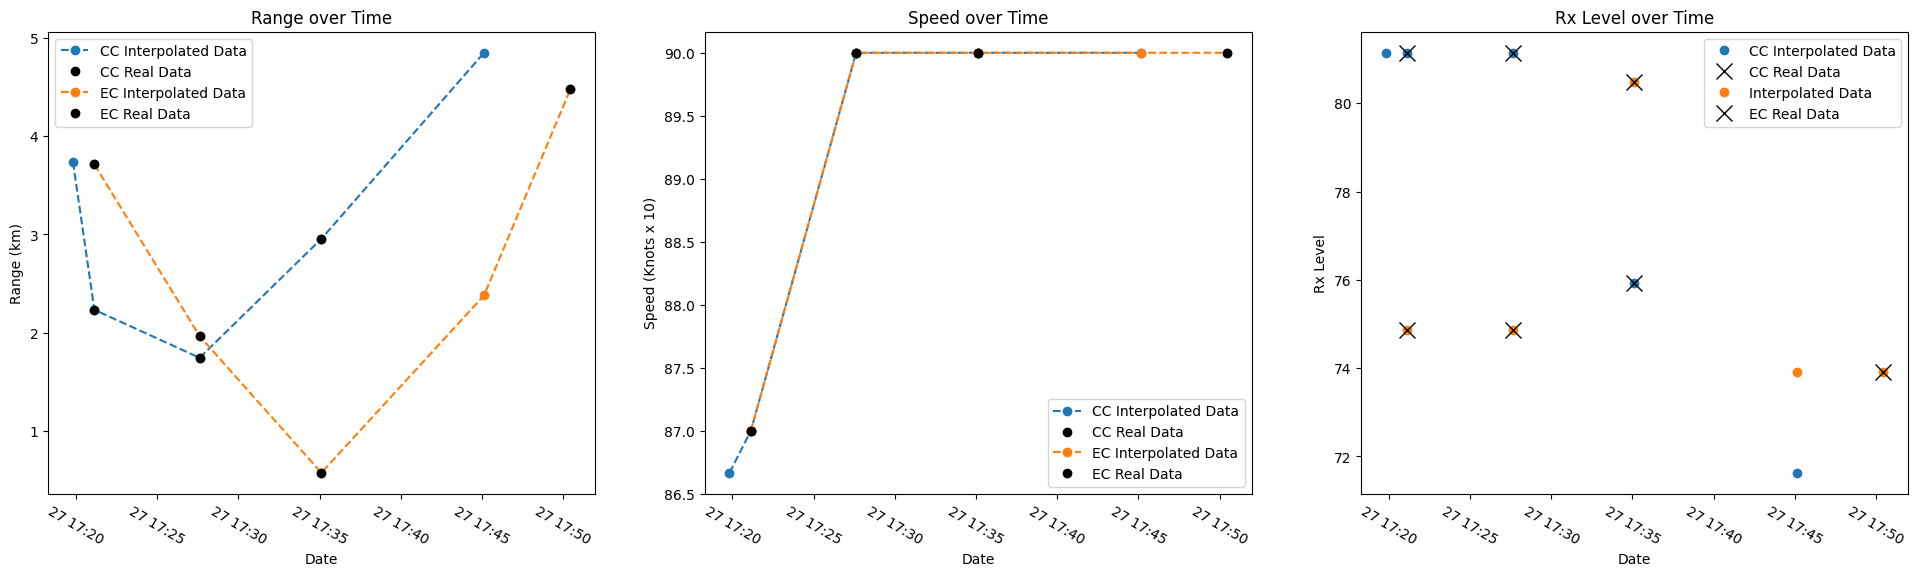

In [75]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

#ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')
ax[0].plot(CC_data['TIMESTAMP UTC'], CC_data['distance(in km)'], 'o--', label='CC Interpolated Data')
#ax[0].plot(CC_data['distance(in km)'], CC_data['TIMESTAMP UTC'], 'o--', label='CC Interpolated Data')
ax[0].plot(CC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], CC_data.dropna()['distance(in km)'], 'ko', label='CC Real Data')
#ax[0].plot(CC_data.dropna().reset_index(drop=True)['distance(in km)'], CC_data.dropna()['TIMESTAMP UTC'], 'ko', label='CC Real Data')
ax[0].plot(EC_data['TIMESTAMP UTC'], EC_data['distance(in km)'], 'o--', label='EC Interpolated Data')
#ax[0].plot(EC_data['distance(in km)'], EC_data['TIMESTAMP UTC'], 'o--', label='EC Interpolated Data')
ax[0].plot(EC_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], EC_data.dropna()['distance(in km)'], 'ko', label='EC Real Data')
#ax[0].plot(EC_data.dropna().reset_index(drop=True)['distance(in km)'], EC_data.dropna()['TIMESTAMP UTC'], 'ko', label='EC Real Data')


#ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'o--', label='AB Interpolated Data')
#ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')
ax[1].plot(CC_data['TIMESTAMP UTC'], CC_data['SPEED (KNOTSx10)'], 'o--', label='CC Interpolated Data')
ax[1].plot(CC_data.dropna()['TIMESTAMP UTC'], CC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='CC Real Data')
ax[1].plot(EC_data['TIMESTAMP UTC'], EC_data['SPEED (KNOTSx10)'], 'o--', label='EC Interpolated Data')
ax[1].plot(EC_data.dropna()['TIMESTAMP UTC'], EC_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='EC Real Data')

#ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'o', label='AB Interpolated Data')
#ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)
ax[2].plot(CC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], CC_Rx_level, 'o', label='CC Interpolated Data')
ax[2].plot(CC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], CC_Rx_level_real, 'kx', label='CC Real Data', markersize=12)
ax[2].plot(EC_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], EC_Rx_level, 'o', label='Interpolated Data')
ax[2].plot(EC_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], EC_Rx_level_real, 'kx', label='EC Real Data', markersize=12)



ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


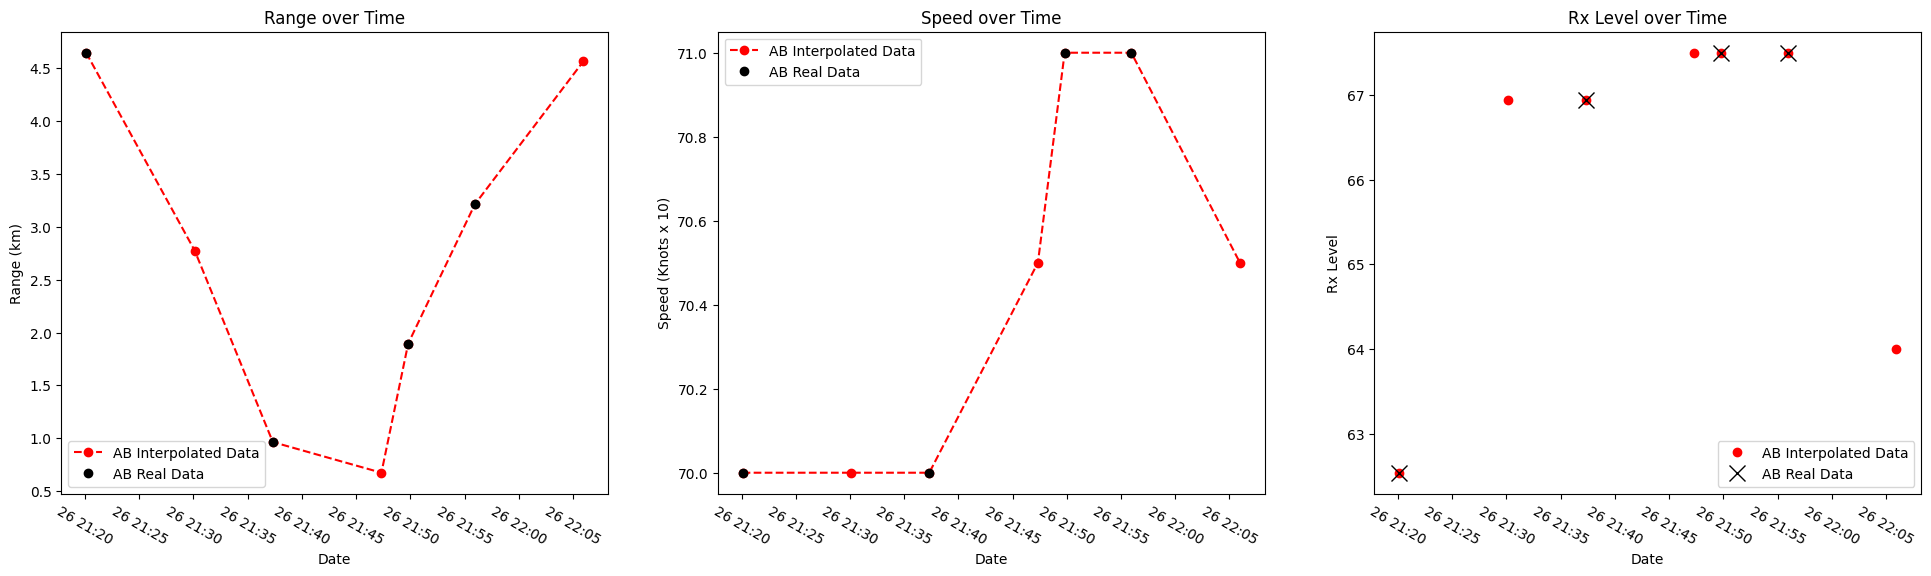

In [39]:
EC_data = EC_interpolated[EC_interpolated['distance(in km)'] < 5]
AB_data = AB_interpolated[AB_interpolated['distance(in km)'] < 5]
CC_data = CC_interpolated[CC_interpolated['distance(in km)'] < 5]

CC_R_real, CC_Rx_level_real = Rx_level_from_df(CC_data.dropna(), 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
AB_R_real, AB_Rx_level_real = Rx_level_from_df(AB_data.dropna(), 'AIS')
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
EC_R_real, EC_Rx_level_real = Rx_level_from_df(EC_data.dropna(), 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')


fig, ax = plt.subplots(1, 3, figsize=(24,6))

ax[0].plot(AB_data['TIMESTAMP UTC'], AB_data['distance(in km)'], 'ro--', label='AB Interpolated Data')
#ax[0].plot(AB_data['distance(in km)'], AB_data['TIMESTAMP UTC'], 'o--', label='AB Interpolated Data')
ax[0].plot(AB_data.dropna().reset_index(drop=True)['TIMESTAMP UTC'], AB_data.dropna()['distance(in km)'], 'ko', label='AB Real Data')
#ax[0].plot(AB_data.dropna().reset_index(drop=True)['distance(in km)'], AB_data.dropna()['TIMESTAMP UTC'], 'ko', label='AB Real Data')

ax[1].plot(AB_data['TIMESTAMP UTC'], AB_data['SPEED (KNOTSx10)'], 'ro--', label='AB Interpolated Data')
ax[1].plot(AB_data.dropna()['TIMESTAMP UTC'], AB_data.dropna()['SPEED (KNOTSx10)'], 'ko', label='AB Real Data')

ax[2].plot(AB_data.sort_values(by='distance(in km)')['TIMESTAMP UTC'], AB_Rx_level, 'ro', label='AB Interpolated Data')
ax[2].plot(AB_data.sort_values(by='distance(in km)').dropna()['TIMESTAMP UTC'], AB_Rx_level_real, 'kx', label='AB Real Data', markersize=12)

ax[0].set_ylabel('Range (km)')
ax[0].set_xlabel('Date')
ax[0].set_title('Range over Time')
ax[0].tick_params(axis='x', labelrotation=-30)
ax[0].legend()

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Speed (Knots x 10)')
ax[1].set_title('Speed over Time')
ax[1].tick_params(axis='x', labelrotation=-30)
ax[1].legend()

ax[2].set_xlabel('Date')
ax[2].set_ylabel('Rx Level')
ax[2].set_title('Rx Level over Time')
ax[2].tick_params(axis='x', labelrotation=-30)
ax[2].legend()

#### Rx vs. Range

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


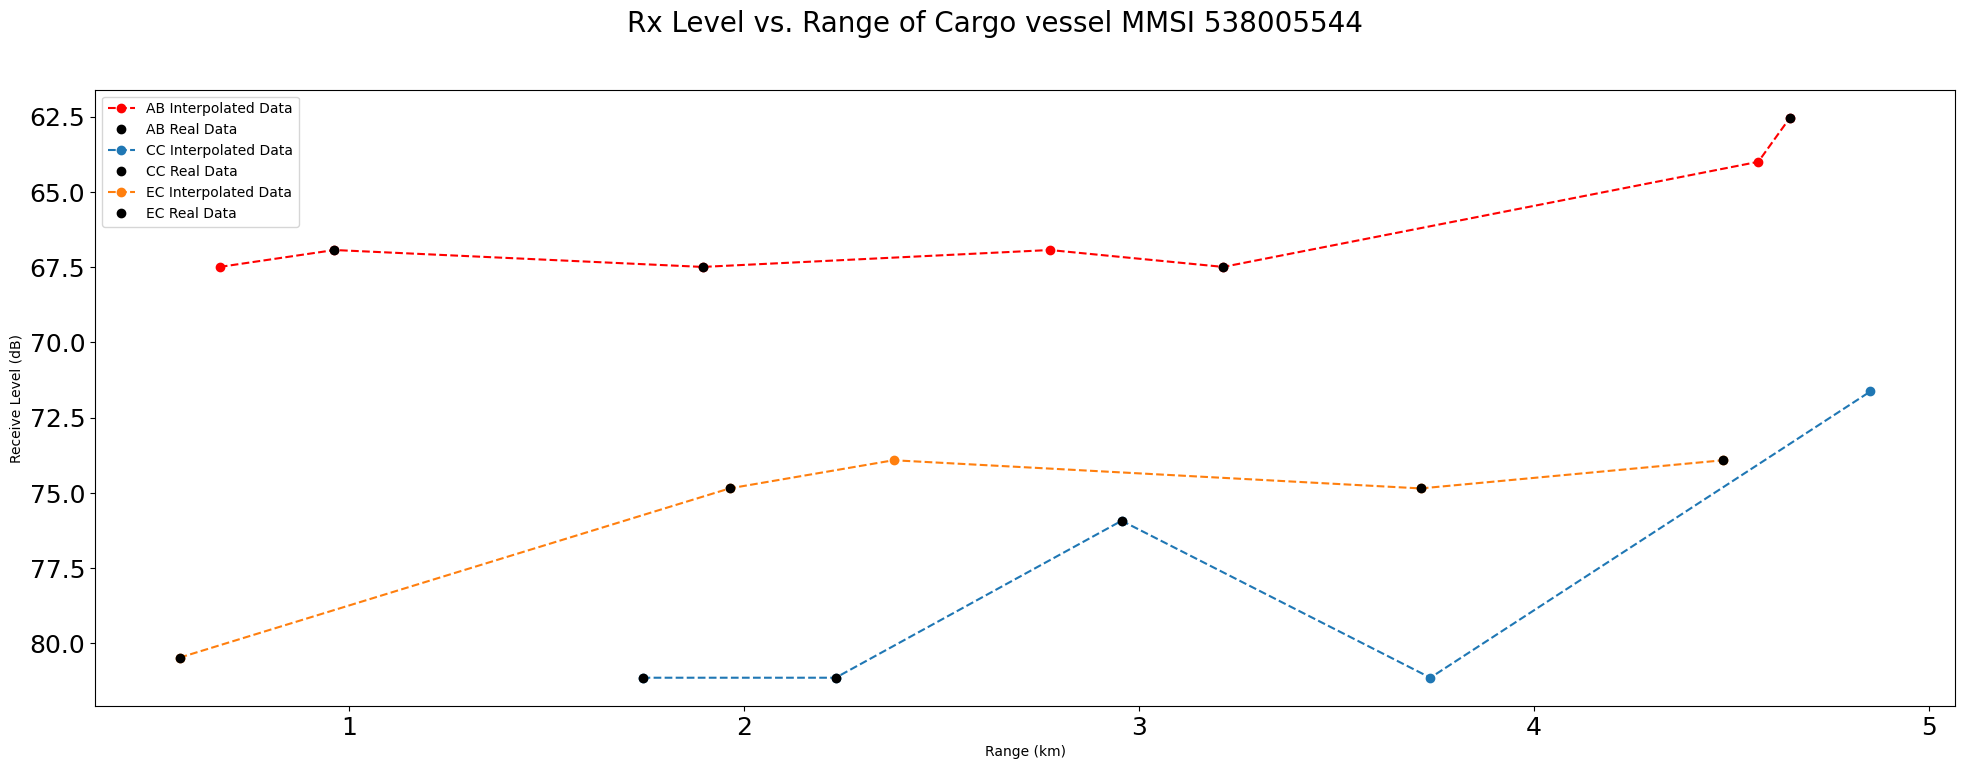

In [76]:
AB_R, AB_Rx_level = Rx_level_from_df(AB_data, 'AIS')
CC_R, CC_Rx_level = Rx_level_from_df(CC_data, 'AIS')
EC_R, EC_Rx_level = Rx_level_from_df(EC_data, 'AIS')
AB_TRUE_R, AB_TRUE_Rx_level = Rx_level_from_df(AB_data.dropna(), 'AIS')
CC_TRUE_R, CC_TRUE_Rx_level = Rx_level_from_df(CC_data.dropna(), 'AIS')
EC_TRUE_R, EC_TRUE_Rx_level = Rx_level_from_df(EC_data.dropna(), 'AIS')
fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Range of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(AB_R, AB_Rx_level, 'ro--', label='AB Interpolated Data')
ax.plot(AB_TRUE_R, AB_TRUE_Rx_level, 'ko', label='AB Real Data')

ax.plot(CC_R, CC_Rx_level, 'o--', color='tab:blue', label='CC Interpolated Data')
ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')

ax.plot(EC_R, EC_Rx_level, 'o--', color='tab:orange', label='EC Interpolated Data')
ax.plot(EC_TRUE_R, EC_TRUE_Rx_level, 'ko', label='EC Real Data')

ax.set_ylabel("Receive Level (dB)")
ax.invert_yaxis()#.gca().invert_yaxis()
#ax.set_xlim(.8,5)
ax.legend()
ax.set_xlabel('Range (km)')
plt.tick_params(axis='both', which='major', labelsize=18)

#### Rx vs. Speed

Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0
Files not found: 0


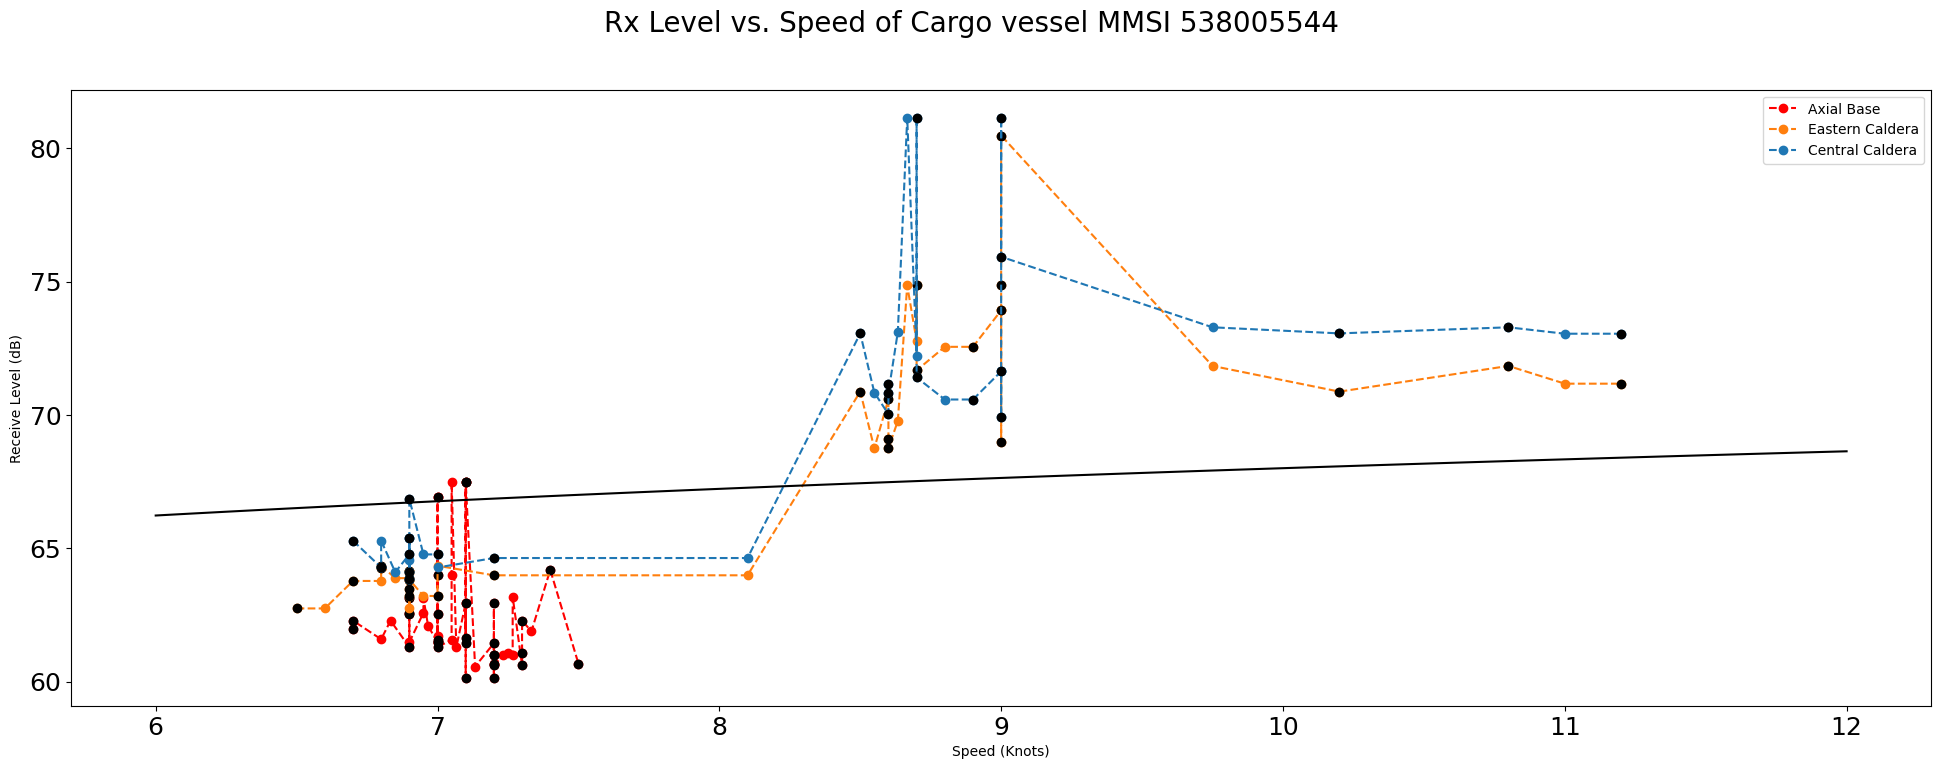

In [29]:
AB_S, AB_Rx_level = Rx_level_from_df_SPEED(AB_interpolated, 'AIS')
AB_S_real, AB_Rx_level_real = Rx_level_from_df_SPEED(AB_interpolated.dropna(), 'AIS')
EC_S, EC_Rx_level = Rx_level_from_df_SPEED(EC_interpolated, 'AIS')
EC_S_real, EC_Rx_level_real = Rx_level_from_df_SPEED(EC_interpolated.dropna(), 'AIS')
CC_S, CC_Rx_level = Rx_level_from_df_SPEED(CC_interpolated, 'AIS')
CC_S_real, CC_Rx_level_real = Rx_level_from_df_SPEED(CC_interpolated.dropna(), 'AIS')

fig, ax = plt.subplots(figsize=(24,8))
fig.suptitle('Rx Level vs. Speed of Cargo vessel MMSI ' + str(MMSI), fontsize=20)

ax.plot(np.asarray(AB_S)/10, AB_Rx_level, 'ro--', label='Axial Base')
ax.plot(np.asarray(AB_S_real)/10, AB_Rx_level_real, 'ko')
ax.plot(np.asarray(EC_S)/10, EC_Rx_level, 'o--', color='tab:orange', label='Eastern Caldera')
ax.plot(np.asarray(EC_S_real)/10, EC_Rx_level_real, 'ko')
ax.plot(np.asarray(CC_S)/10, CC_Rx_level, 'o--', color='tab:blue', label='Central Caldera')
ax.plot(np.asarray(CC_S_real)/10, CC_Rx_level_real, 'ko')
#ax.plot(np.asarray(CC_S)/10, 8*np.log10(np.asarray(CC_S)/10)+60)
x = np.linspace(6, 12, 50)
ax.plot(x, 8*np.log10(x)+60, 'k')
plt.legend()
plt.xlabel('Speed (Knots)')
plt.ylabel("Receive Level (dB)")
#plt.xlim(0,3)
plt.tick_params(axis='both', which='major', labelsize=18)

#### Source vs. Speed

Text(0.5, 1.0, 'MMSI 538005544 Source Level corresponding to Speed at different locations')

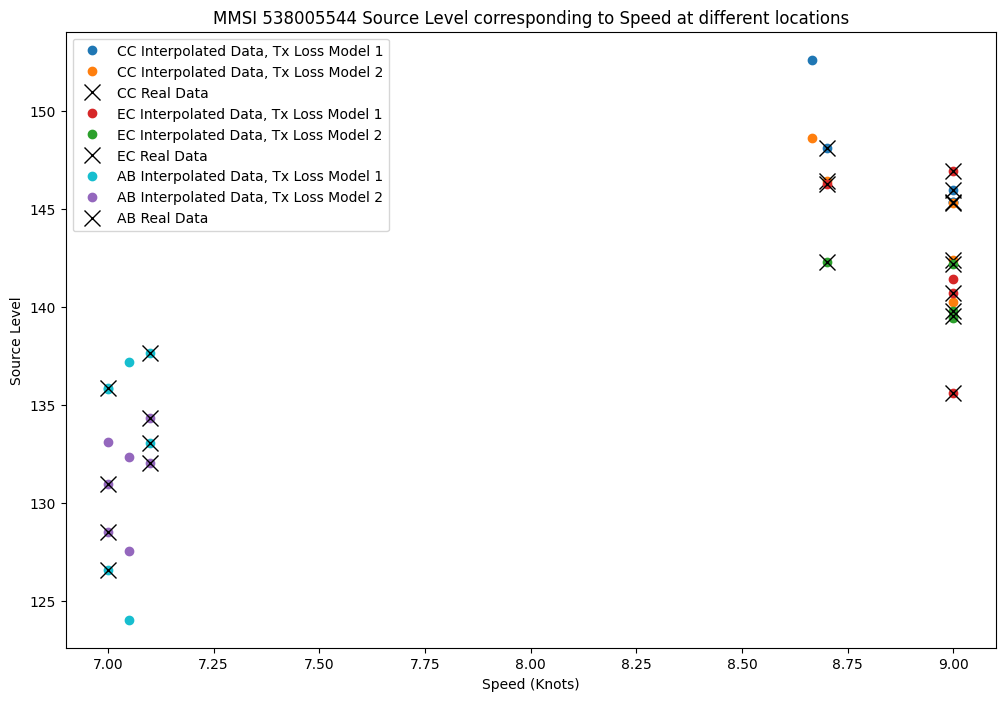

In [77]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['SPEED (KNOTSx10)']/10, AB_TRUE_source_level2, 'kx', markersize=12)

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Speed (Knots)')
plt.legend()
#plt.xlim(8.5,9.25)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Speed at different locations')

#### Source vs. Range

Text(0.5, 1.0, 'MMSI 538005544 Source Level corresponding to Range at different locations')

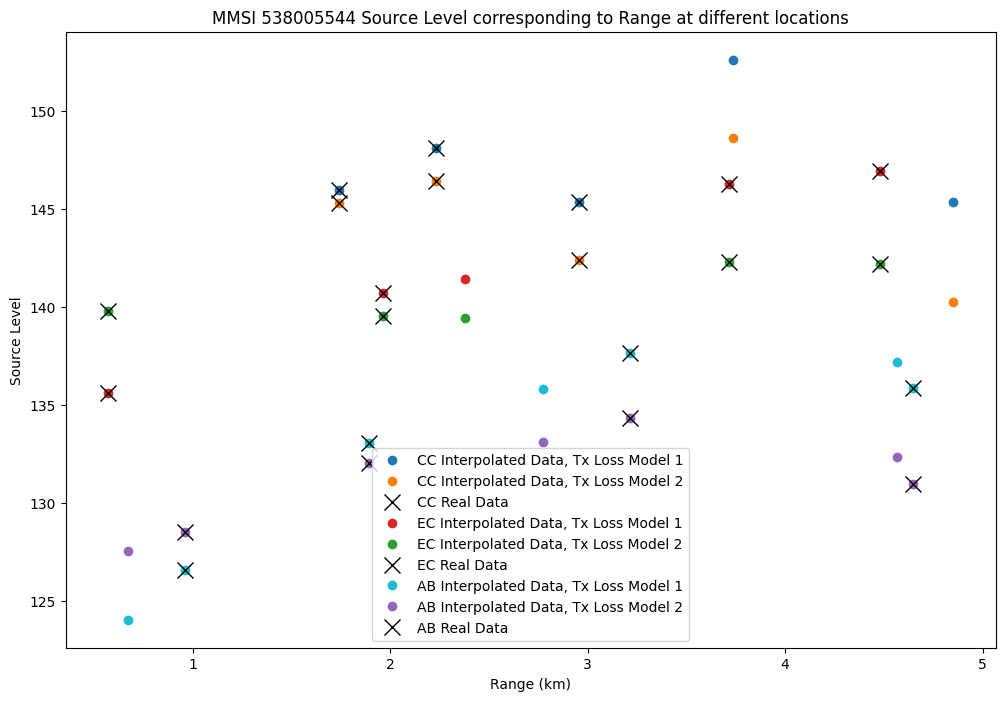

In [78]:
plt.subplots(figsize=(12,8))

CC_loss1 = np.abs(Tx_loss1(np.asarray(CC_R)))
CC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(CC_TRUE_R)))
CC_loss2 = np.abs(Tx_loss2(np.asarray(CC_R), 'CC'))
CC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(CC_TRUE_R), 'CC'))
CC_source_level1 = np.ma.masked_invalid(CC_Rx_level+CC_loss1)
CC_TRUE_source_level1 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss1)
CC_source_level2 = np.ma.masked_invalid(CC_Rx_level+CC_loss2)
CC_TRUE_source_level2 = np.ma.masked_invalid(CC_TRUE_Rx_level+CC_TRUE_loss2)

EC_loss1 = np.abs(Tx_loss1(np.asarray(EC_R)))
EC_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(EC_TRUE_R)))
EC_loss2 = np.abs(Tx_loss2(np.asarray(EC_R), 'CC'))
EC_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(EC_TRUE_R), 'CC'))
EC_source_level1 = np.ma.masked_invalid(EC_Rx_level+EC_loss1)
EC_TRUE_source_level1 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss1)
EC_source_level2 = np.ma.masked_invalid(EC_Rx_level+EC_loss2)
EC_TRUE_source_level2 = np.ma.masked_invalid(EC_TRUE_Rx_level+EC_TRUE_loss2)

AB_loss1 = np.abs(Tx_loss1(np.asarray(AB_R)))
AB_TRUE_loss1 = np.abs(Tx_loss1(np.asarray(AB_TRUE_R)))
AB_loss2 = np.abs(Tx_loss2(np.asarray(AB_R), 'CC'))
AB_TRUE_loss2 = np.abs(Tx_loss2(np.asarray(AB_TRUE_R), 'CC'))
AB_source_level1 = np.ma.masked_invalid(AB_Rx_level+AB_loss1)
AB_TRUE_source_level1 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss1)
AB_source_level2 = np.ma.masked_invalid(AB_Rx_level+AB_loss2)
AB_TRUE_source_level2 = np.ma.masked_invalid(AB_TRUE_Rx_level+AB_TRUE_loss2)

plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level1, 'o', color='tab:blue', label='CC Interpolated Data, Tx Loss Model 1')
plt.plot(CC_data.sort_values(by='distance(in km)')['distance(in km)'], CC_source_level2, 'o', color='tab:orange', label='CC Interpolated Data, Tx Loss Model 2')
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level1, 'kx', label='CC Real Data', markersize=12)
plt.plot(CC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], CC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level1, 'o', color='tab:red', label='EC Interpolated Data, Tx Loss Model 1')
plt.plot(EC_data.sort_values(by='distance(in km)')['distance(in km)'], EC_source_level2, 'o', color='tab:green', label='EC Interpolated Data, Tx Loss Model 2')
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level1, 'kx', label='EC Real Data', markersize=12)
plt.plot(EC_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], EC_TRUE_source_level2, 'kx', markersize=12)

plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level1, 'o', color='tab:cyan', label='AB Interpolated Data, Tx Loss Model 1')
plt.plot(AB_data.sort_values(by='distance(in km)')['distance(in km)'], AB_source_level2, 'o', color='tab:purple', label='AB Interpolated Data, Tx Loss Model 2')
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level1, 'kx', label='AB Real Data', markersize=12)
plt.plot(AB_data.dropna().sort_values(by='distance(in km)')['distance(in km)'], AB_TRUE_source_level2, 'kx', markersize=12)

#ax.plot(CC_TRUE_R, CC_TRUE_Rx_level, 'ko', label='CC Real Data')
plt.ylabel('Source Level')
plt.xlabel('Range (km)')
plt.legend()
#plt.xlim(0,2)
plt.title('MMSI ' + str(MMSI) + ' Source Level corresponding to Range at different locations')